In [42]:
# importing the libraries used

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from xgboost import XGBRegressor
from prophet import Prophet
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [43]:
# initializing the scalers

scaler_min = MinMaxScaler()
scaler_pow = PowerTransformer()

In [44]:
# defining a function to calculate the root mean square error

def rmse(x, y):
    return np.sqrt(mean_squared_error(x, y))

In [45]:
# Load the dataset
df = pd.read_csv("hungary_chickenpox.csv")

df.head(3)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 21 columns]

In [46]:
# performing data preprocessing

df.insert(0, "Week", [i for i in range(1, len(df) + 1)])

df.head(3)

Week        Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1  03/01/2005       168       79    30    173     169        42    136  \
1     2  10/01/2005       157       60    30     92     200        53     51   
2     3  17/01/2005        96       44    31     86      93        30     93   

   GYOR  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0   120  ...   130       57       2   178      66        64     11   29  \
1    70  ...    80       50      29   141      48        29     58   53   
2    84  ...    64       46       4   157      33        33     24   18   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  

[3 rows x 22 columns]

In [47]:
county_list = df.columns.to_list()
county_list.remove('Week')
county_list.remove('Date')

county_list

['BUDAPEST',
 'BARANYA',
 'BACS',
 'BEKES',
 'BORSOD',
 'CSONGRAD',
 'FEJER',
 'GYOR',
 'HAJDU',
 'HEVES',
 'JASZ',
 'KOMAROM',
 'NOGRAD',
 'PEST',
 'SOMOGY',
 'SZABOLCS',
 'TOLNA',
 'VAS',
 'VESZPREM',
 'ZALA']

In [48]:
# initializing dictionary to hold the average rmse values of all the models to be tested

model_mean_rmse = {}

Getting Graphs of the data of all counties:

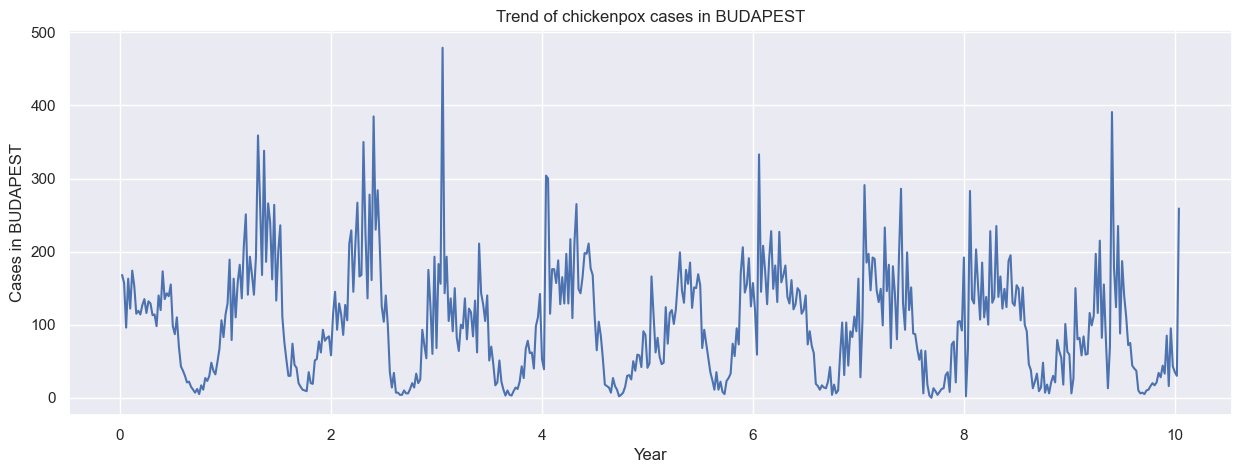

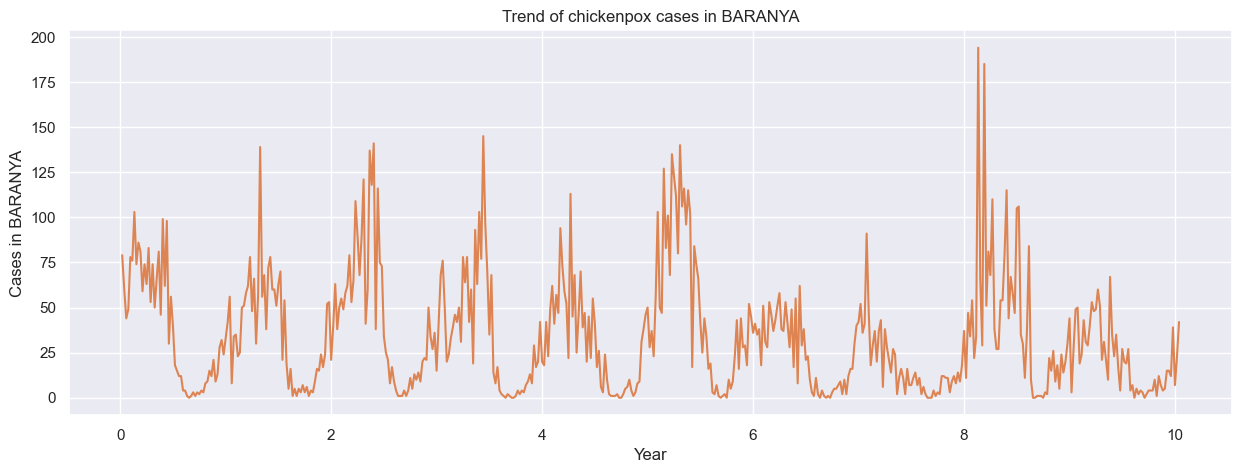

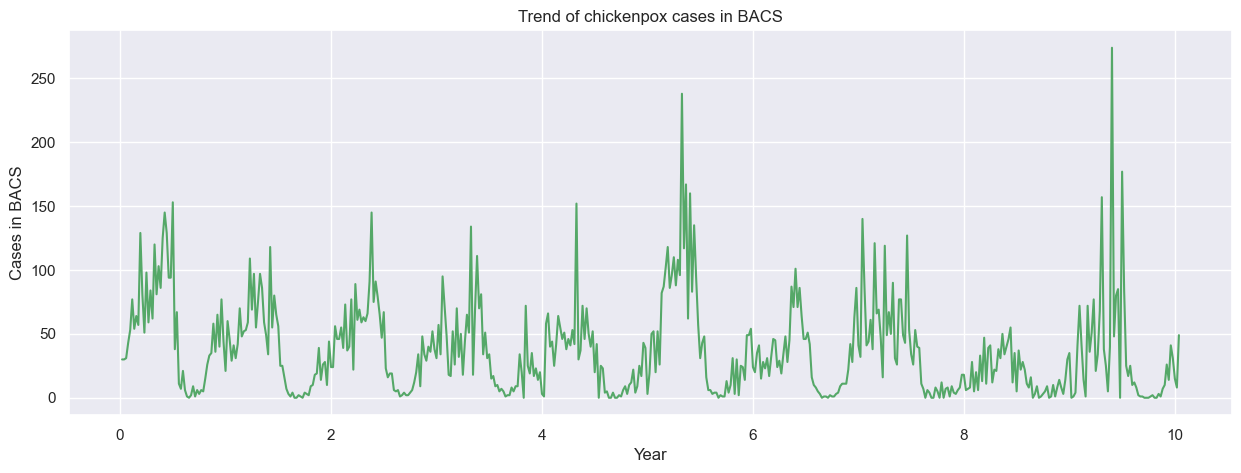

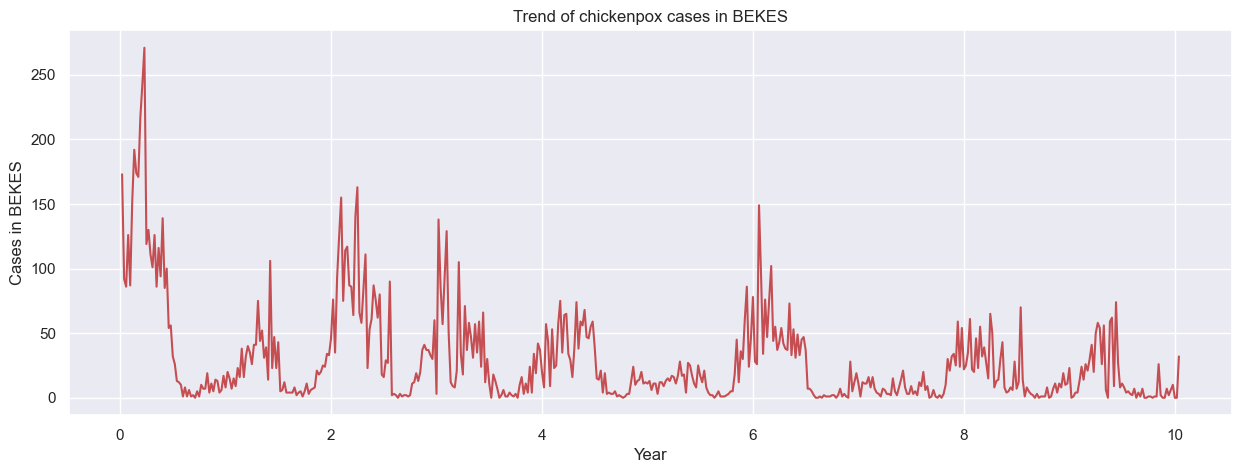

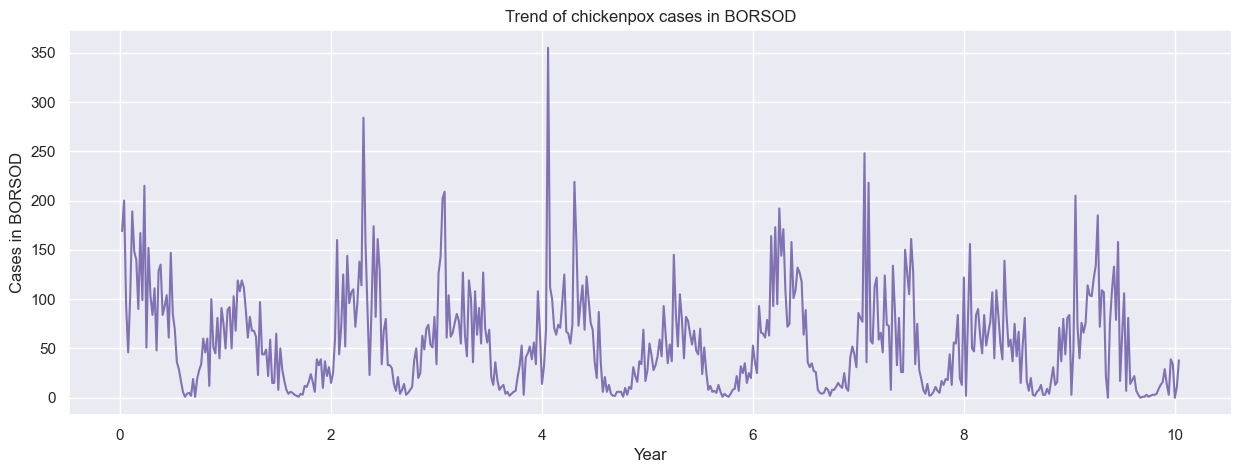

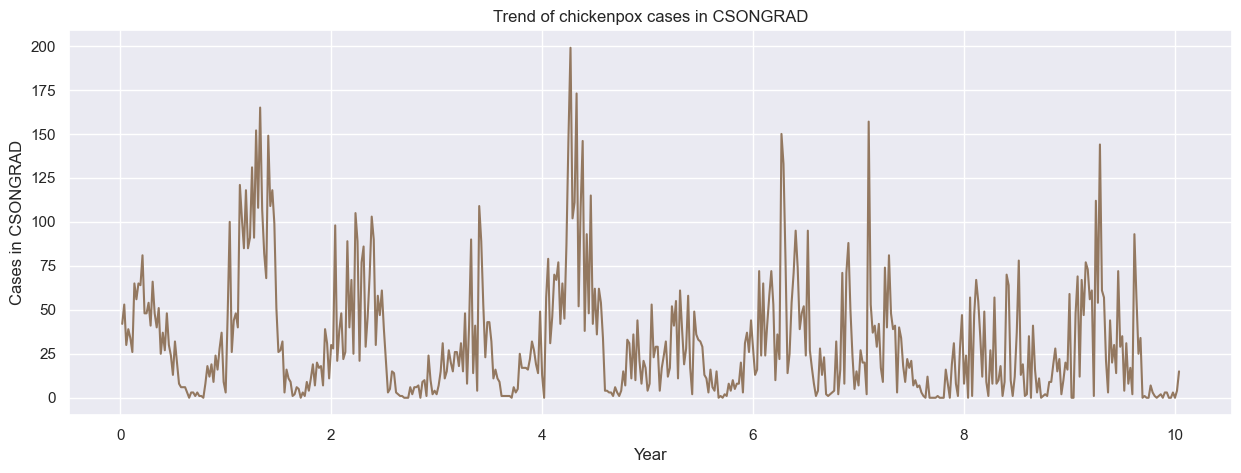

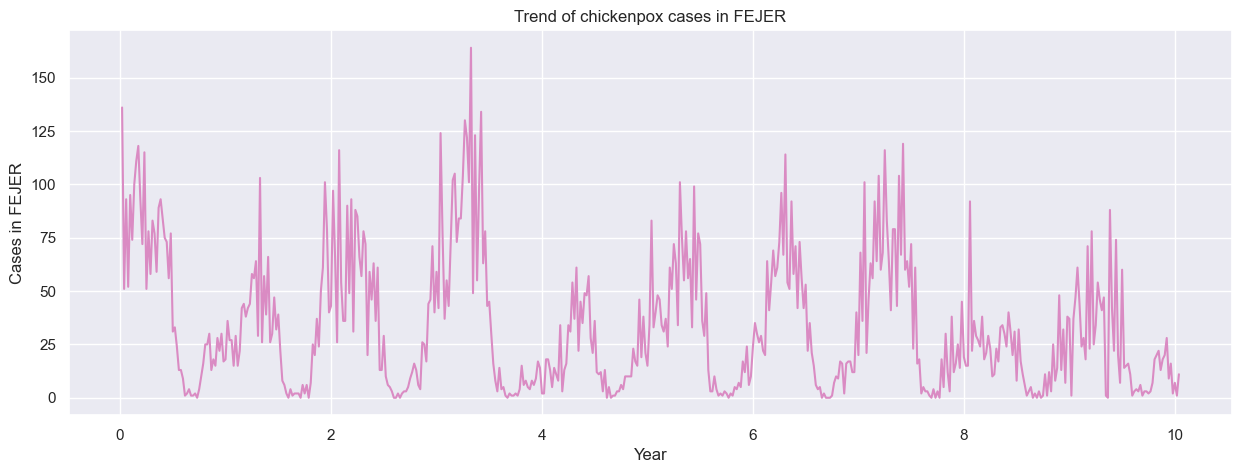

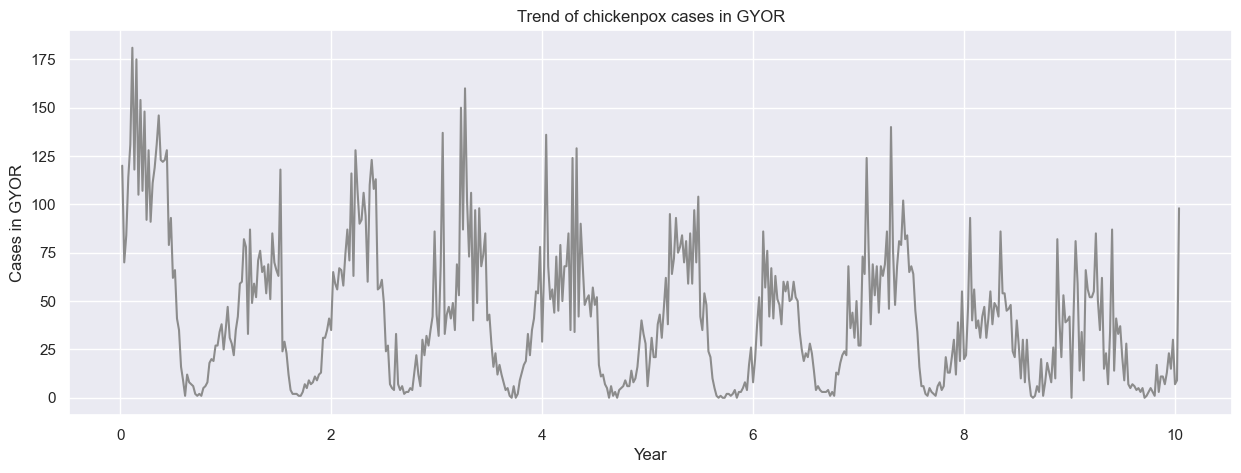

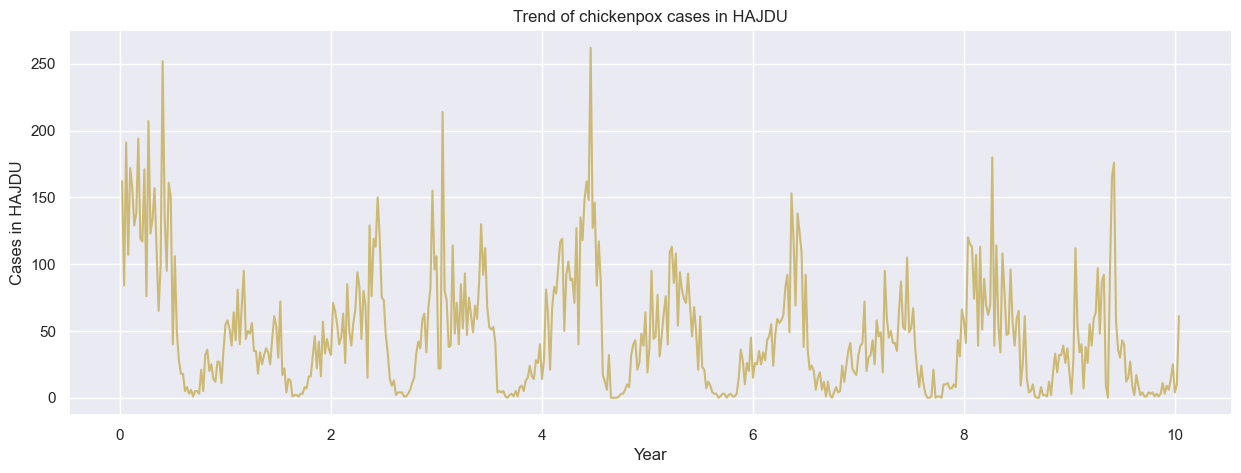

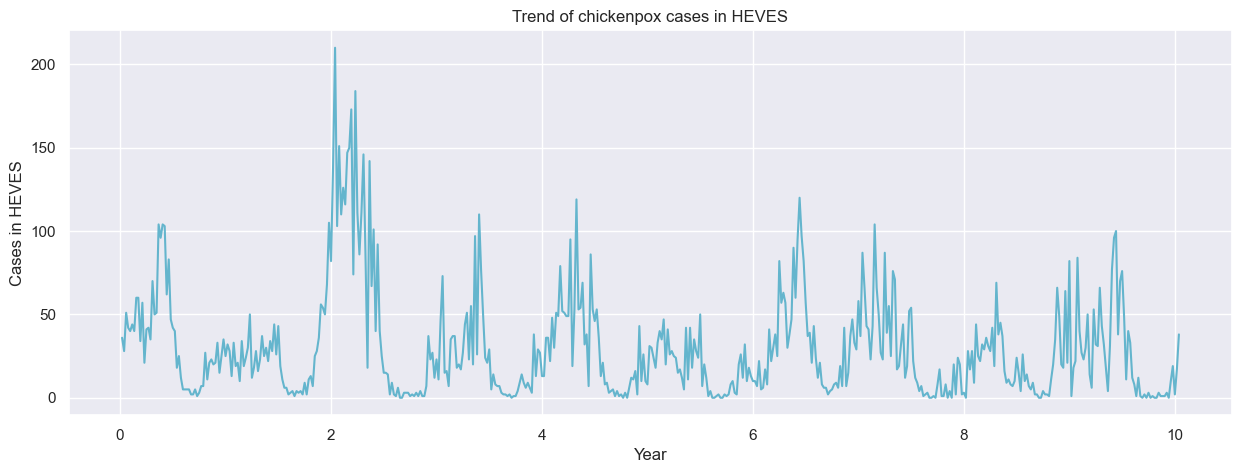

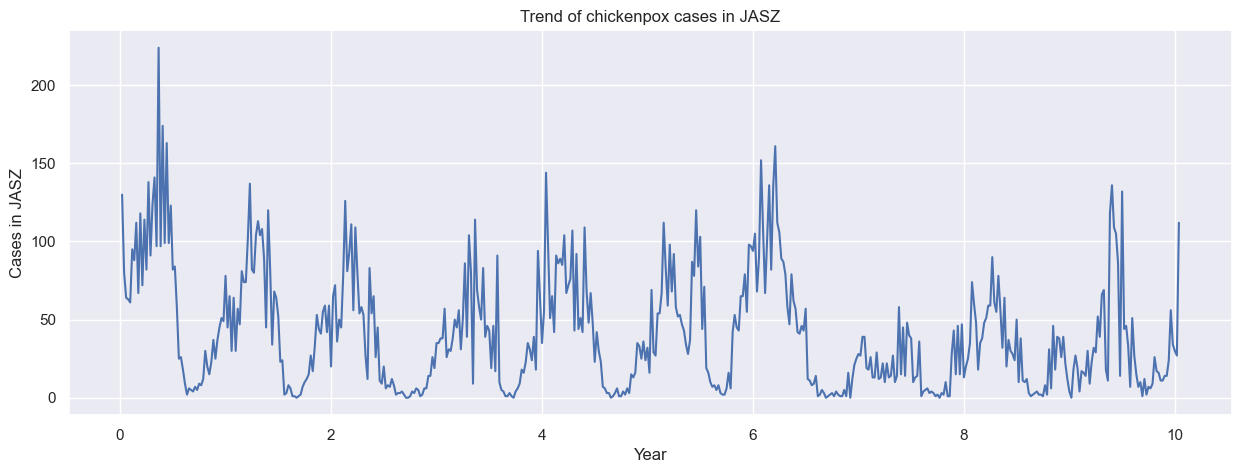

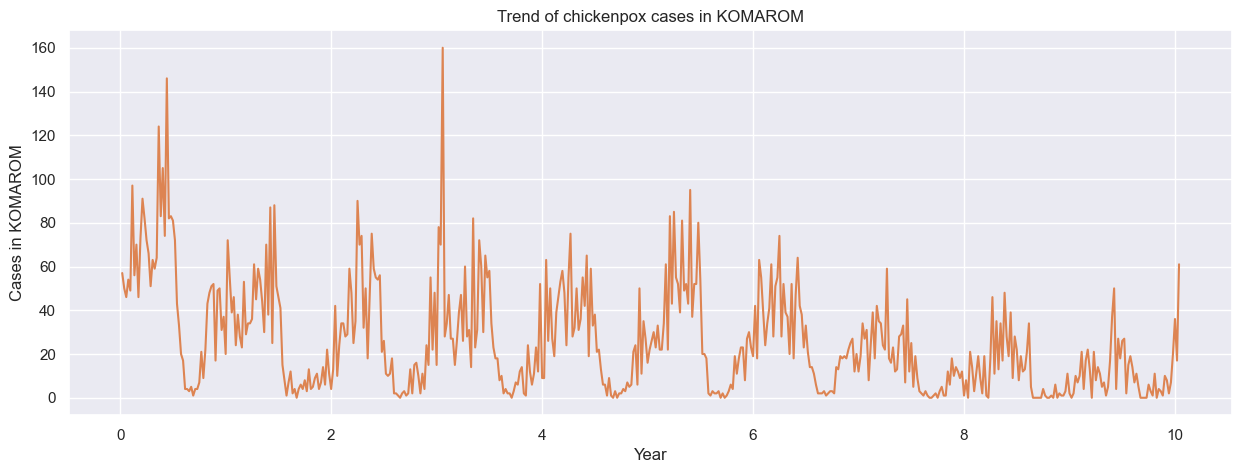

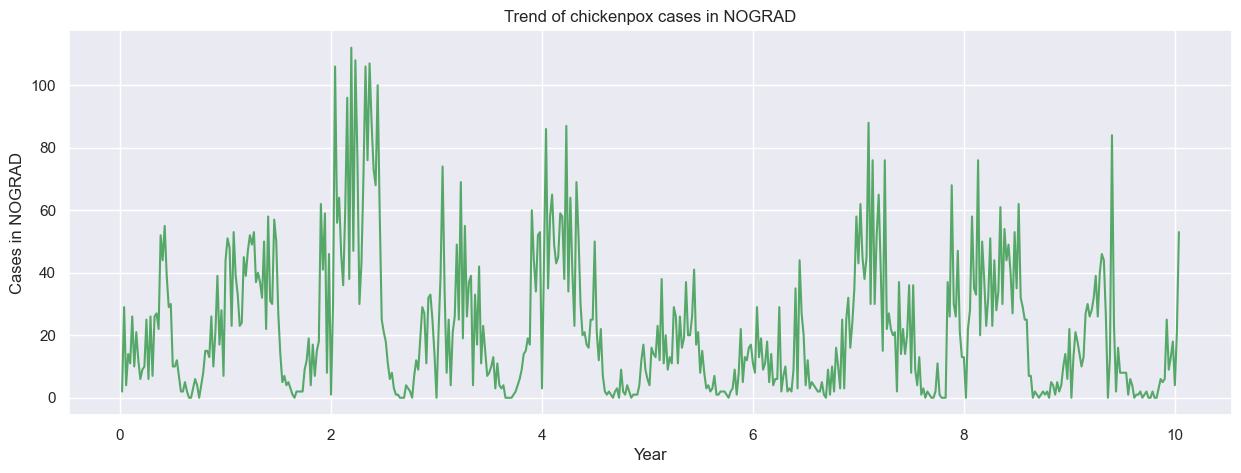

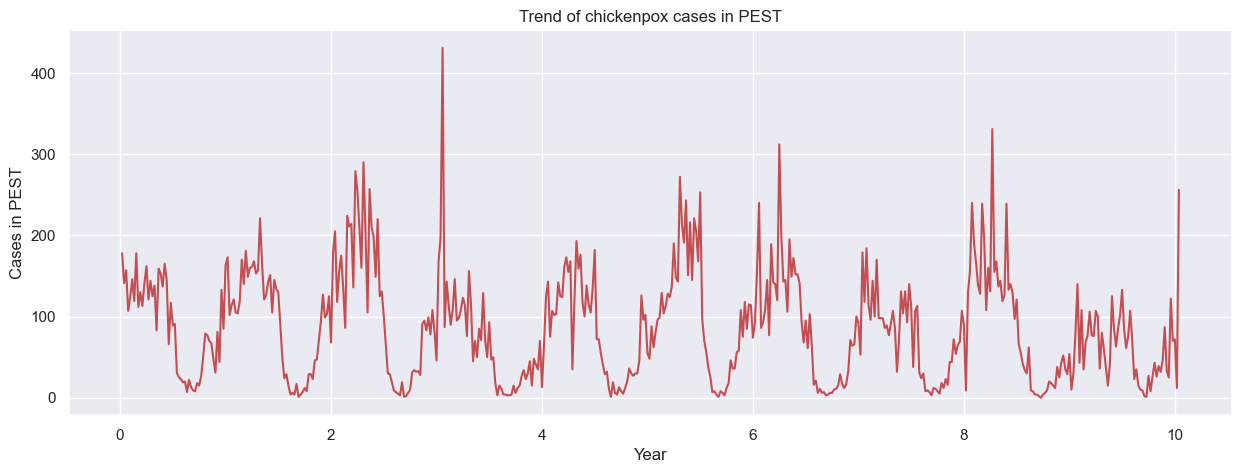

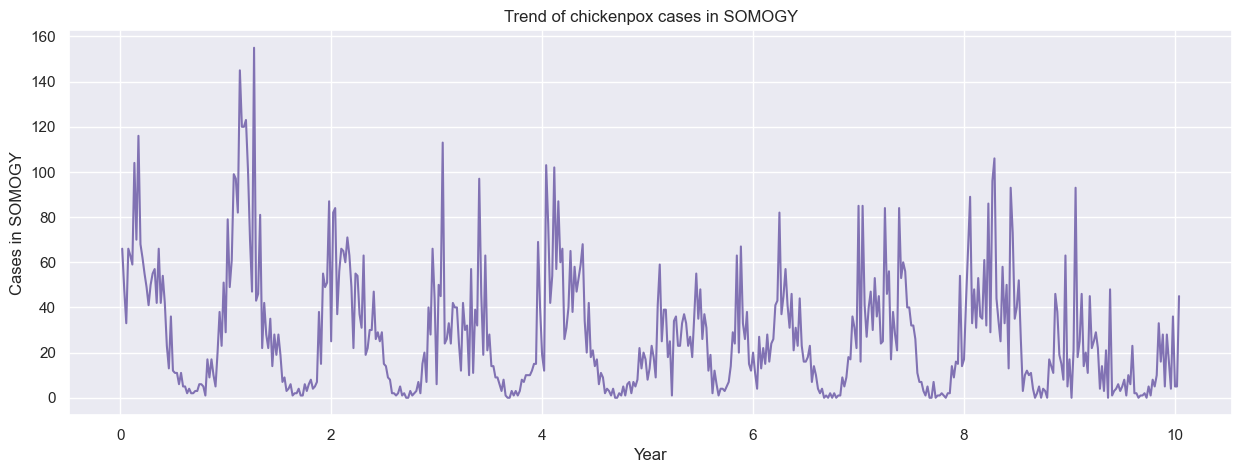

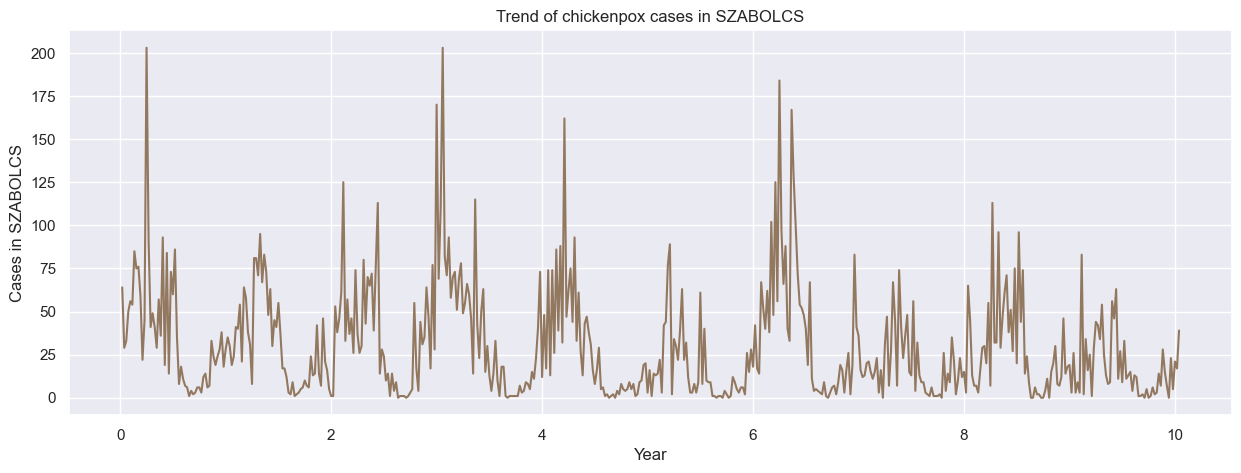

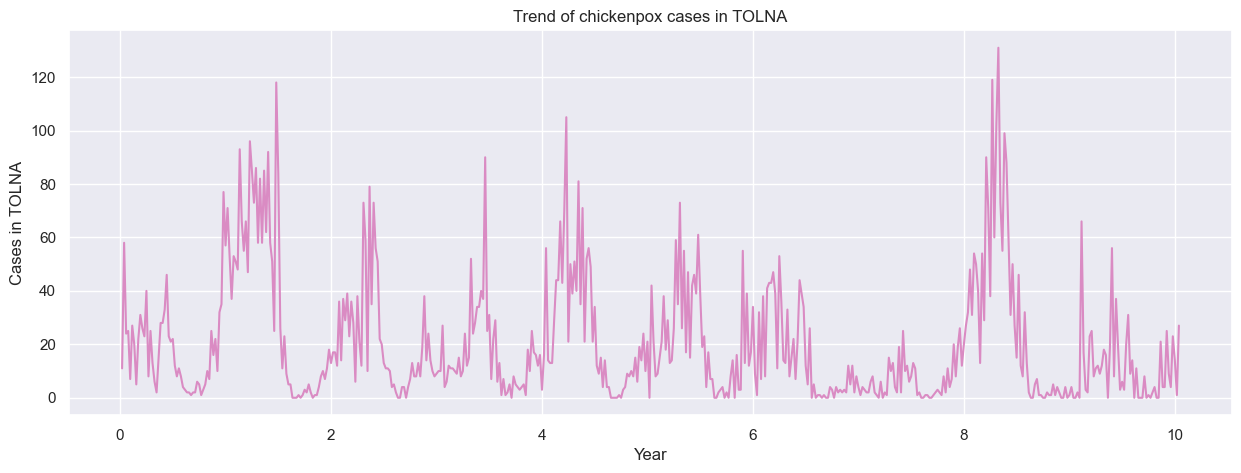

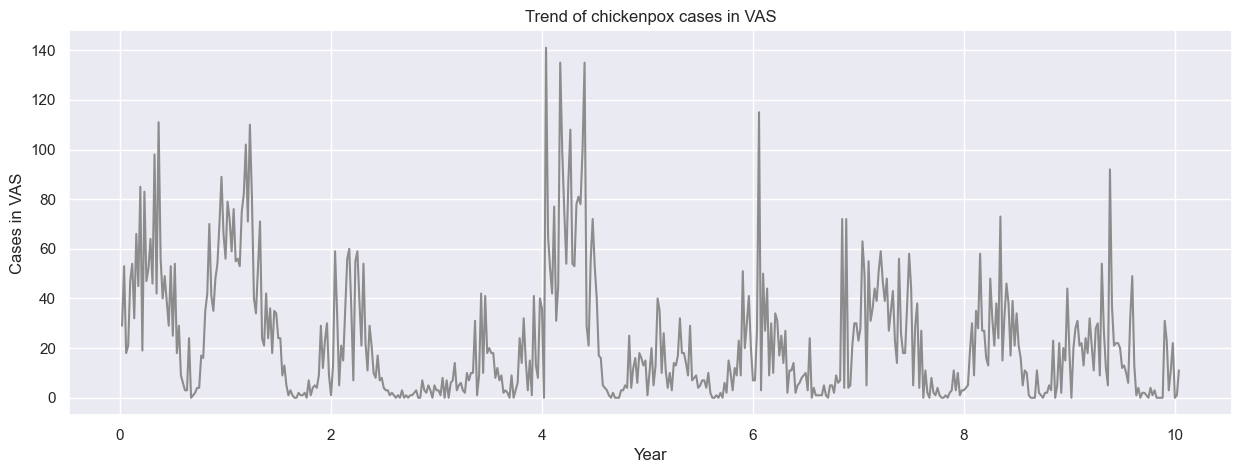

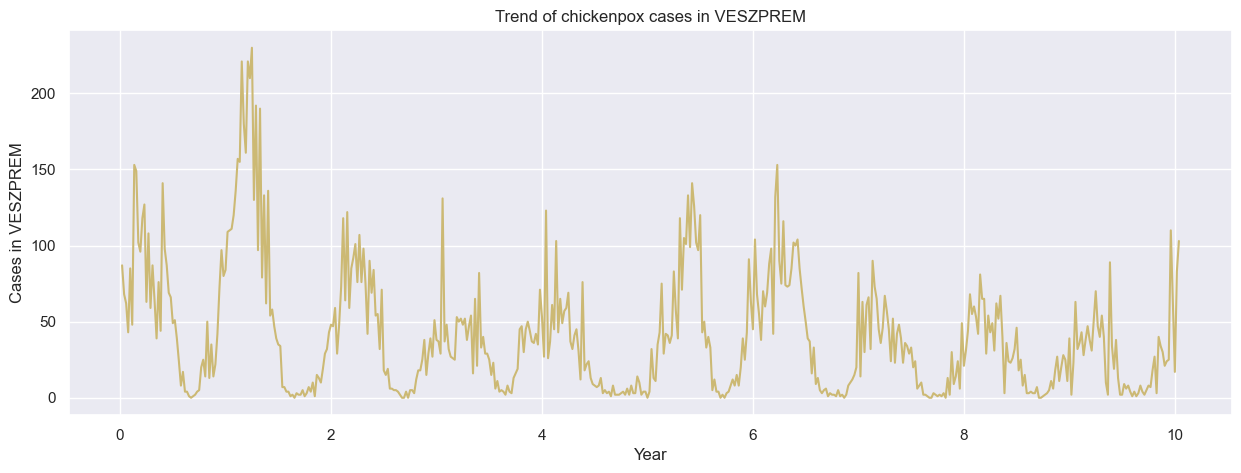

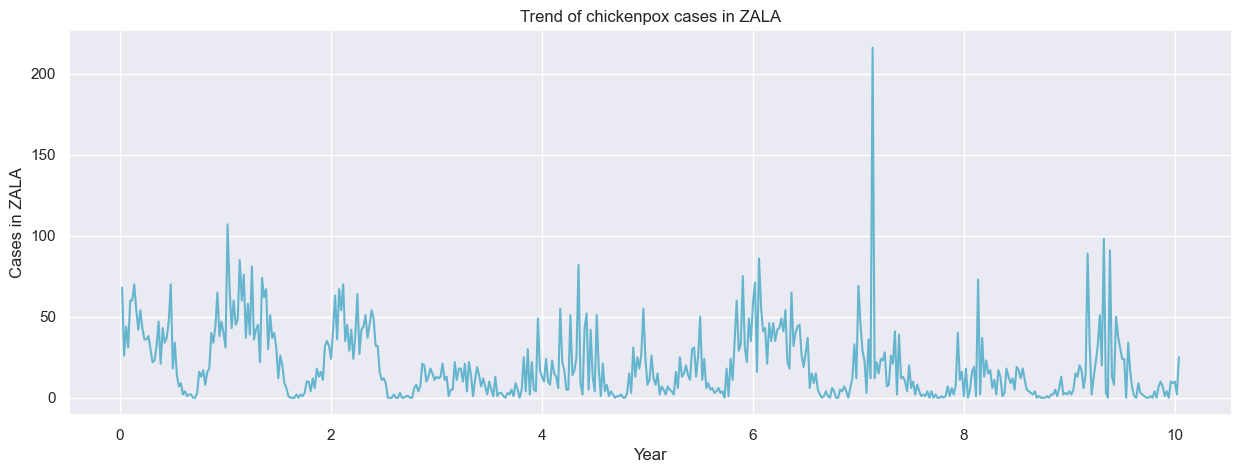

In [49]:
# Set the figure size
sns.set(rc={'figure.figsize': (15, 5)})

# Get a palette with more colors
palette = sns.color_palette("deep", len(county_list))

# Create line plots with different colors
for i, county in enumerate(county_list):
    sns.lineplot(y=df[county].to_list(), x=(df['Week'] / 52).to_list(), color=palette[i])

    # Set labels and title
    plt.xlabel("Year")
    plt.ylabel(f"Cases in {county}")

    plt.title(f"Trend of chickenpox cases in {county}")

    # Display the plot
    plt.show()

Polynomial Regression:

MinMax Scaler, no log

In [50]:
x = df['Week'].values.reshape(-1, 1) # extracting week to be the input variable x
y_df = df[county_list] # each county to be a separate y variable

In [51]:
x_scaled_min = scaler_min.fit_transform(x) # normalizing the x variable (y will be normalised later [each county separately])
x_scaled_pow = scaler_pow.fit_transform(x)

In [52]:
# Split the x dataset into train and test sets
x_train_min, x_test_min = train_test_split(x_scaled_min, test_size=0.2, random_state=101)
x_train_pow, x_test_pow = train_test_split(x_scaled_pow, test_size=0.2, random_state=101)

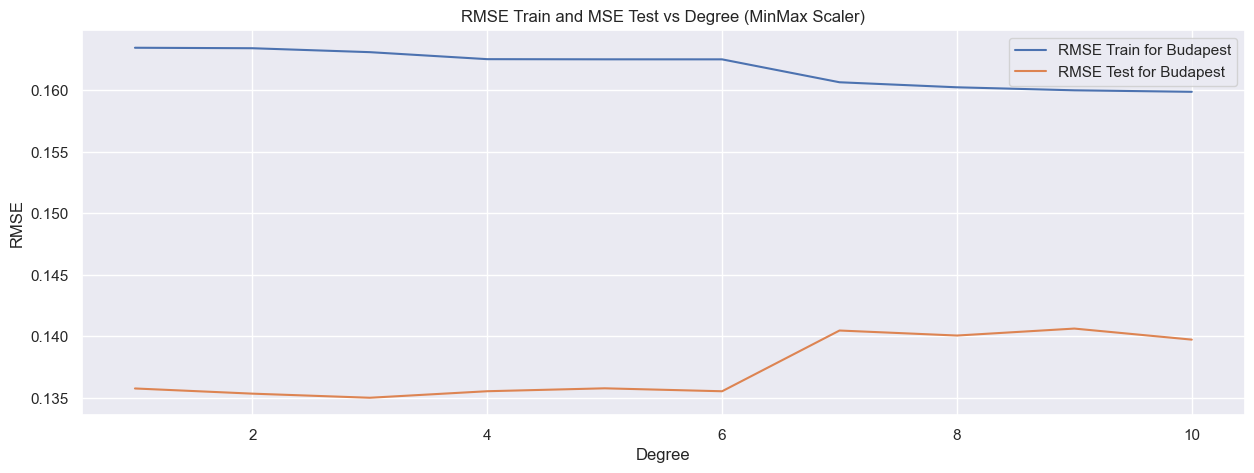

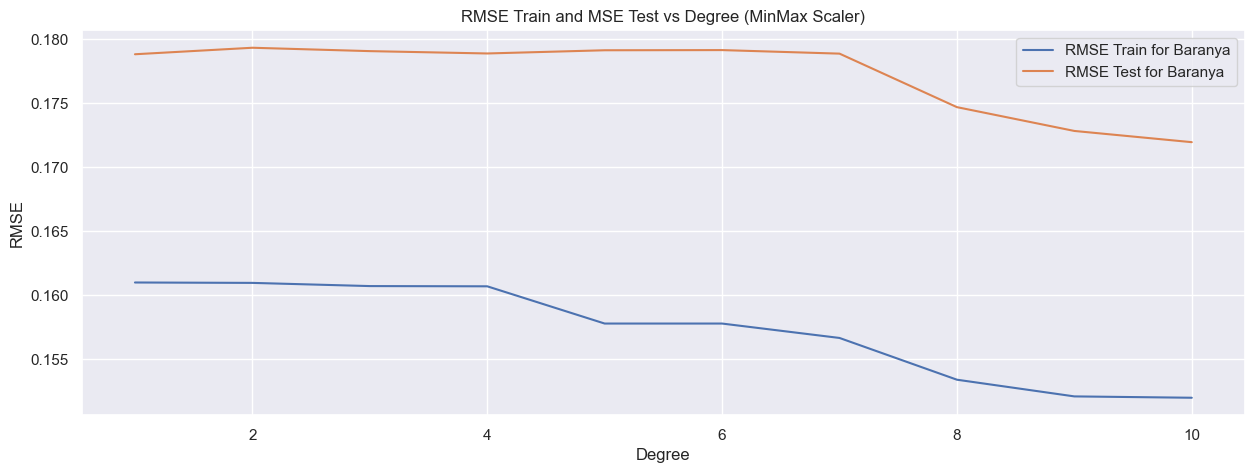

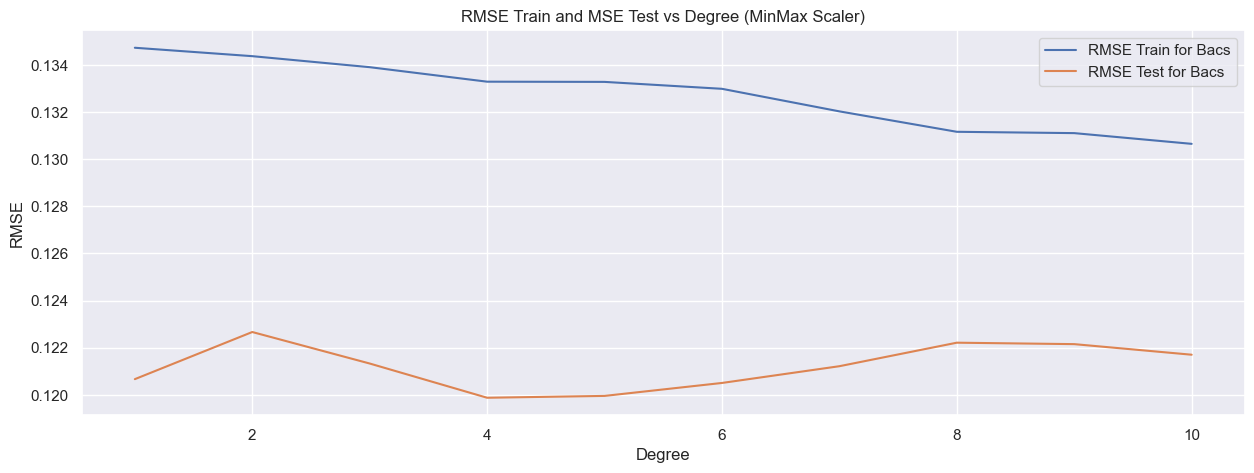

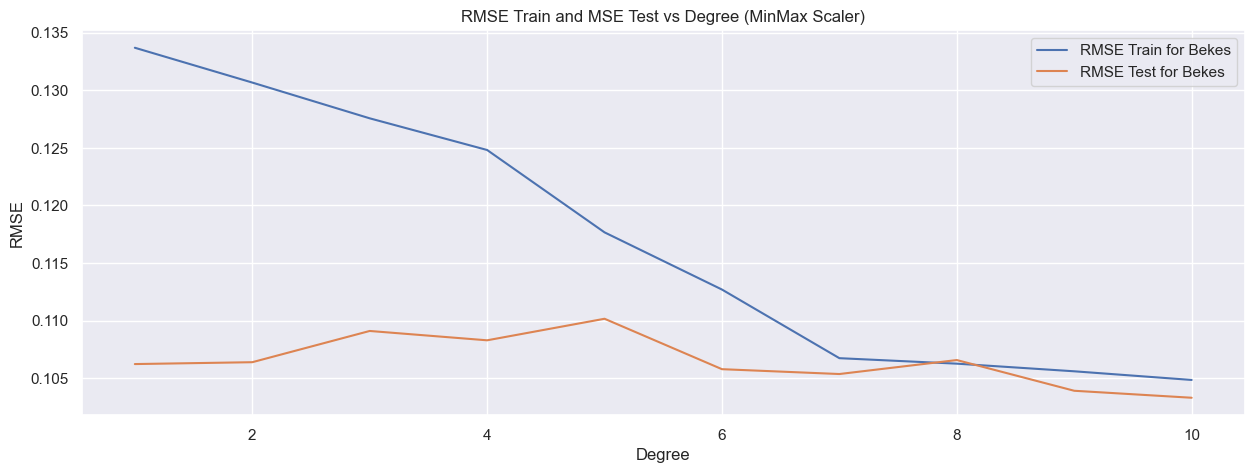

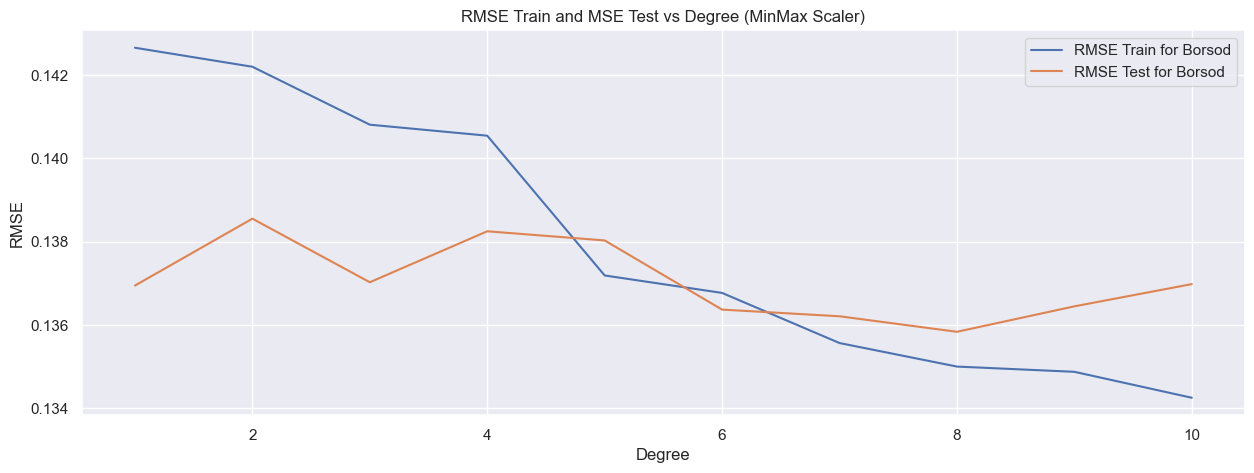

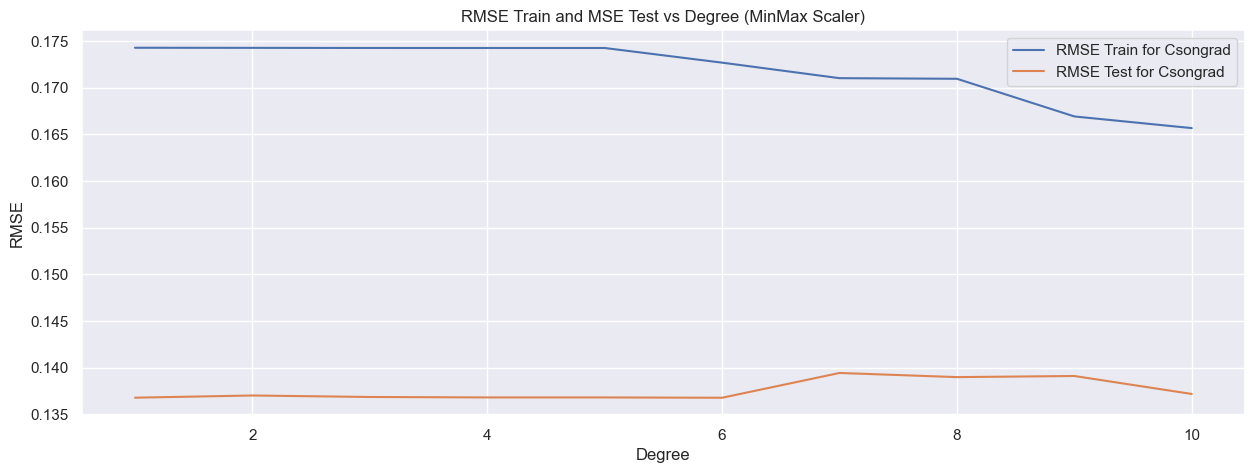

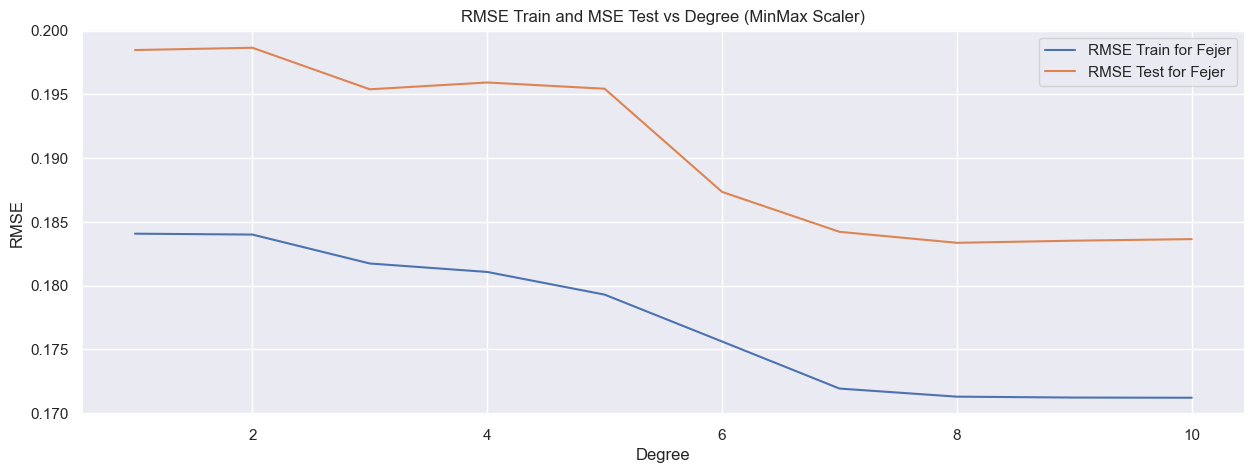

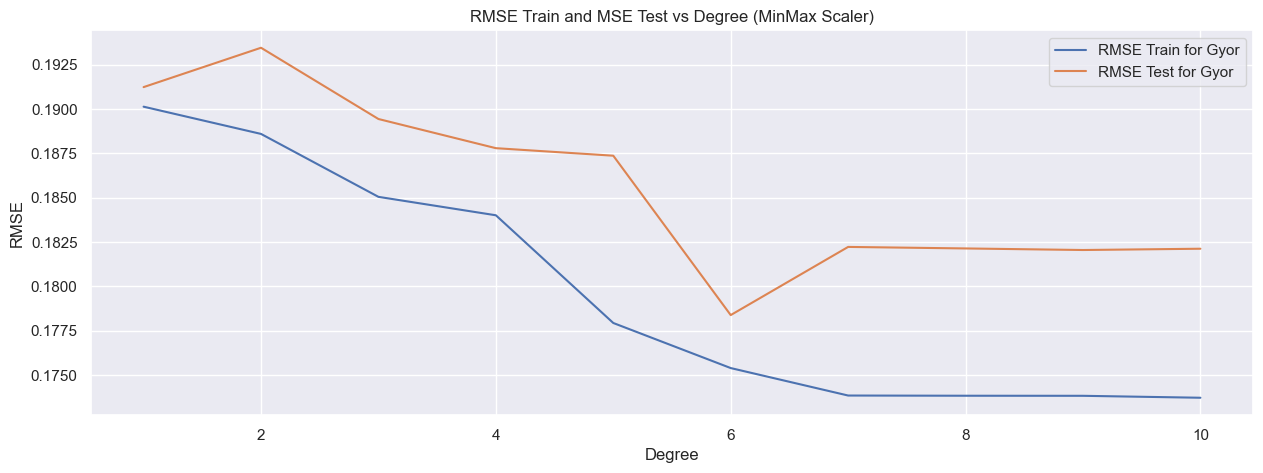

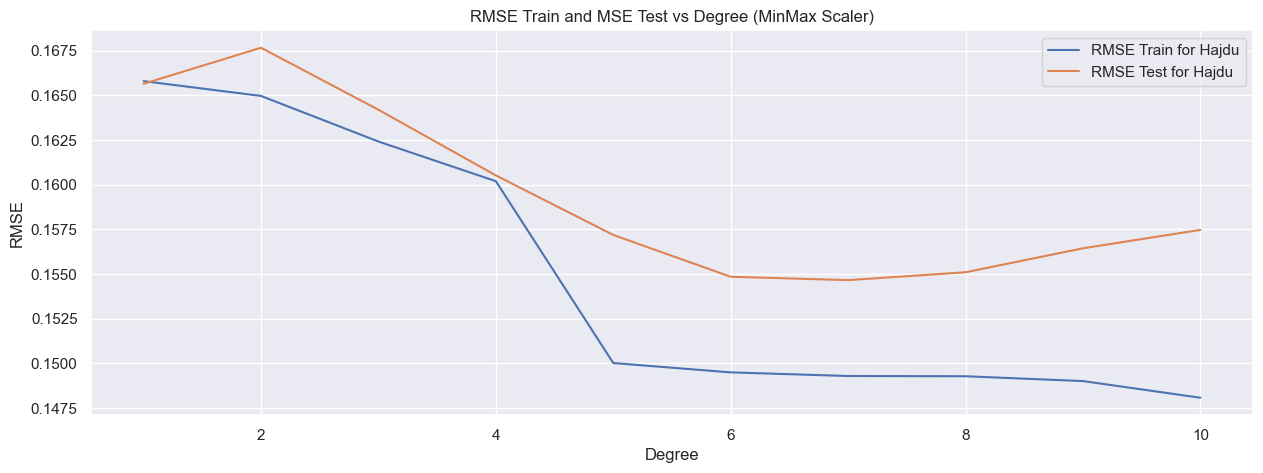

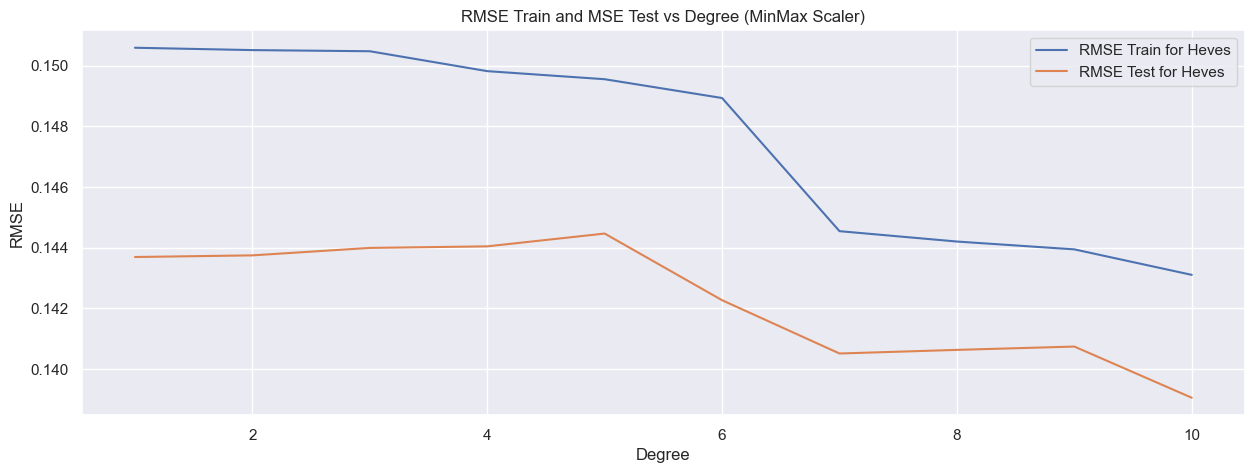

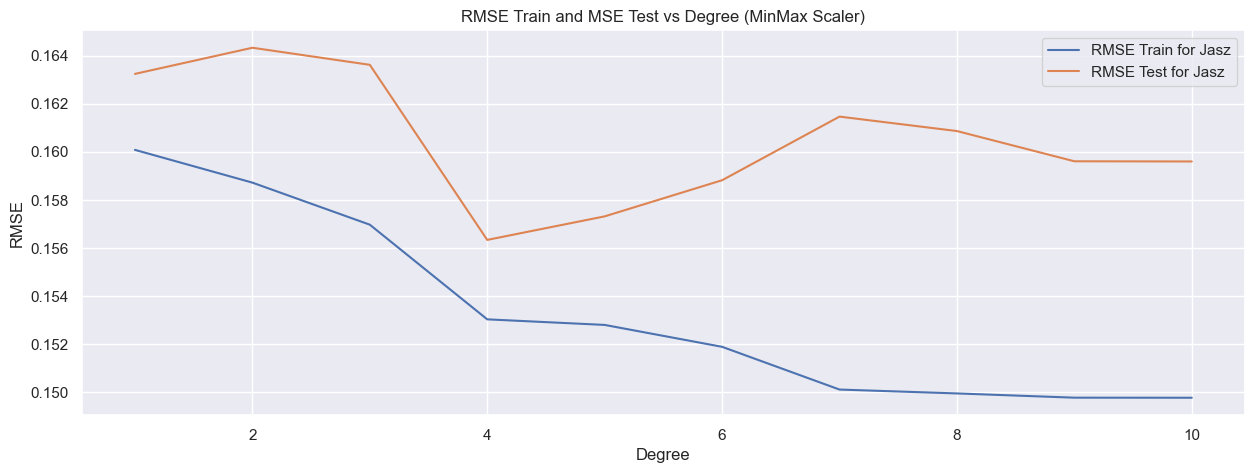

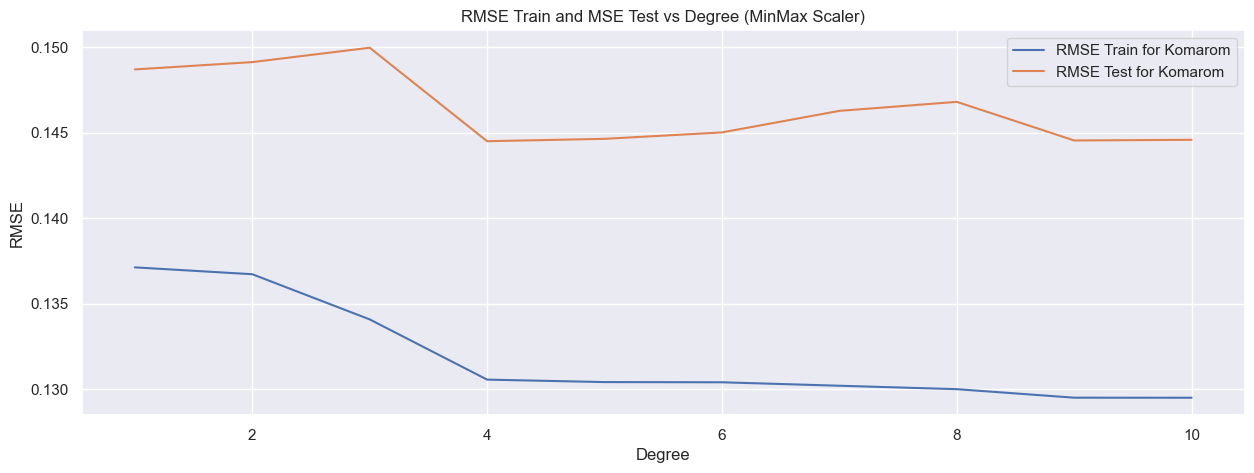

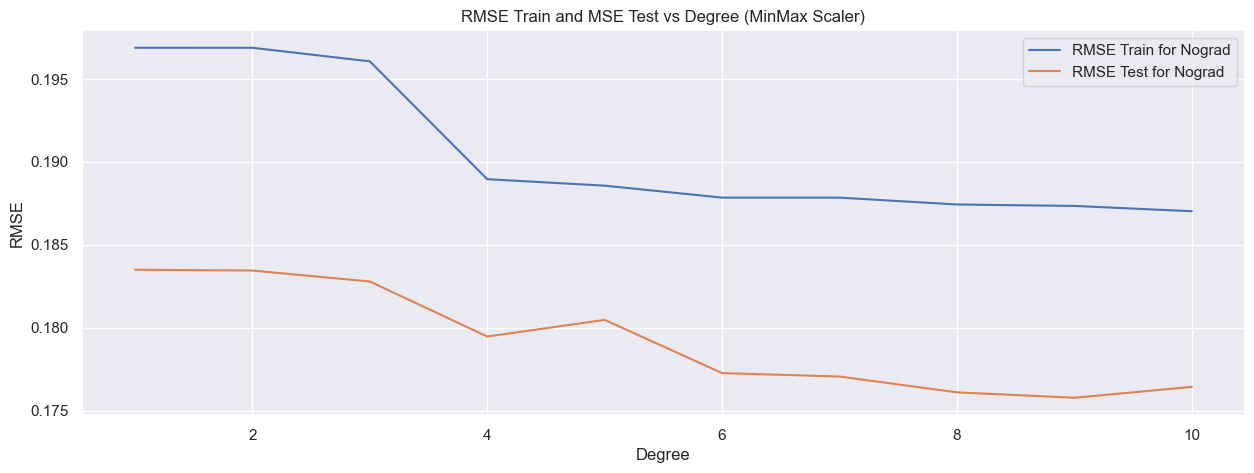

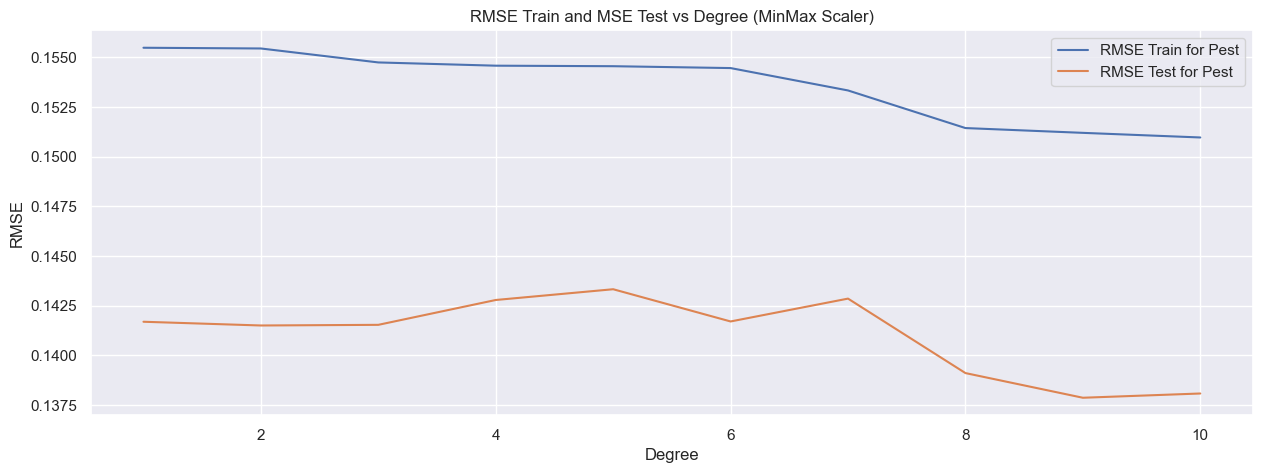

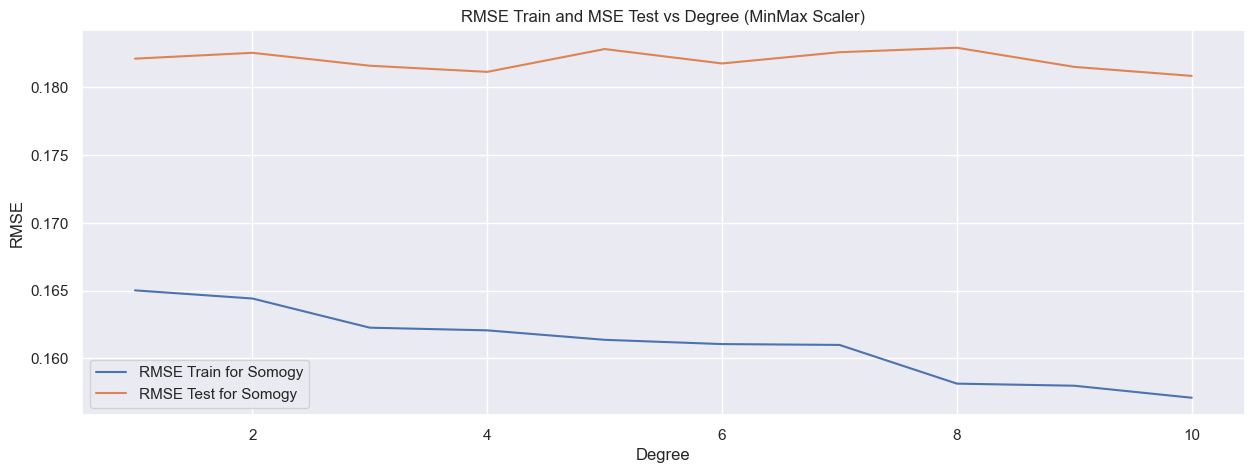

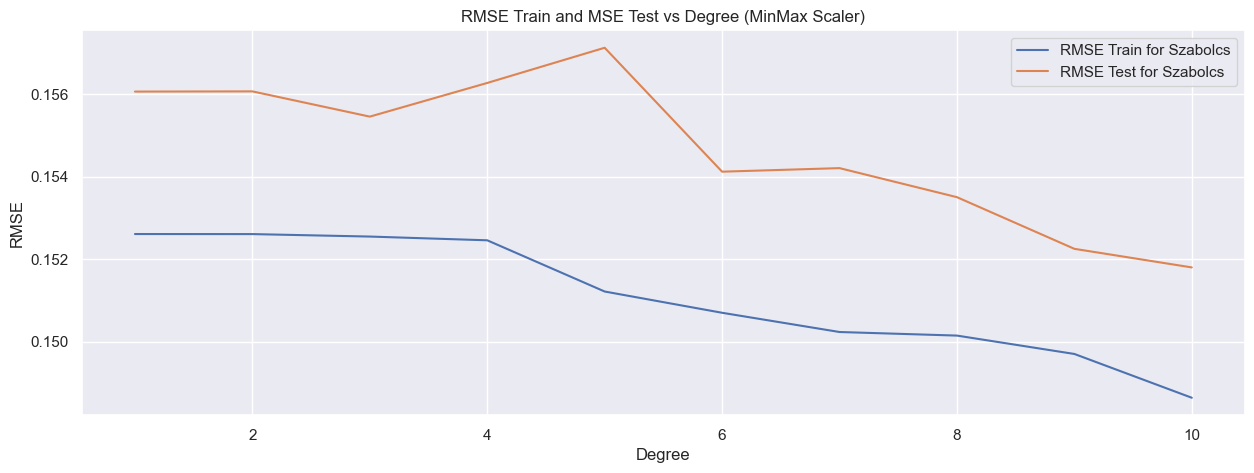

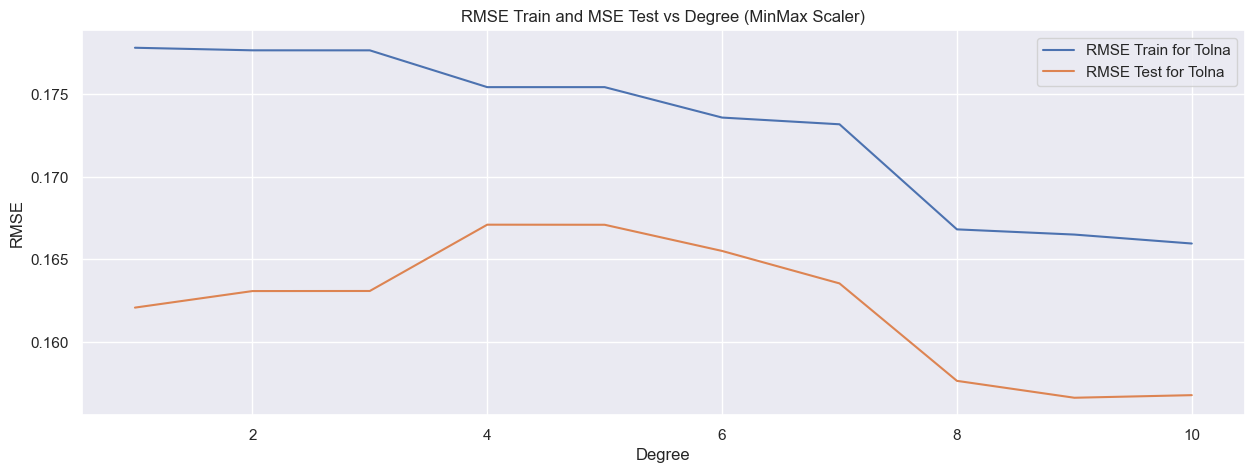

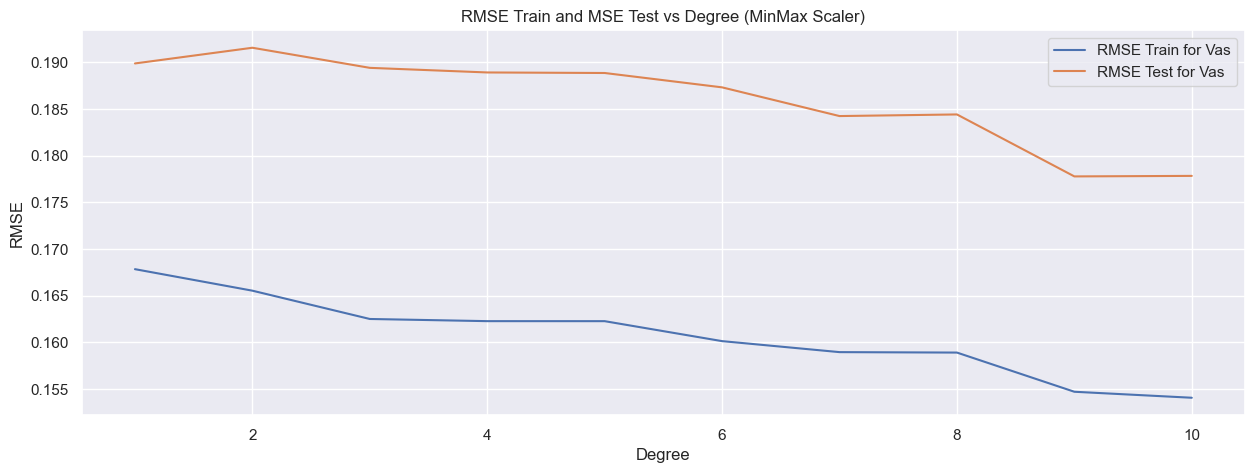

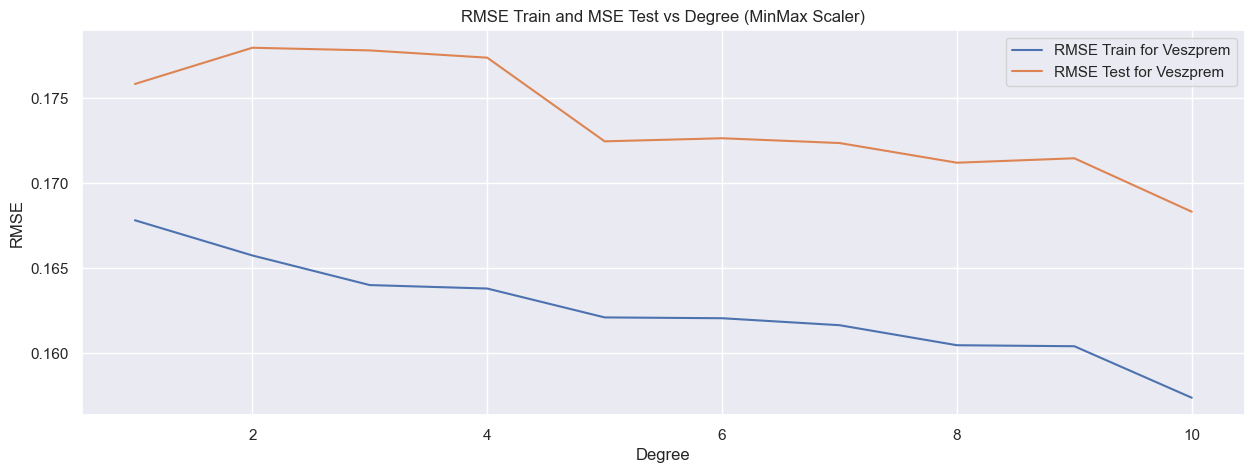

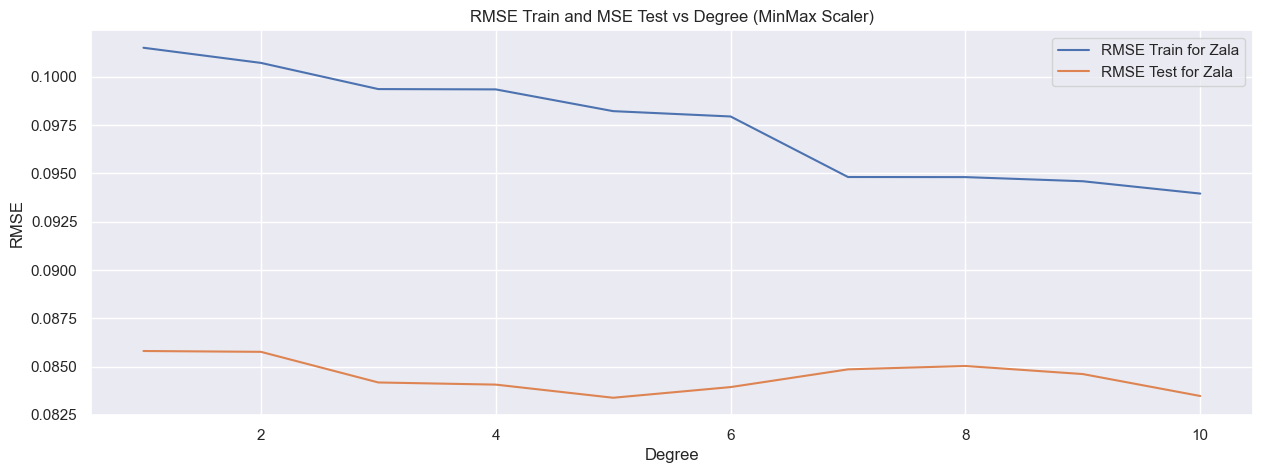

In [53]:
degrees = range(1, 11)
rmse_test_min = []
rmse_train_min = []

best_degrees_min = []

for county in county_list:

    rmse_test_county_min = []
    rmse_train_county_min = []
    
    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_min = scaler_min.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min, y_test_min = train_test_split(y_scaled_min, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min)

        # Predict y values for train and test sets
        y_train_pred_min = model.predict(x_train_poly_min)
        y_test_pred_min = model.predict(x_test_poly_min)

        rmse_train_county_min.append(rmse(y_train_pred_min, y_train_min))
        rmse_test_county_min.append(rmse(y_test_pred_min, y_test_min))

    rmse_test_min.append(np.min(rmse_test_county_min))
    rmse_train_min.append(rmse_test_county_min[np.argmin(rmse_test_county_min)])
    best_degrees_min.append(np.argmin(rmse_test_county_min) + 1)


    plt.plot(degrees, rmse_train_county_min, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_min, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (MinMax Scaler)')
    plt.legend()
    plt.grid(True)
    plt.show()

MinMax scaler, log

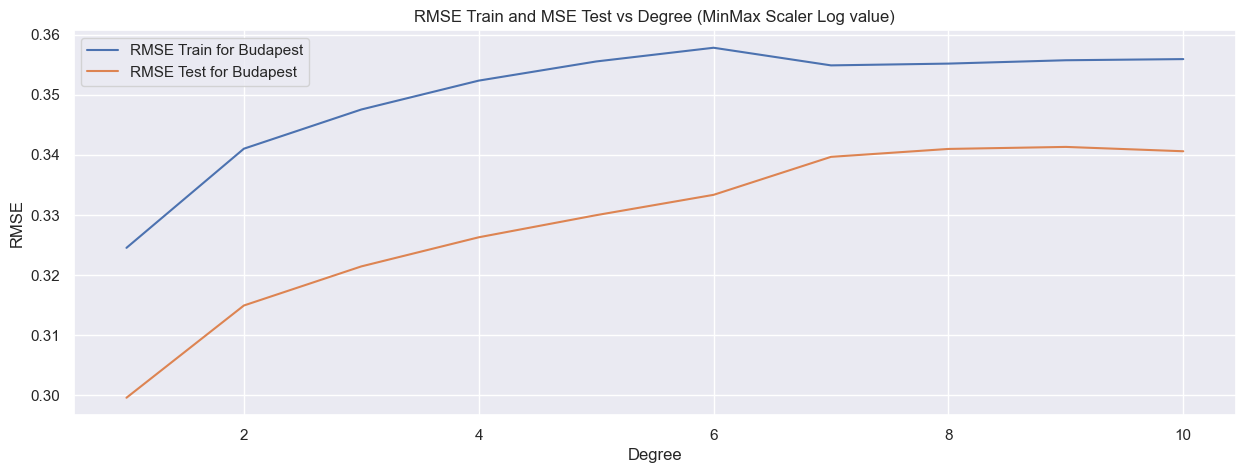

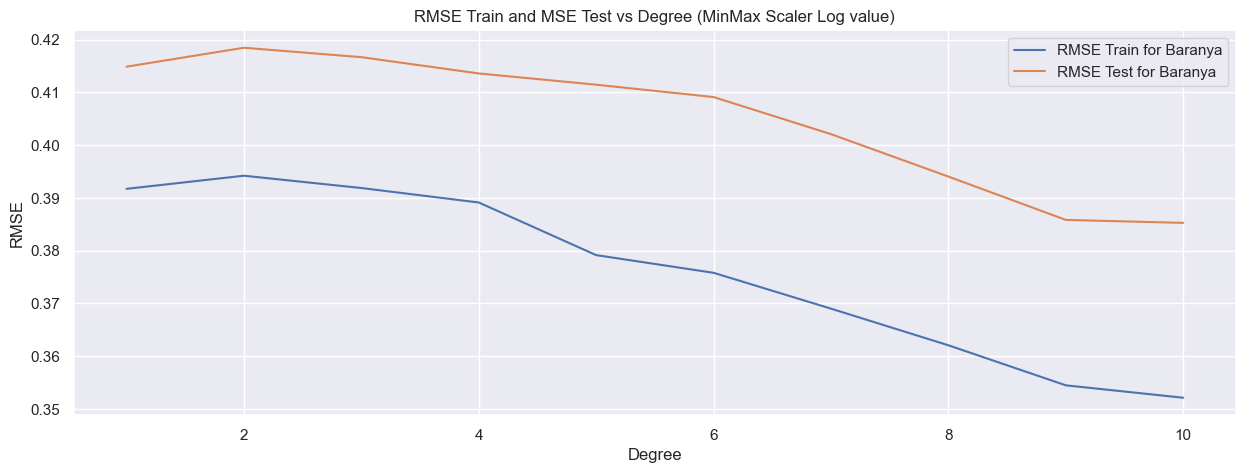

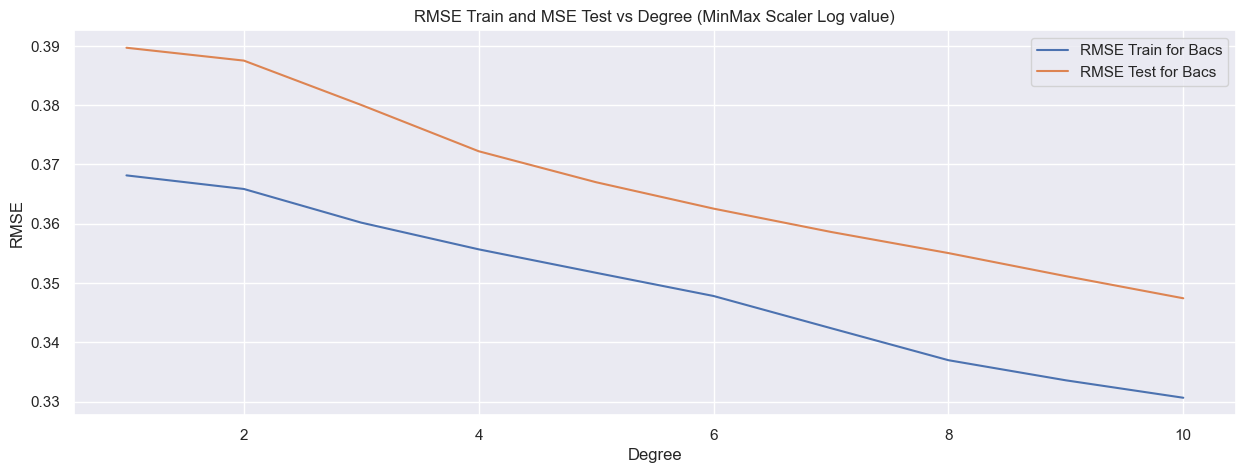

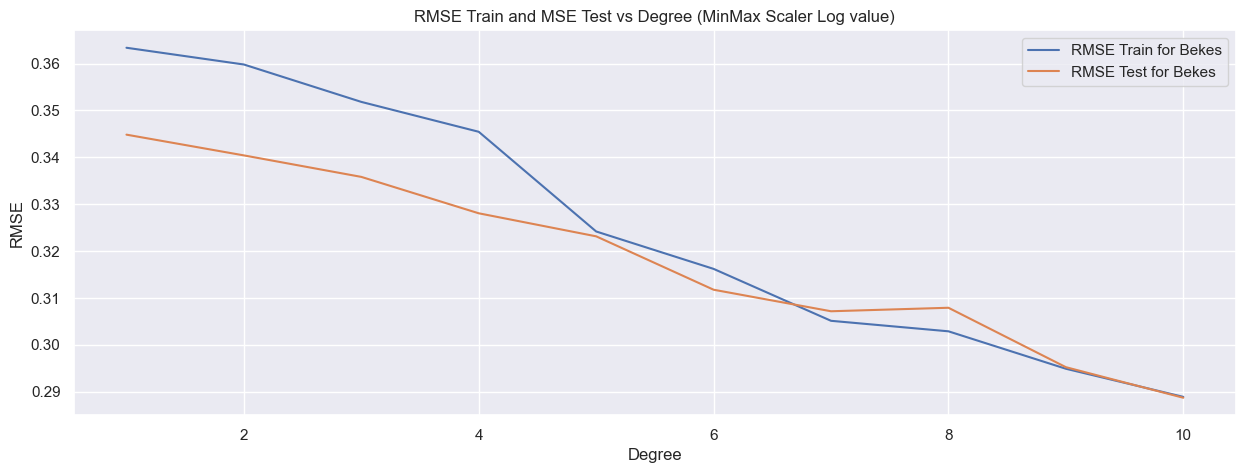

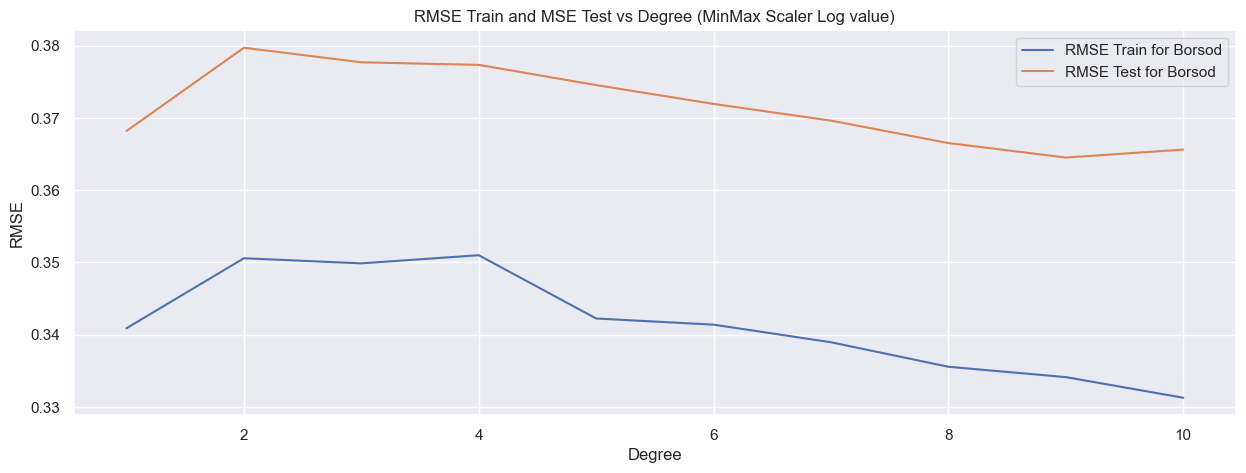

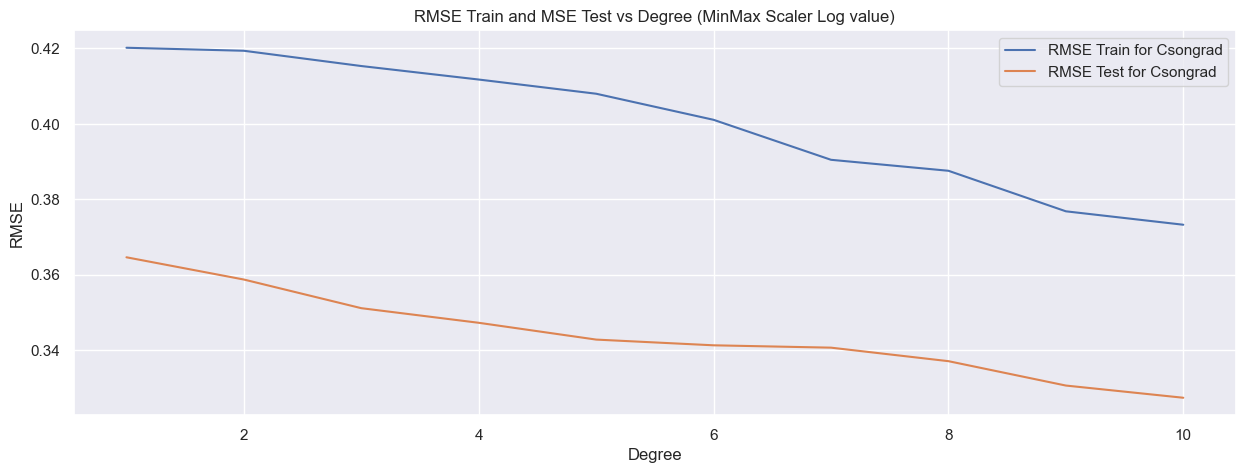

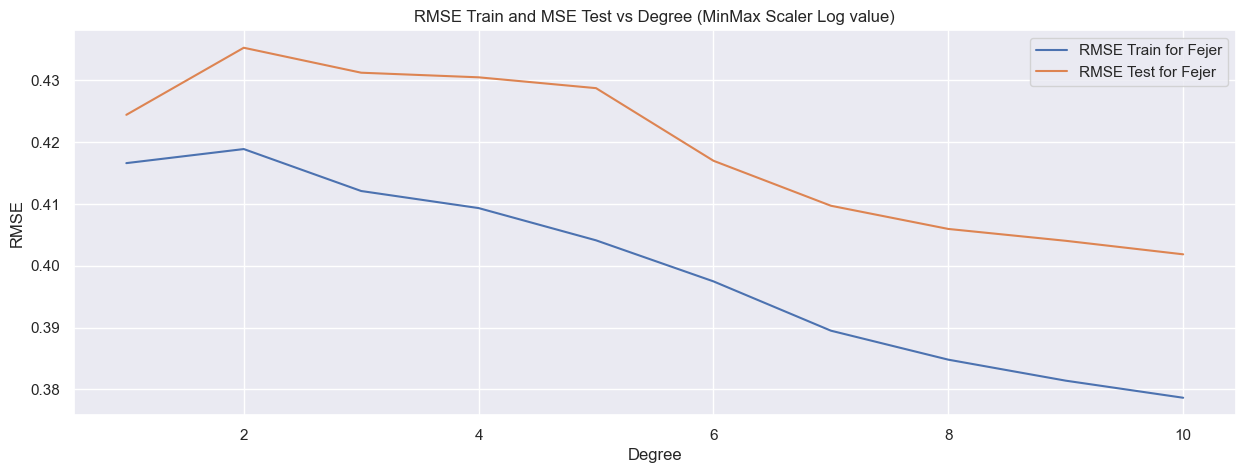

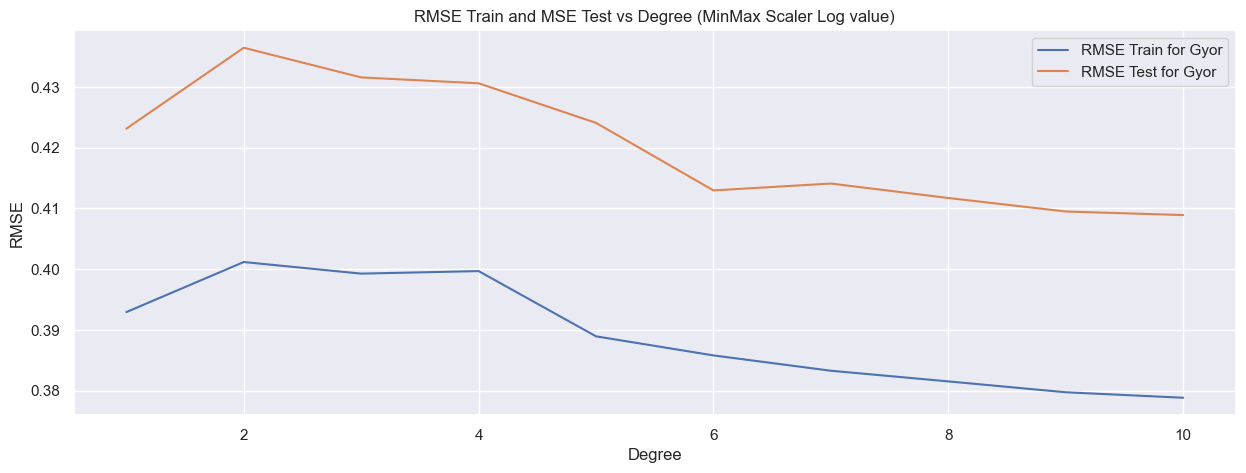

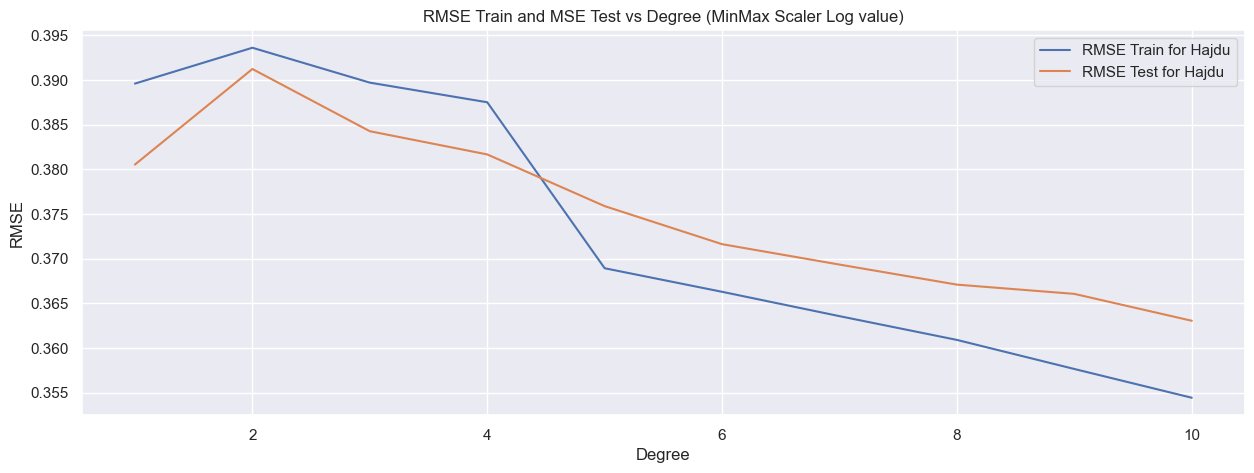

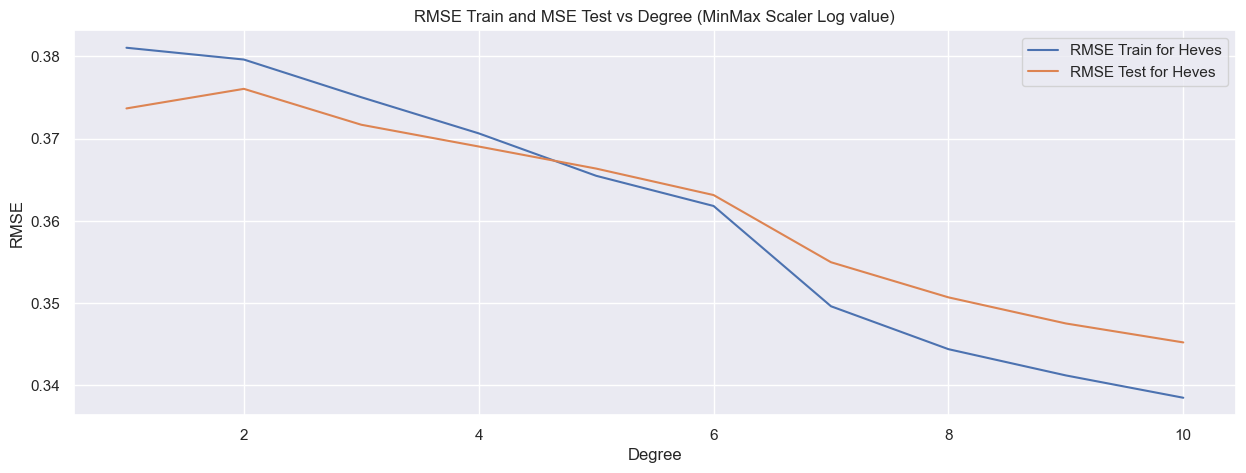

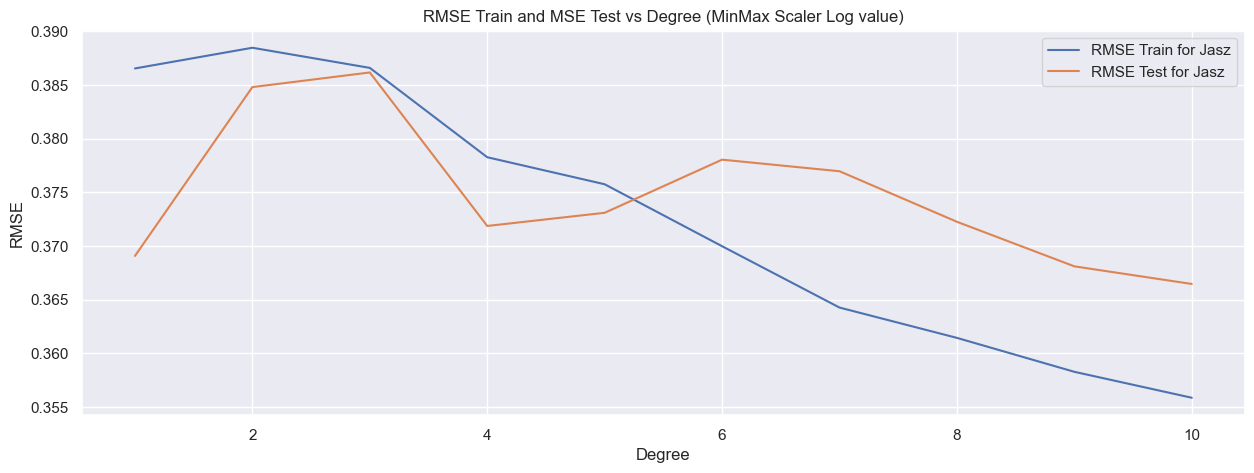

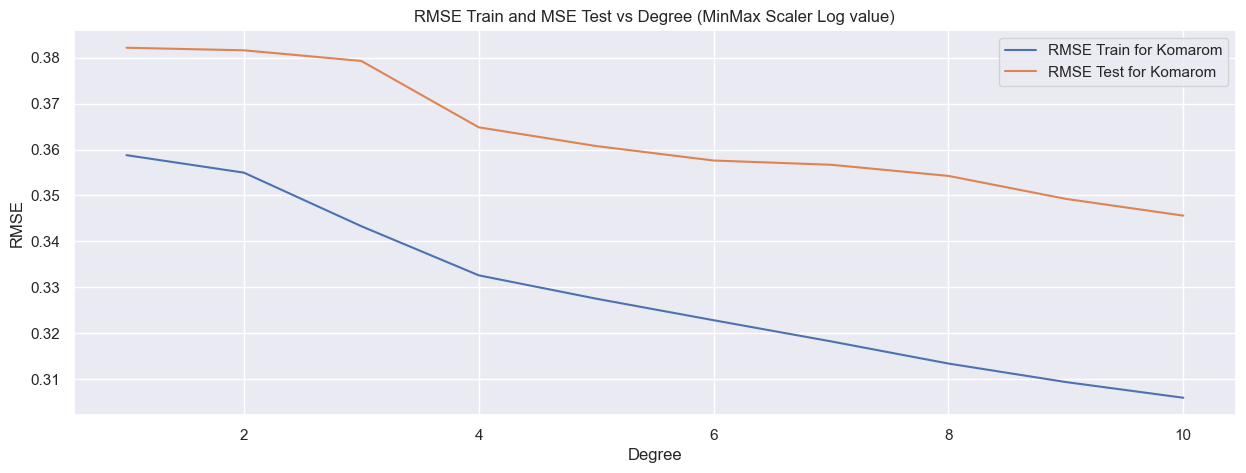

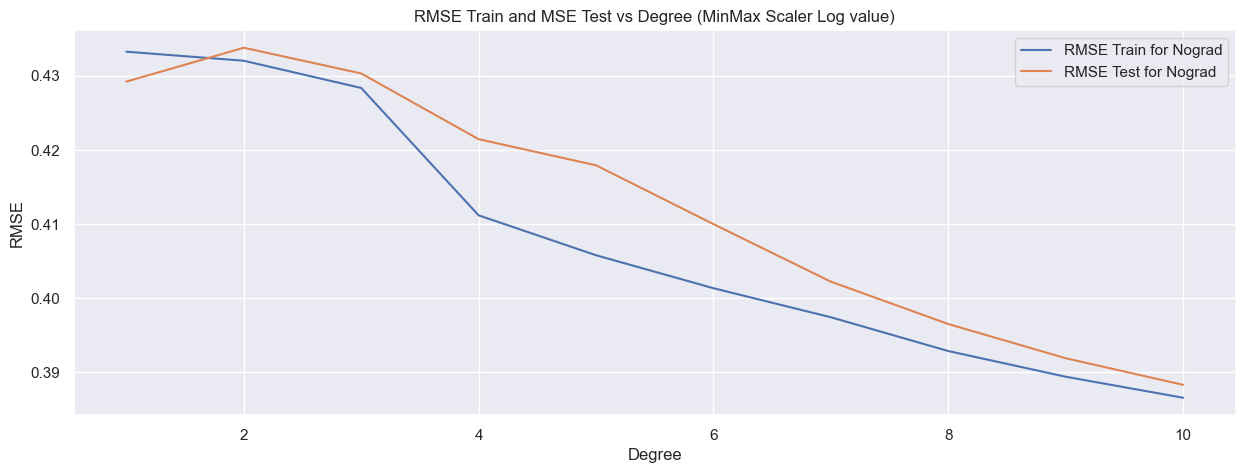

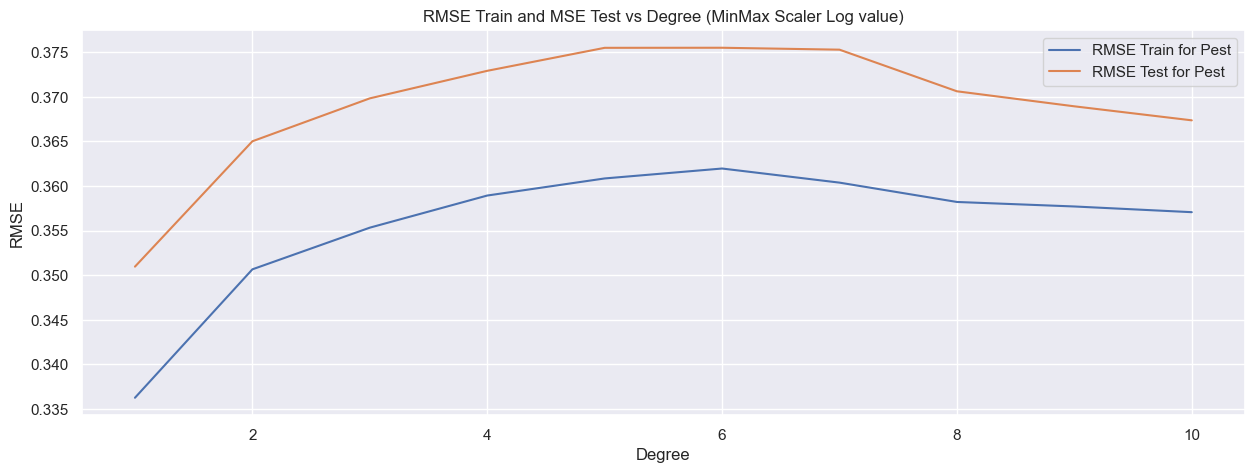

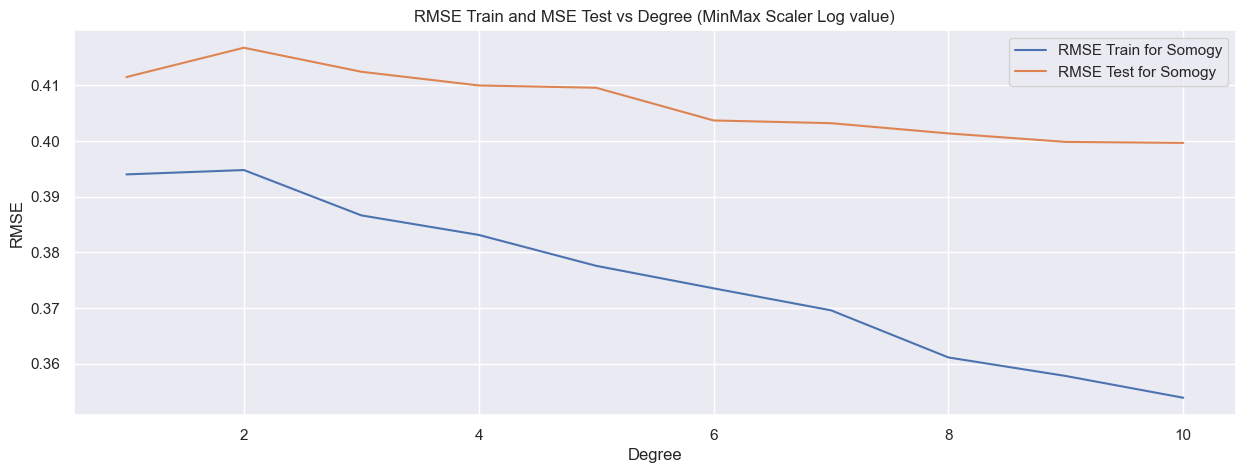

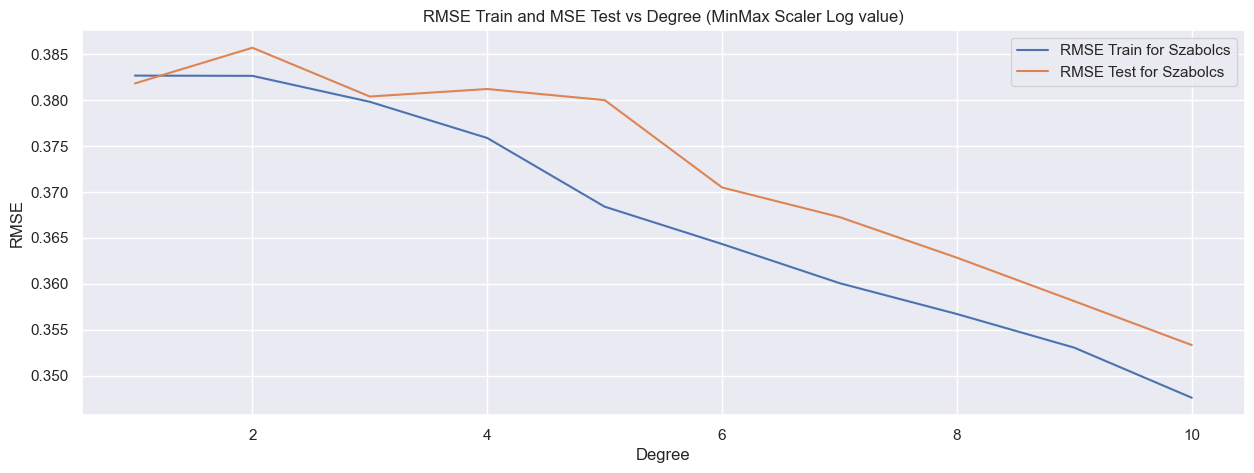

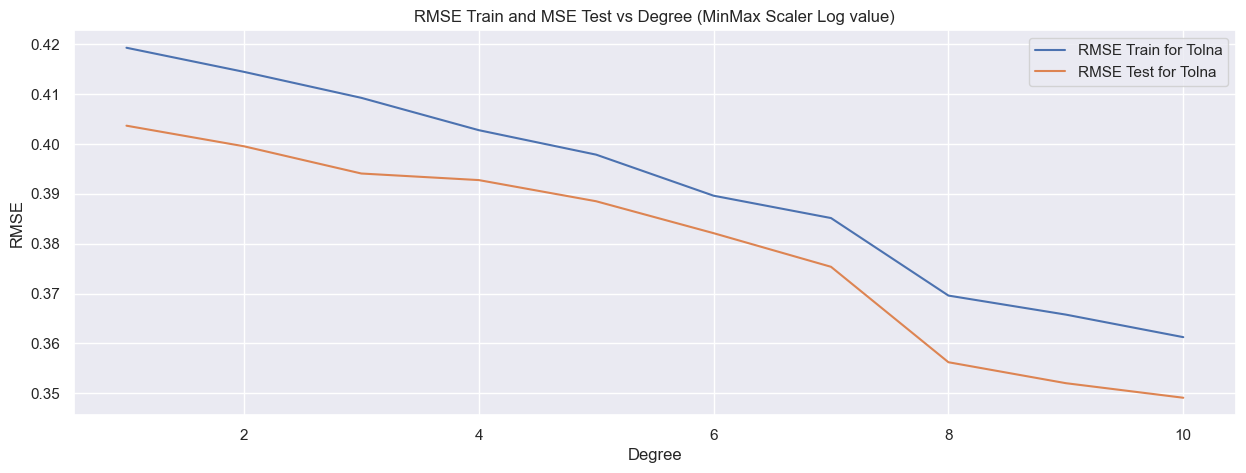

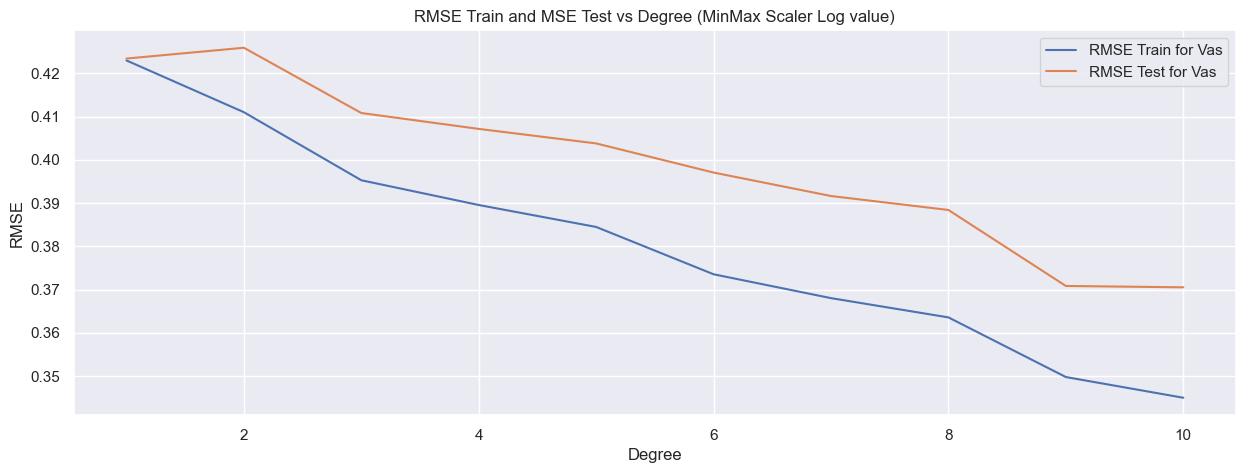

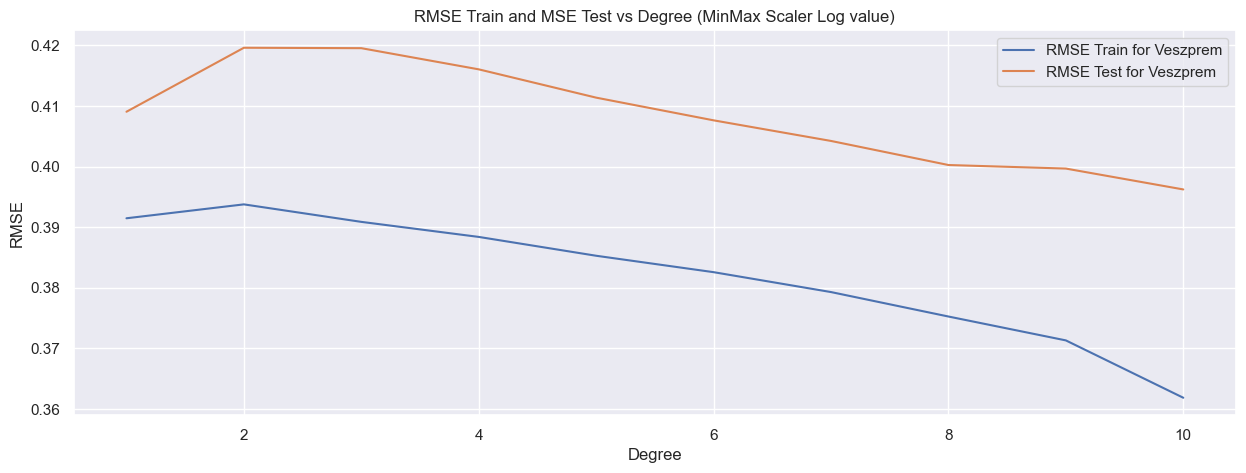

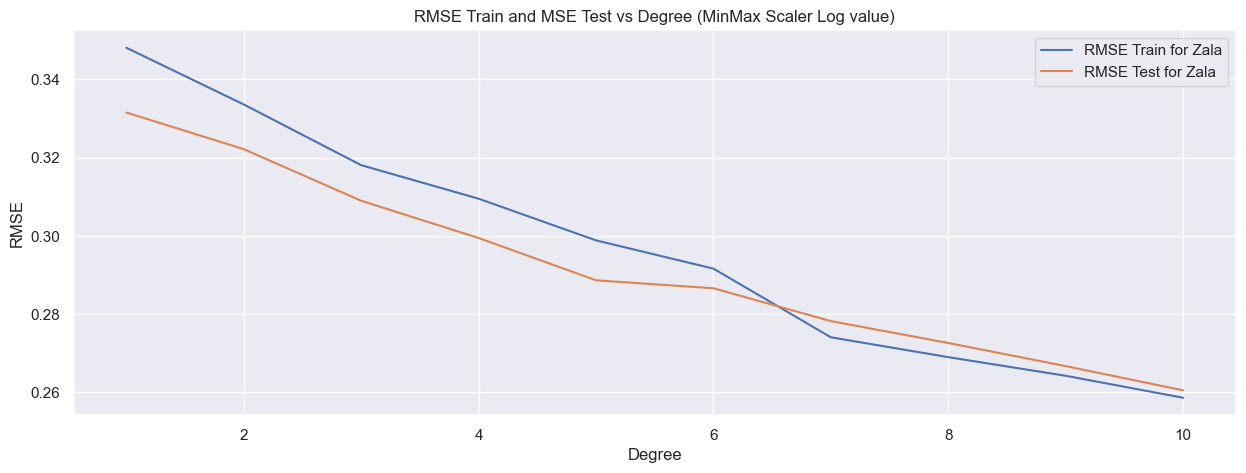

In [54]:
degrees = range(1, 11)
rmse_test_min_log = []
rmse_train_min_log = []

best_degrees_min_log = []

for county in county_list:

    rmse_test_county_min_log = []
    rmse_train_county_min_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_min_log = scaler_min.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_min_log, y_test_min_log = train_test_split(y_scaled_min_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_min = poly_features.fit_transform(x_train_min)
        x_test_poly_min = poly_features.transform(x_test_min)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_min, y_train_min_log)

        # Predict y values for train and test sets
        y_train_pred_min_log = model.predict(x_train_poly_min)
        y_test_pred_min_log = model.predict(x_test_poly_min)

        # Detransforming y_pred_min and y_test_min
        y_train_pred_min_log = np.exp(y_train_pred_min_log)
        y_test_pred_min_log = np.exp(y_test_pred_min_log)

        y_train_min_log = np.exp(y_train_min_log)
        y_test_min_log = np.exp(y_test_min_log)

        # calculating errors
        rmse_train_county_min_log.append(rmse(y_train_pred_min_log, y_train_min_log))
        rmse_test_county_min_log.append(rmse(y_test_pred_min_log, y_test_min_log))
        
    rmse_test_min_log.append(np.min(rmse_test_county_min_log))
    rmse_train_min_log.append(rmse_test_county_min_log[np.argmin(rmse_test_county_min_log)])
    best_degrees_min_log.append(np.argmin(rmse_test_county_min_log) + 1)

    plt.plot(degrees, rmse_train_county_min_log, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_min_log, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (MinMax Scaler Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


PowerTransformer, no log

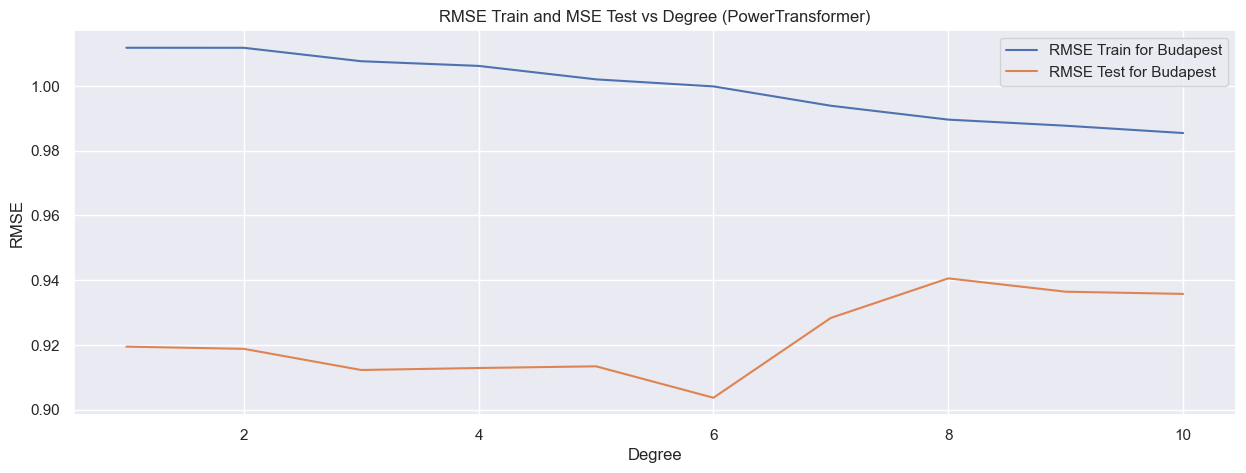

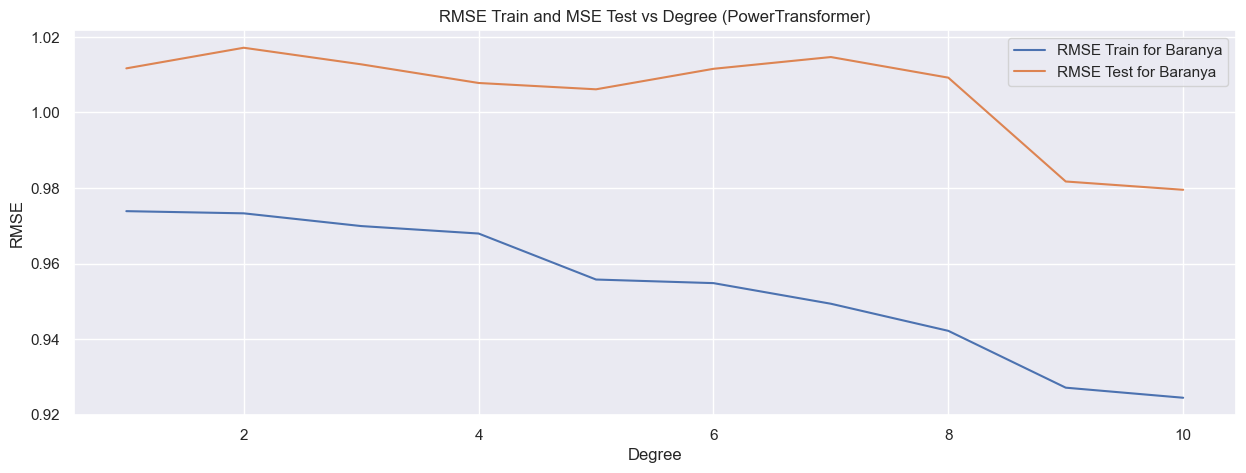

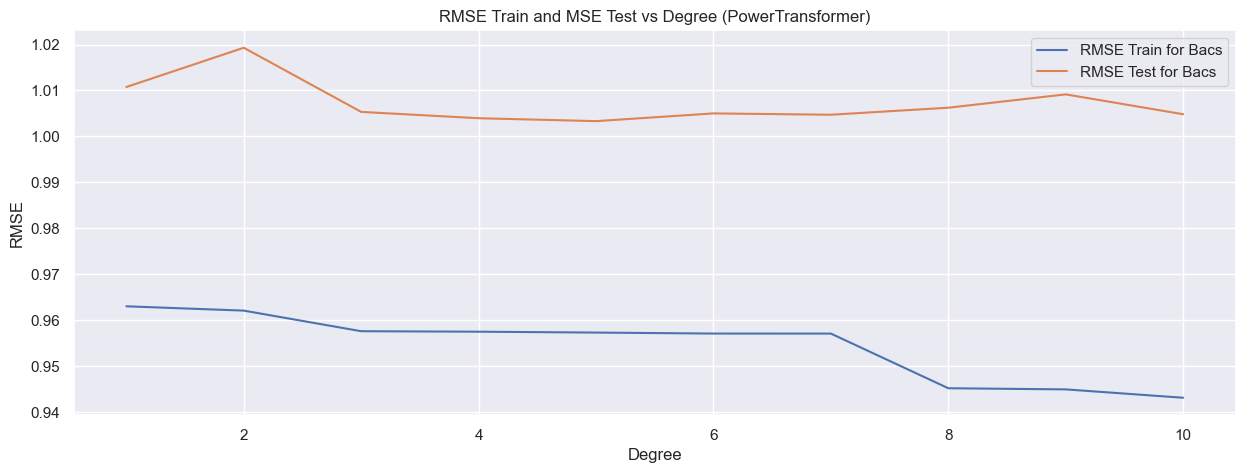

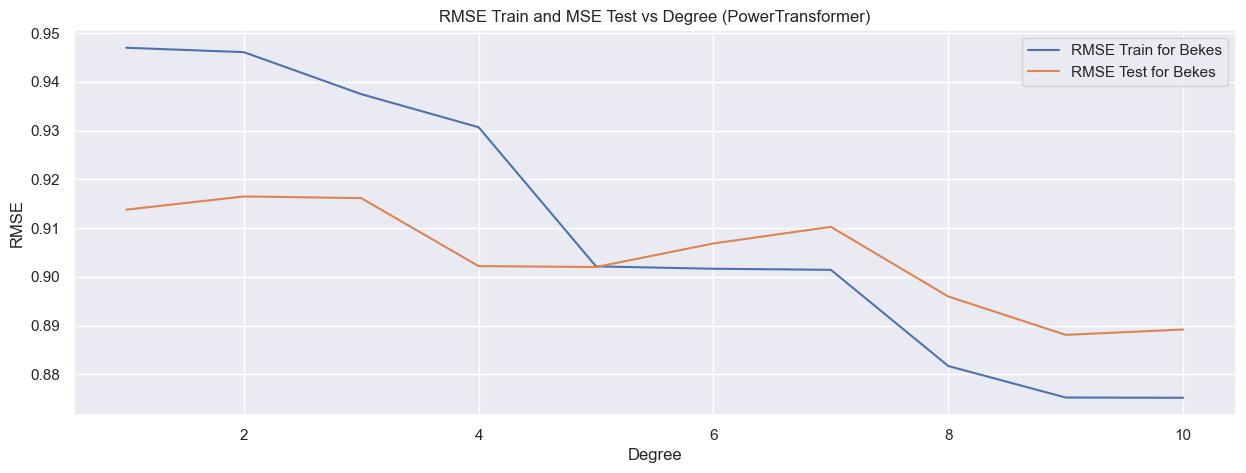

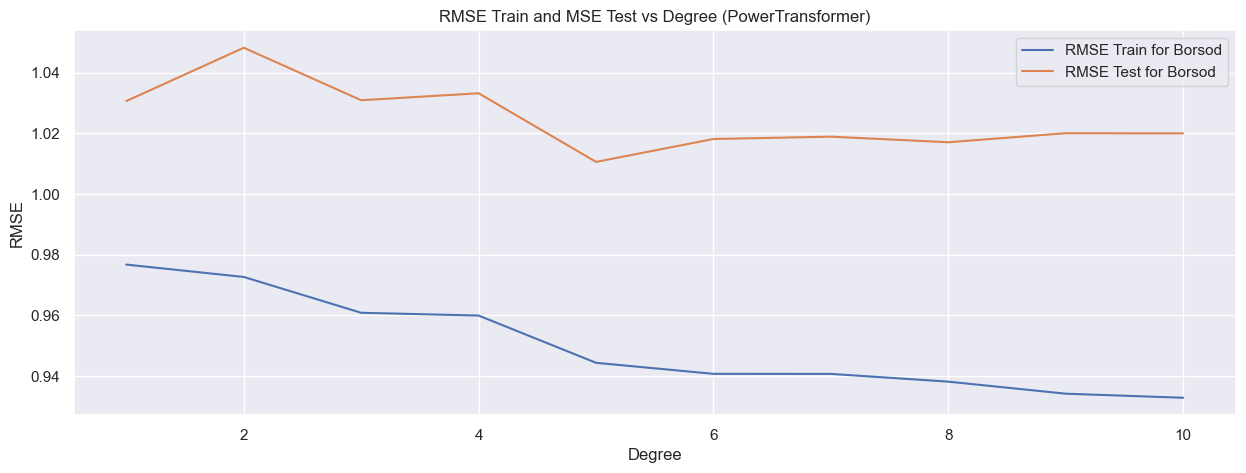

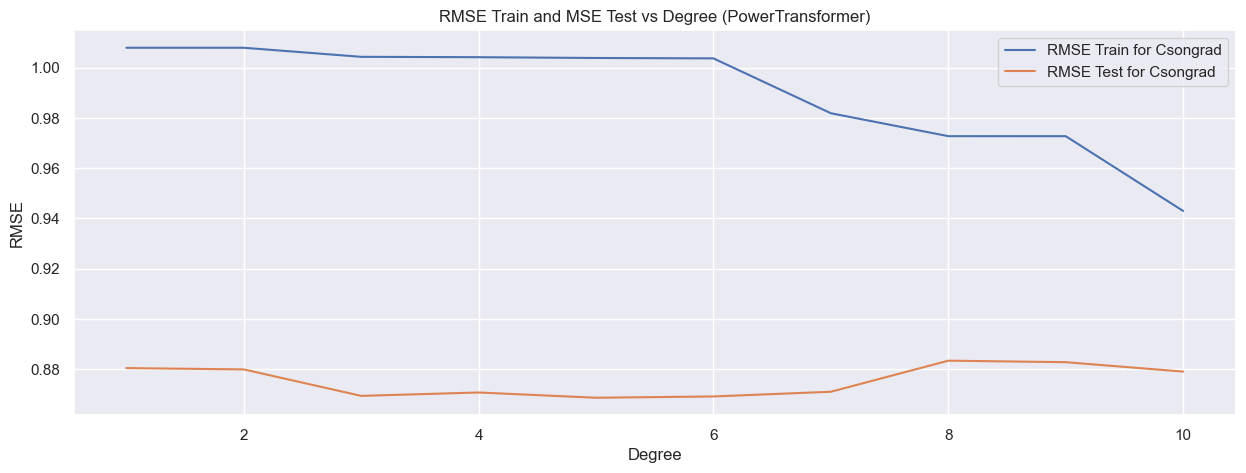

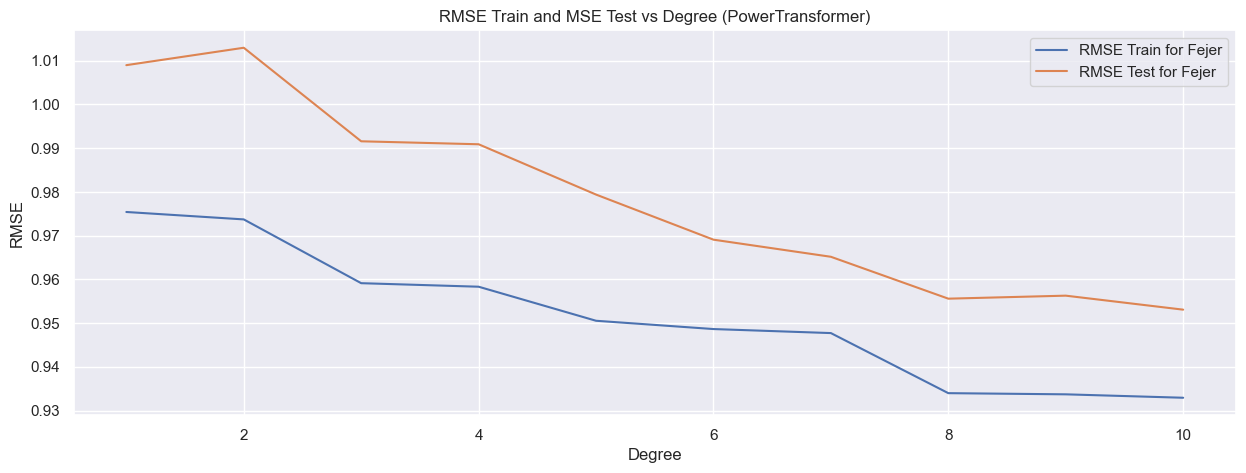

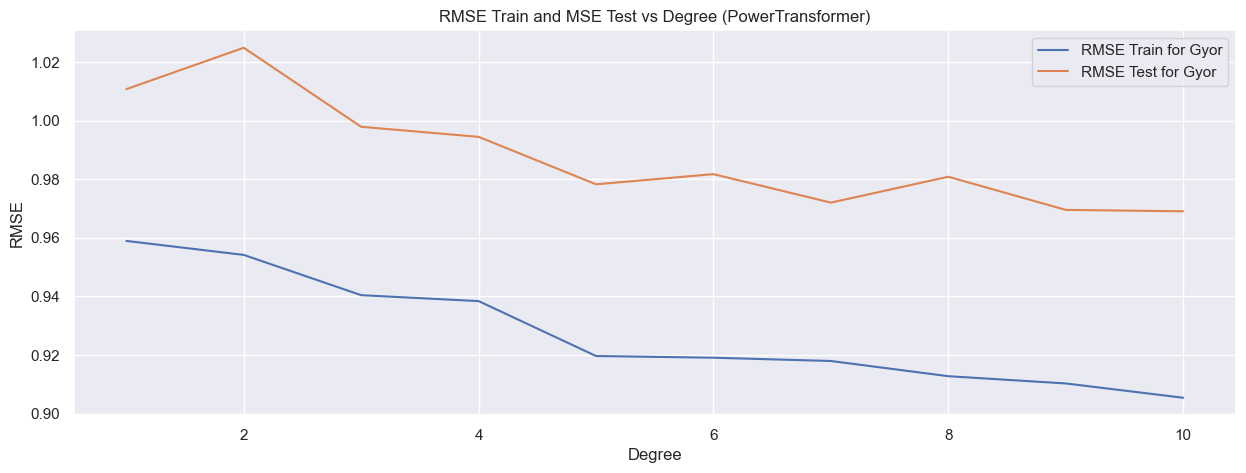

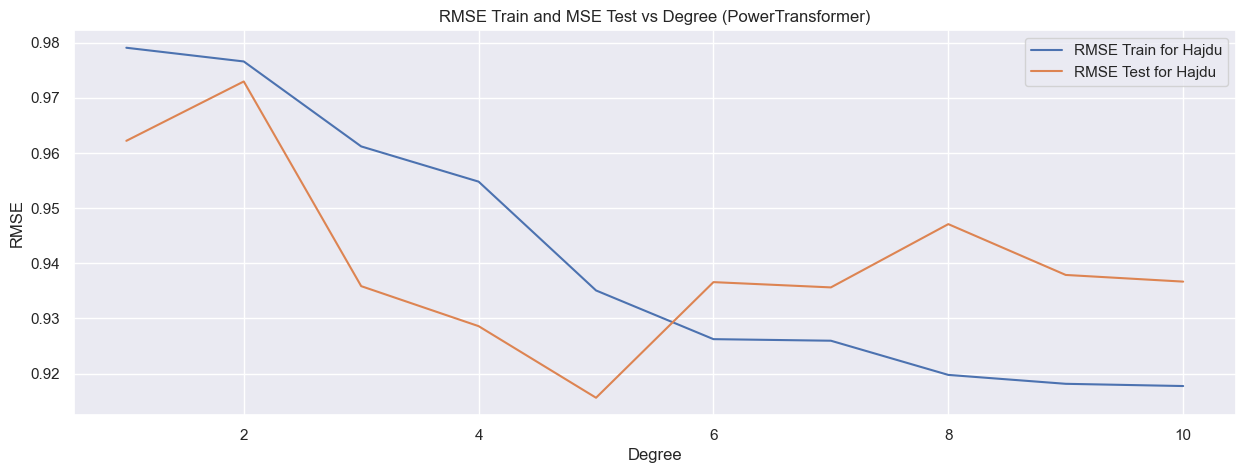

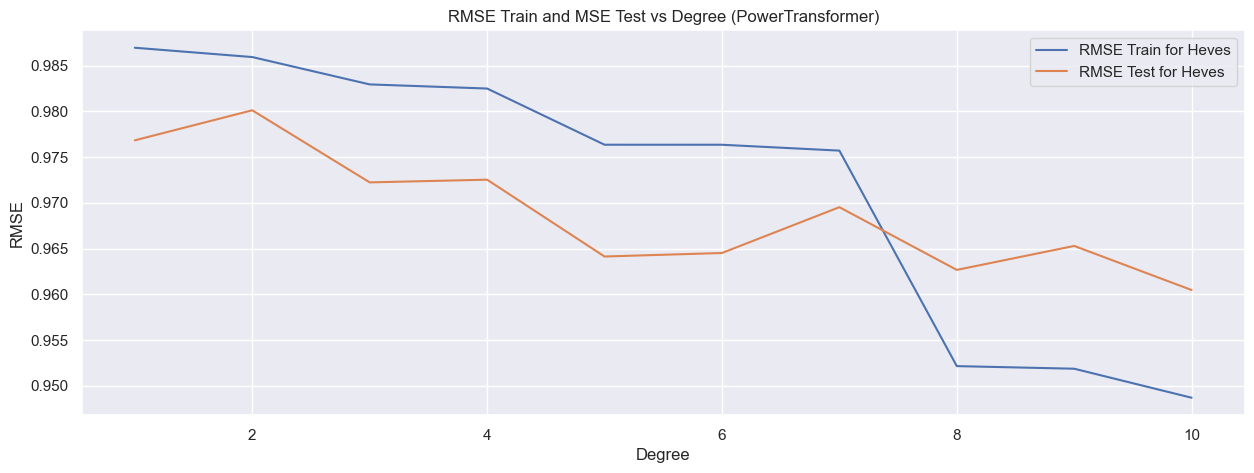

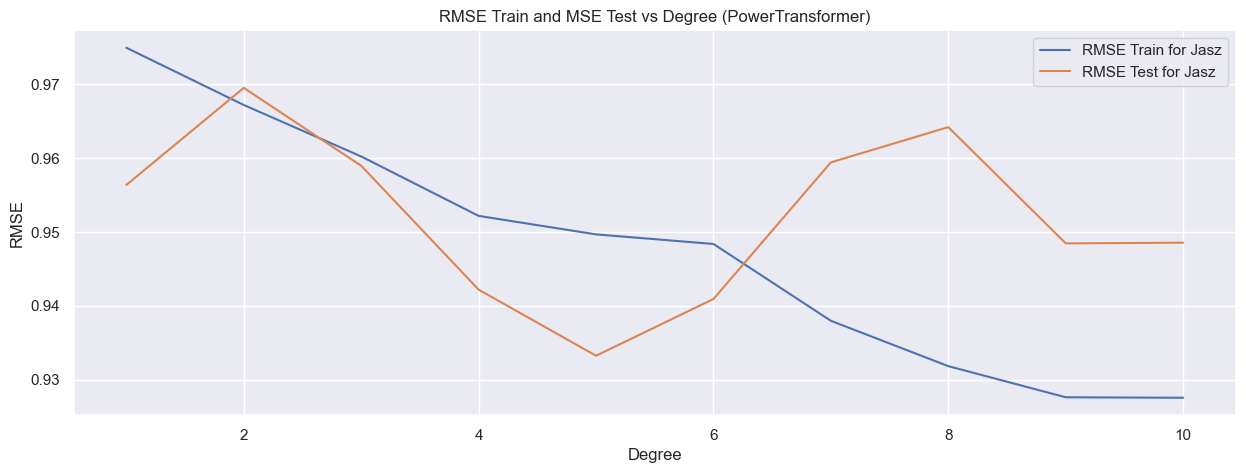

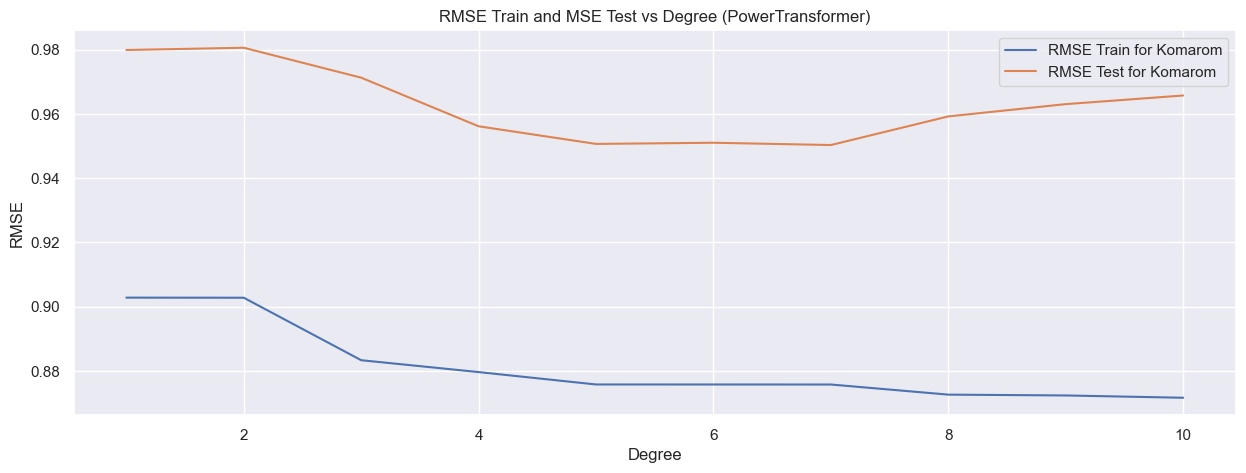

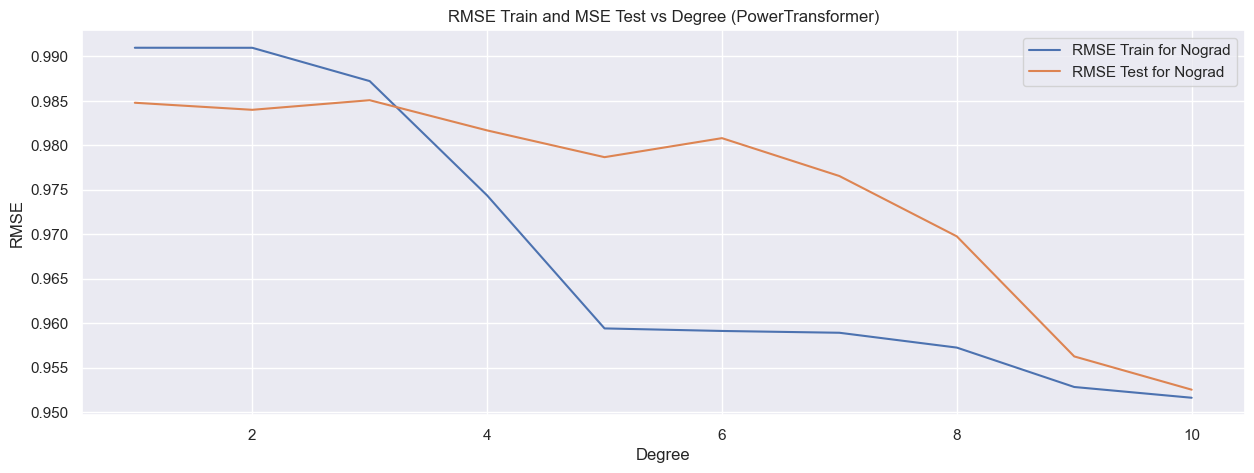

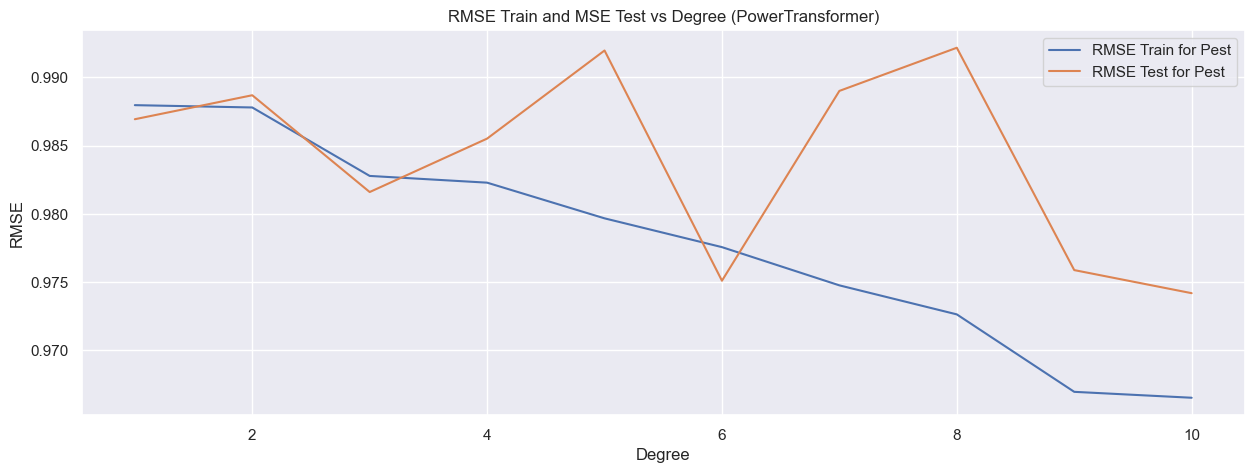

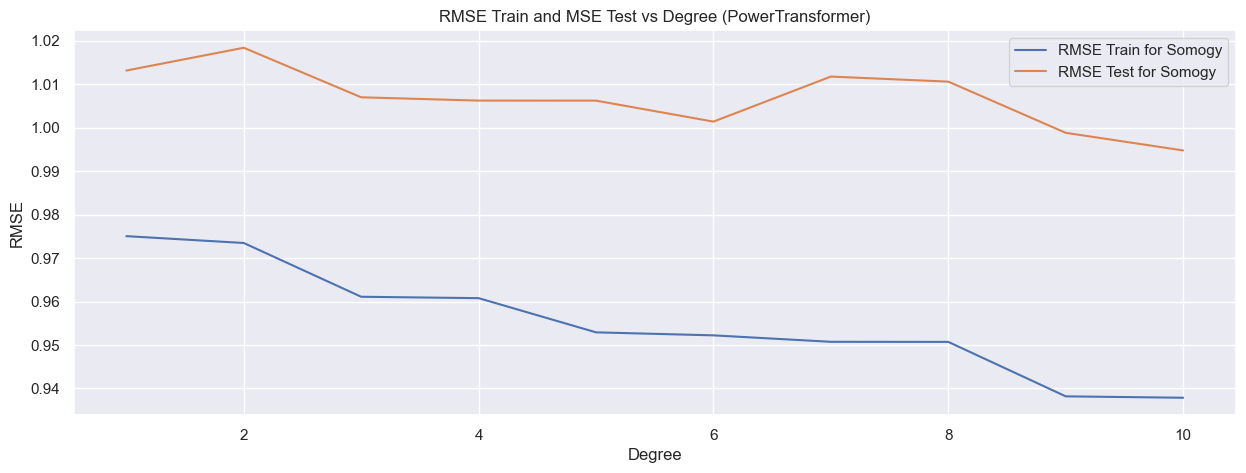

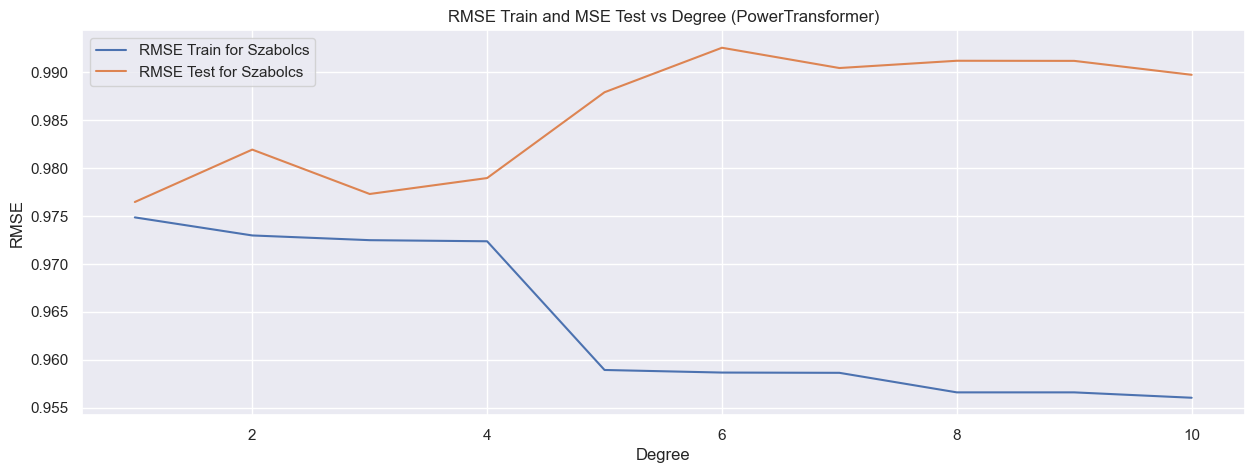

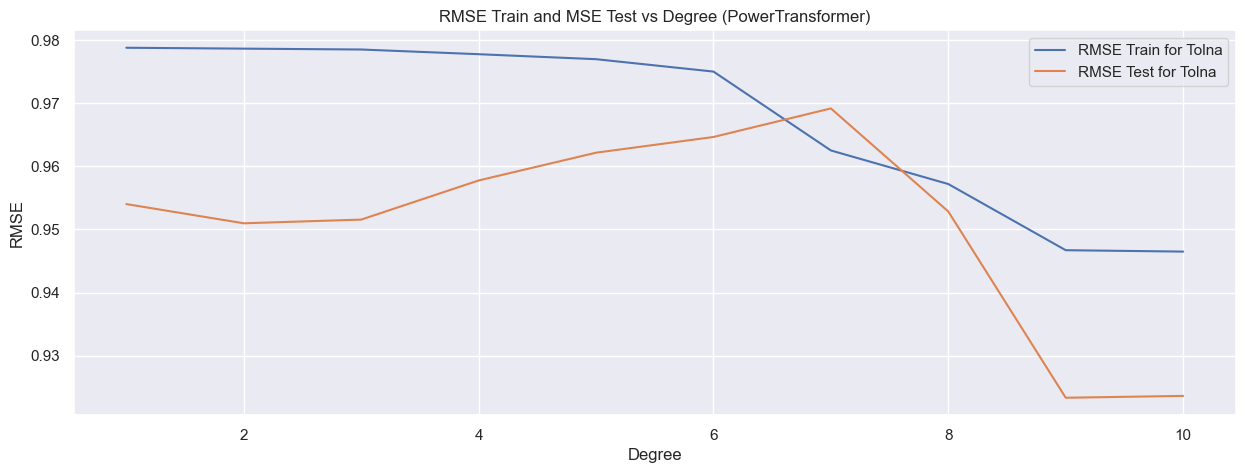

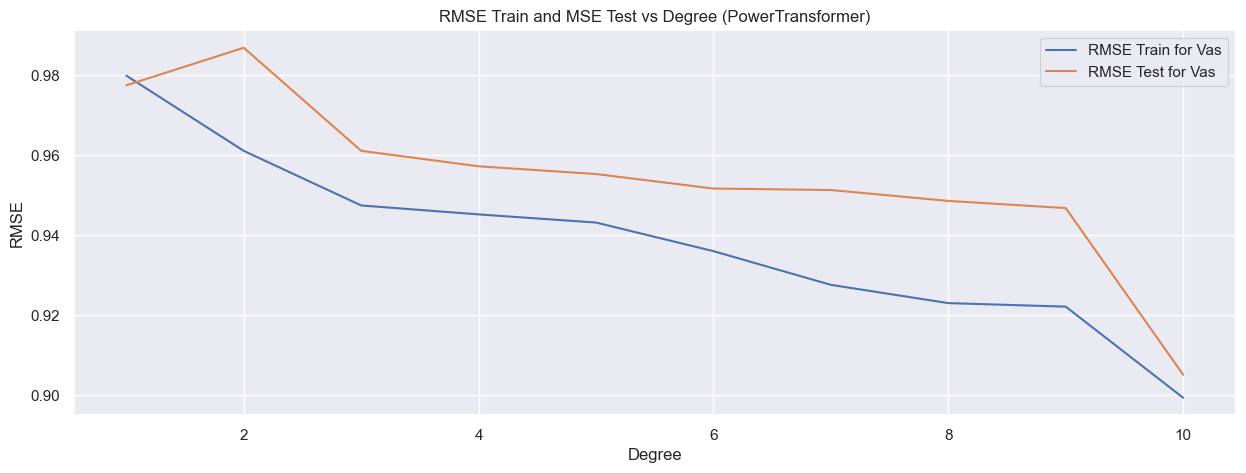

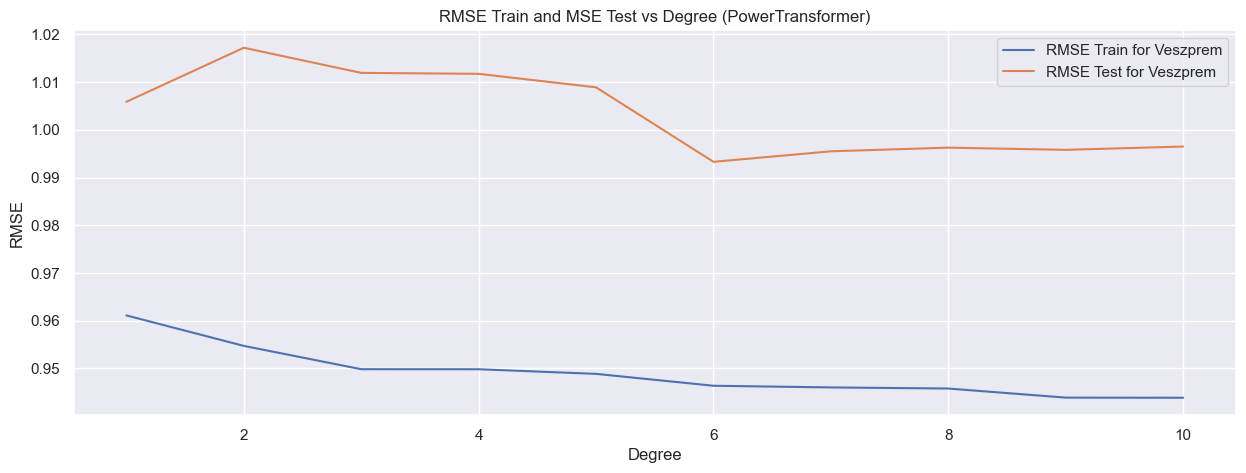

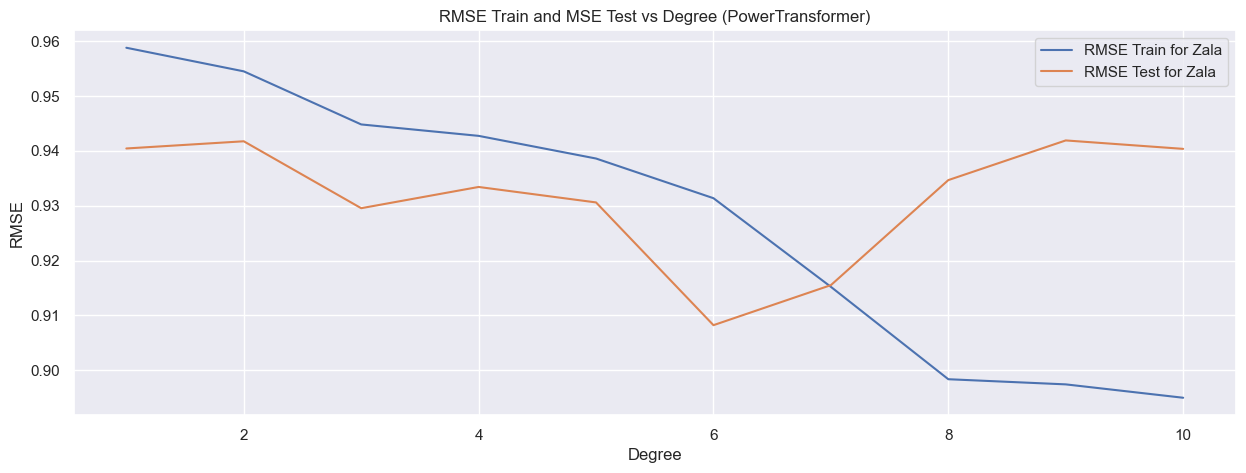

In [55]:
rmse_test_pow = []
rmse_train_pow = []

best_degrees_pow = []

for county in county_list:

    rmse_test_county_pow = []
    rmse_train_county_pow = []

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        # Normalize the target variable
        y_scaled_pow = scaler_pow.fit_transform(y.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow, y_test_pow = train_test_split(y_scaled_pow, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model POW
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow)

        # Predict y values for train and test sets
        y_train_pred_pow = model.predict(x_train_poly_pow)
        y_test_pred_pow = model.predict(x_test_poly_pow)

        rmse_train_county_pow.append(rmse(y_train_pred_pow, y_train_pow))
        rmse_test_county_pow.append(rmse(y_test_pred_pow, y_test_pow))

    rmse_test_pow.append(np.min(rmse_test_county_pow))
    rmse_train_pow.append(rmse_test_county_pow[np.argmin(rmse_test_county_pow)])
    best_degrees_pow.append(np.argmin(rmse_test_county_pow) + 1)

    plt.plot(degrees, rmse_train_county_pow, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_pow, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (PowerTransformer)')
    plt.legend()
    plt.grid(True)
    plt.show()

PowerTransformer, Log

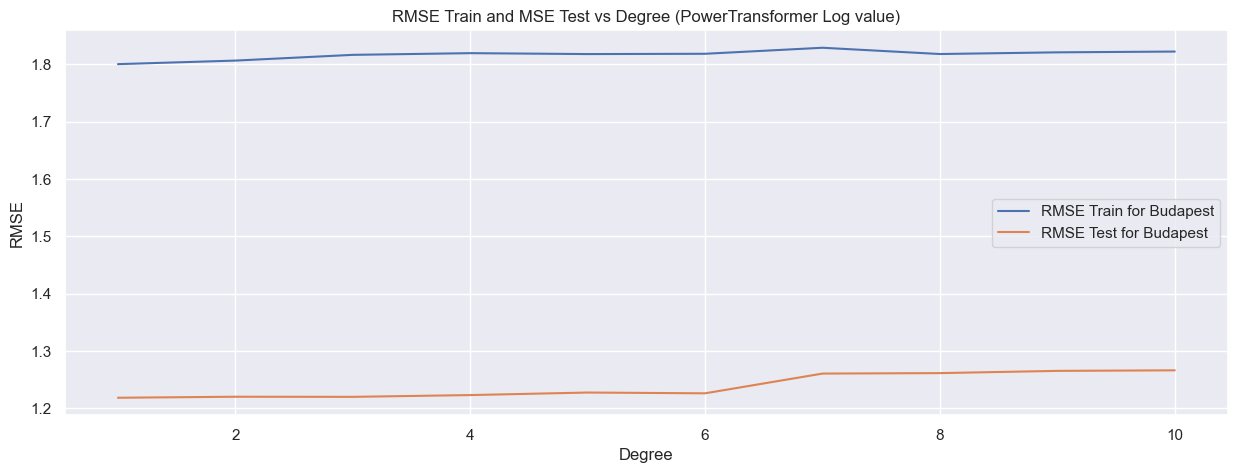

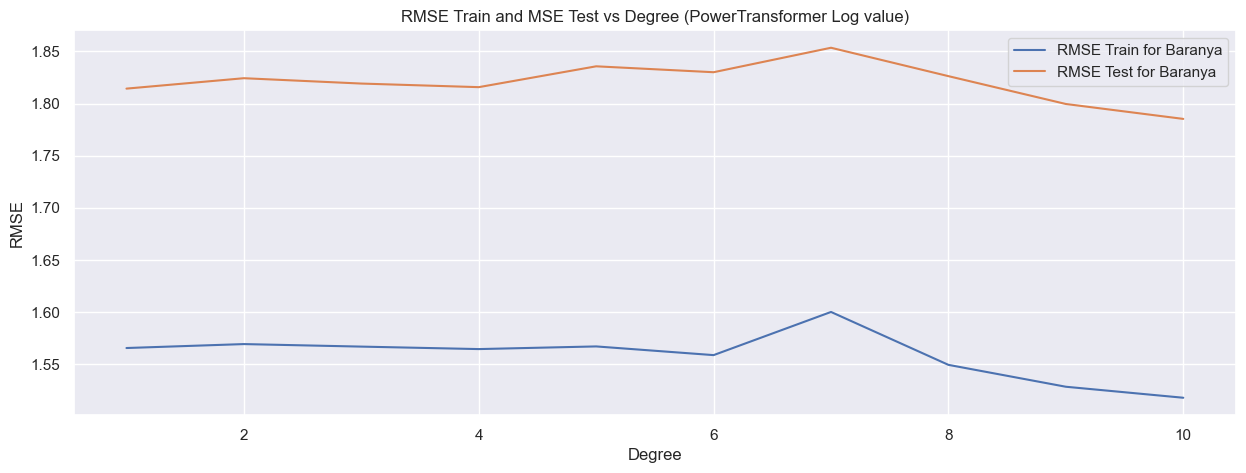

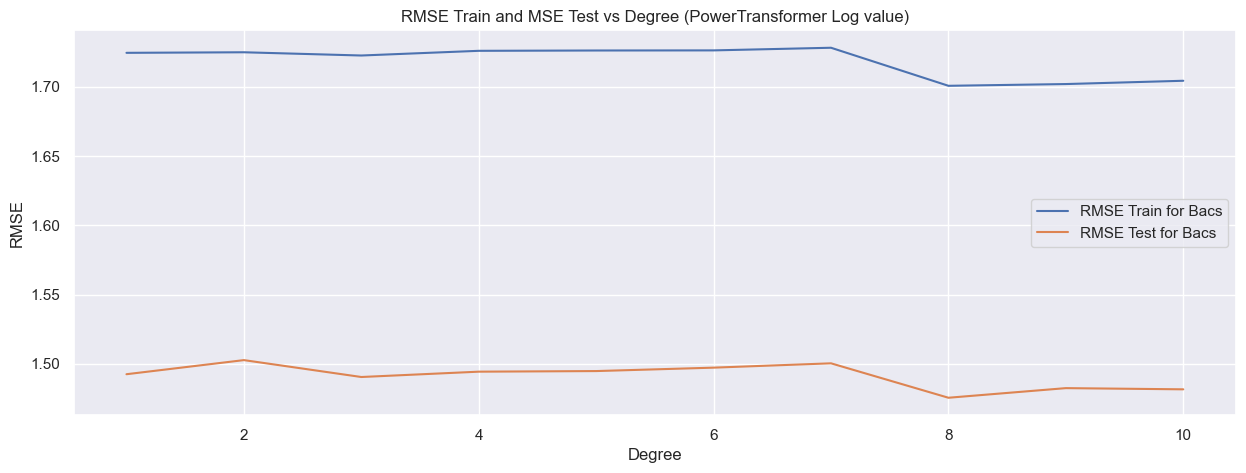

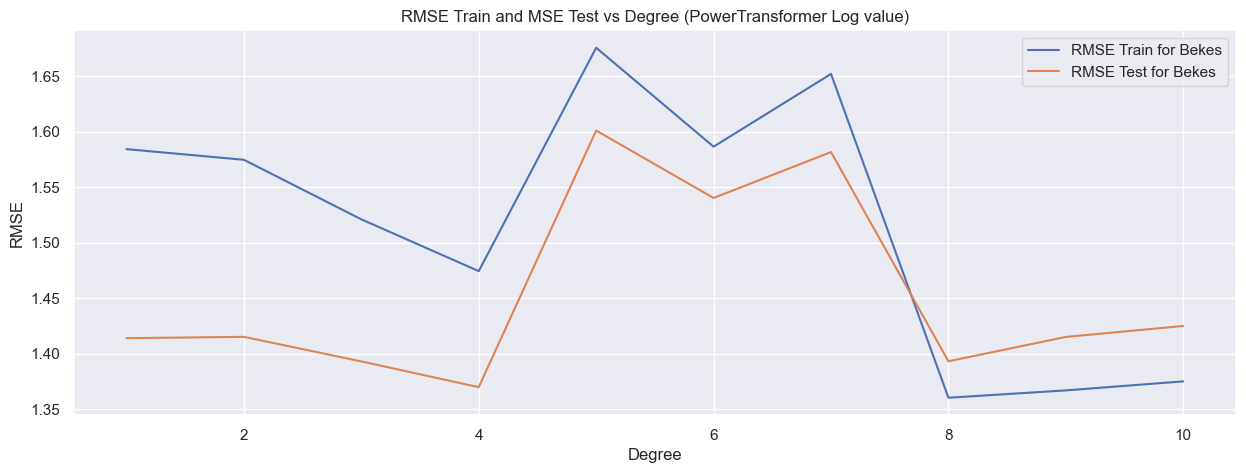

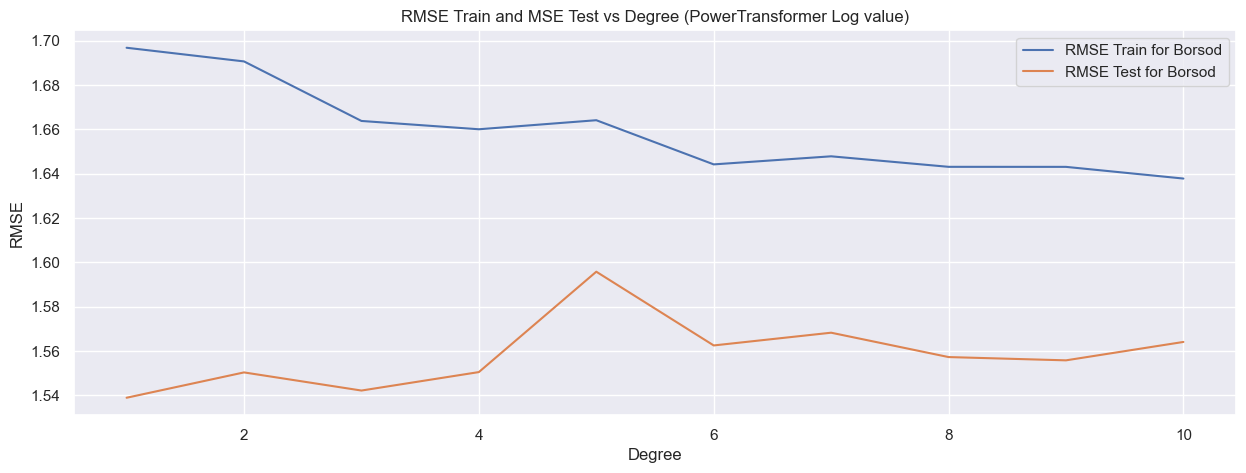

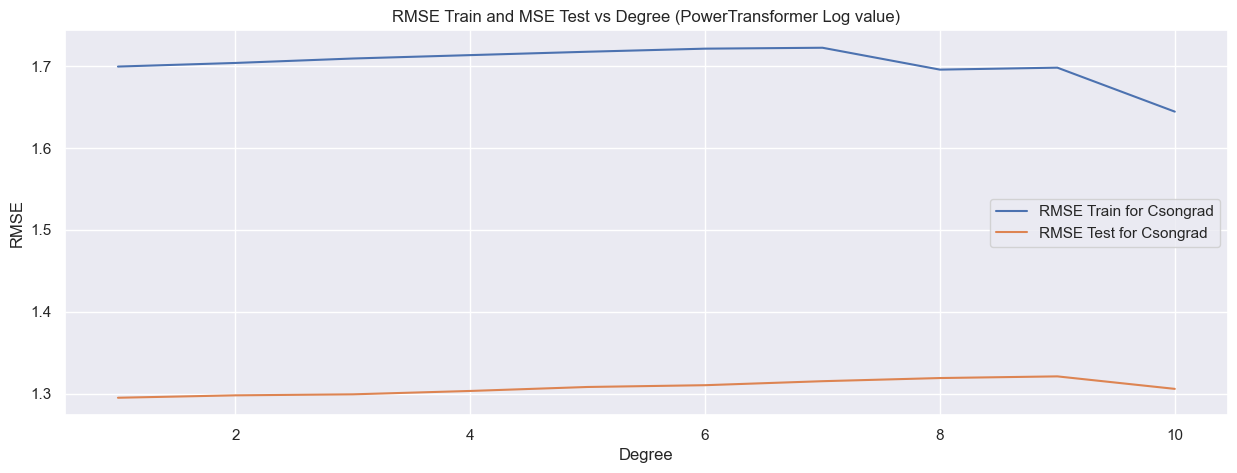

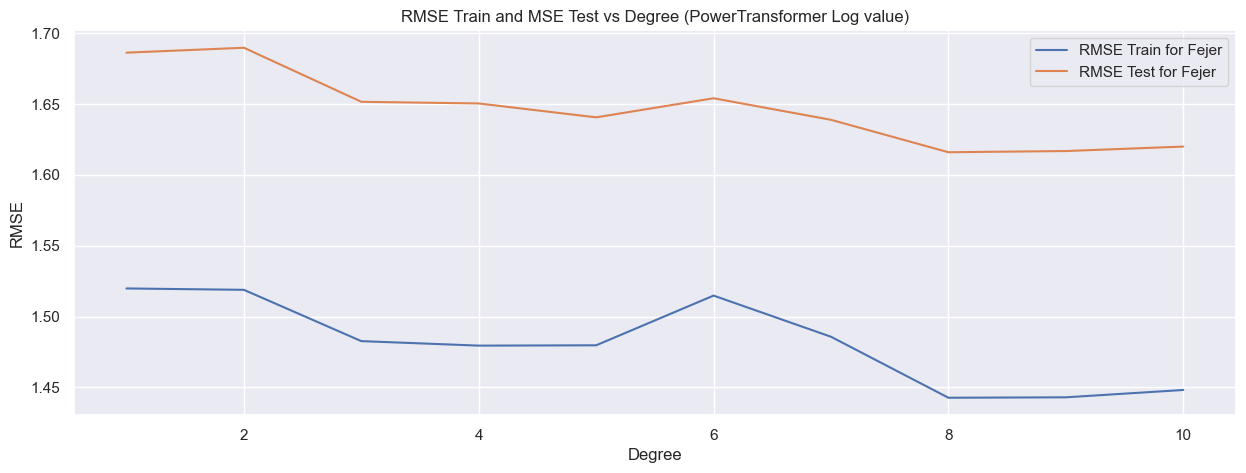

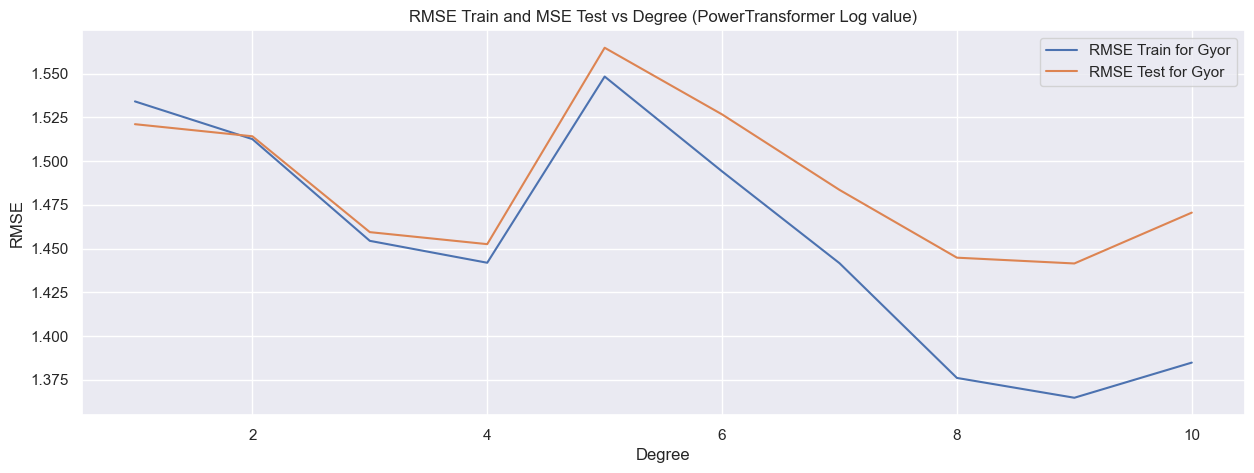

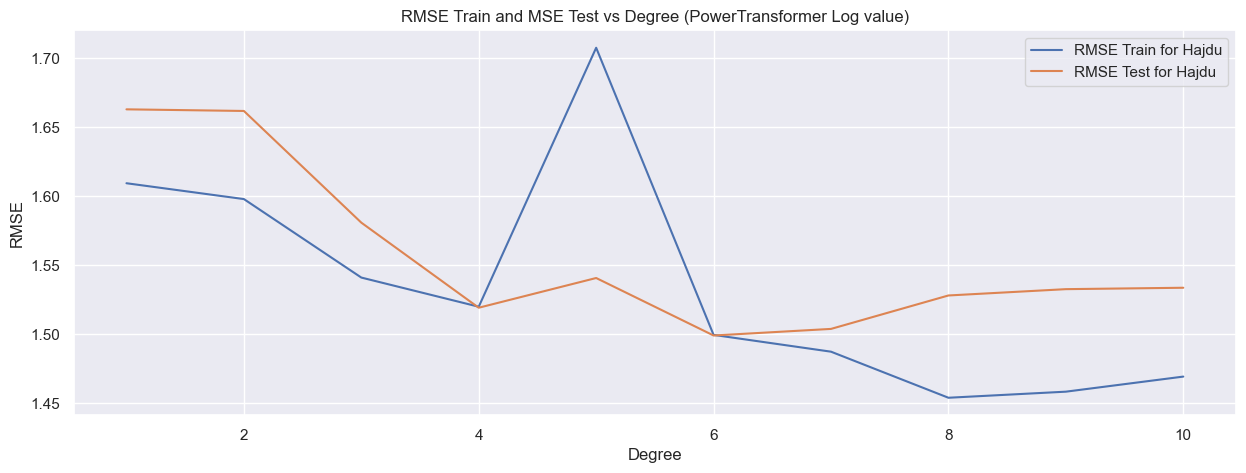

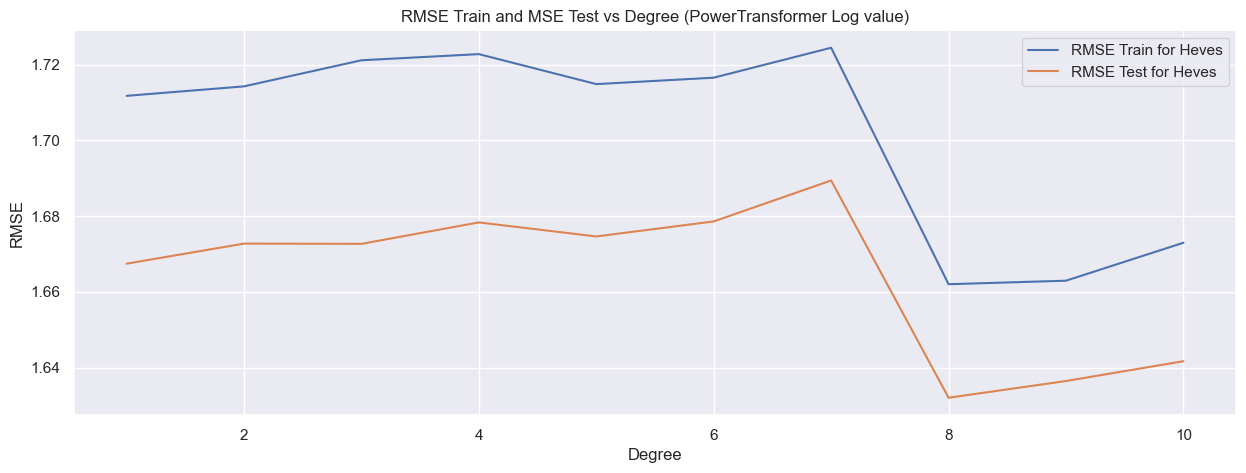

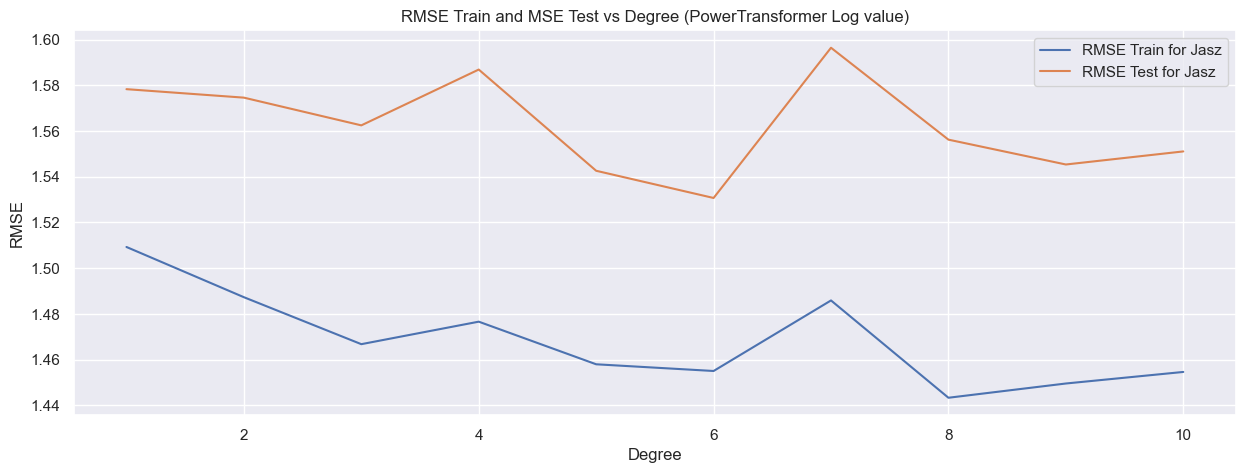

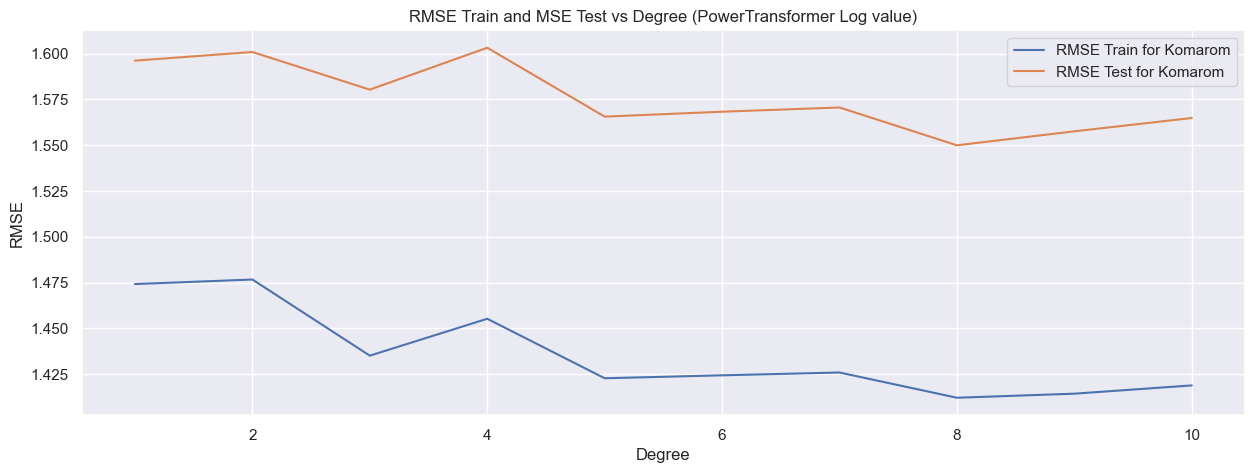

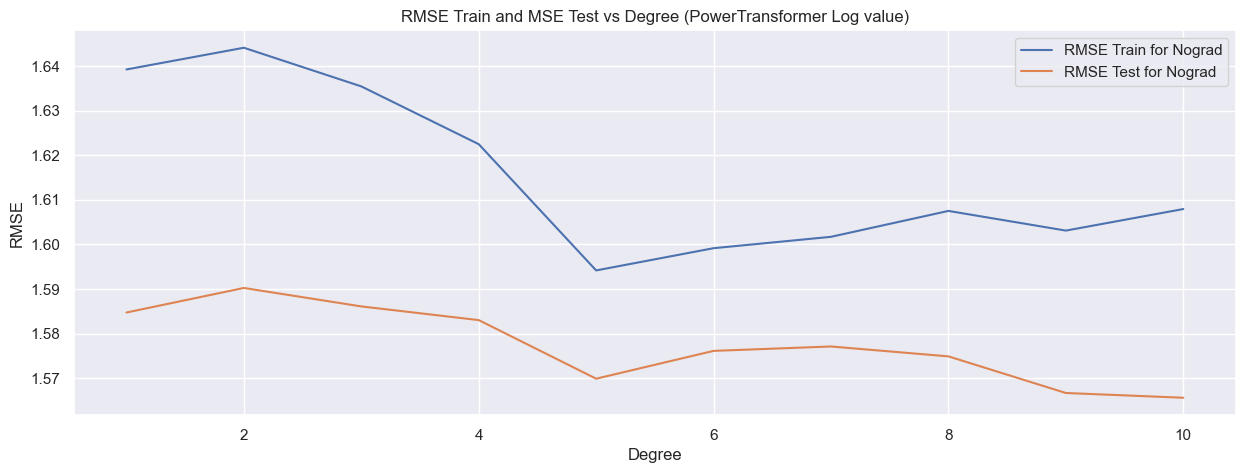

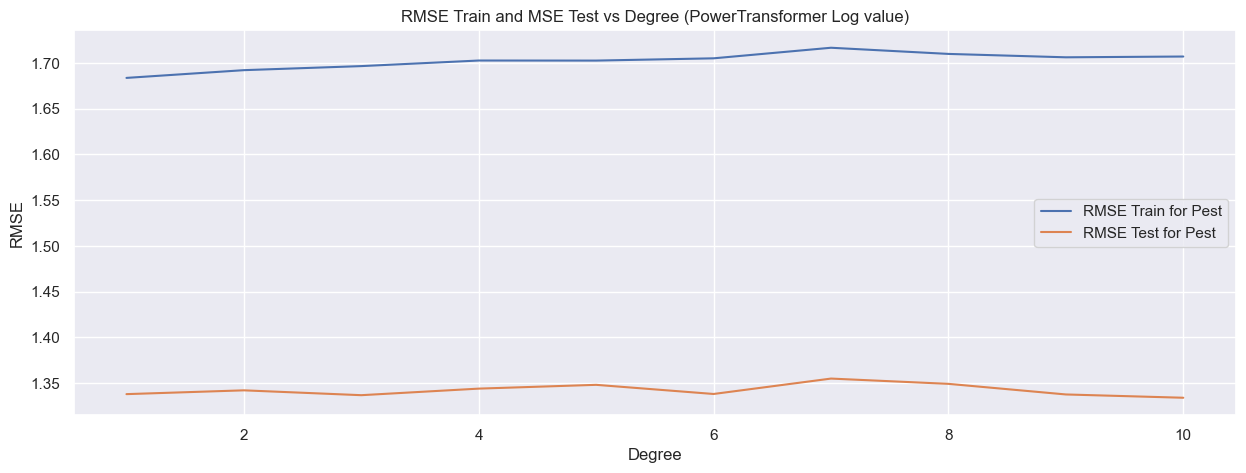

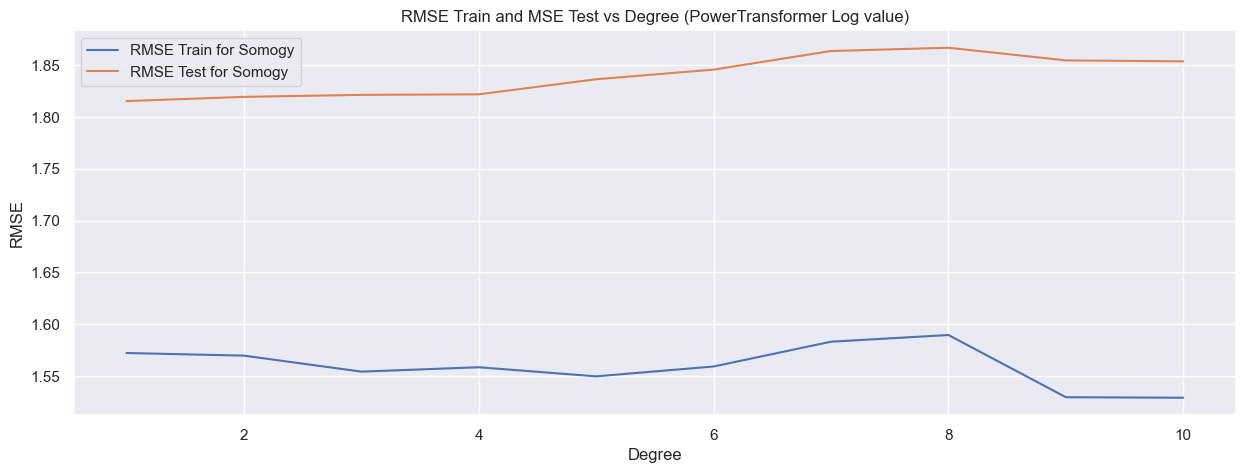

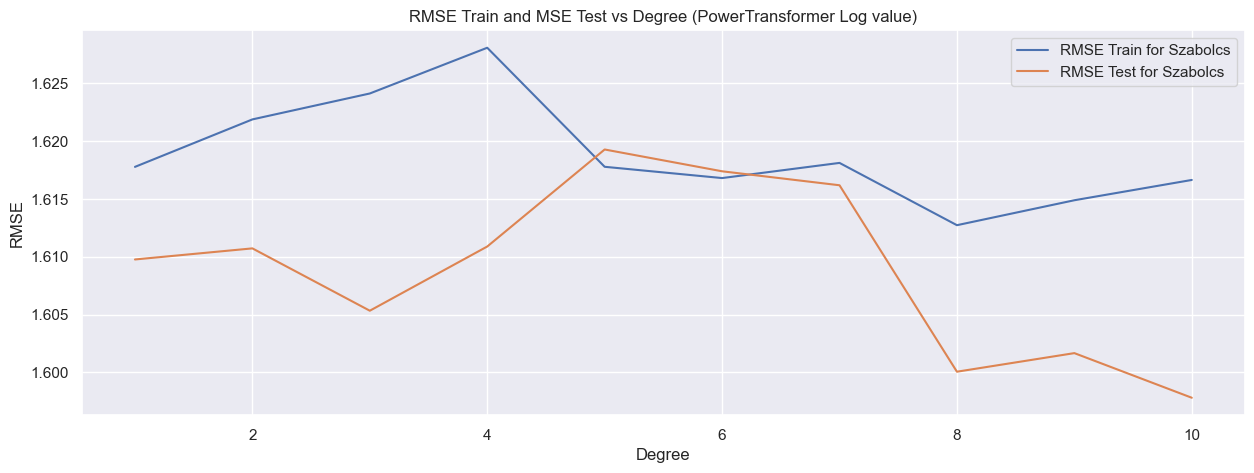

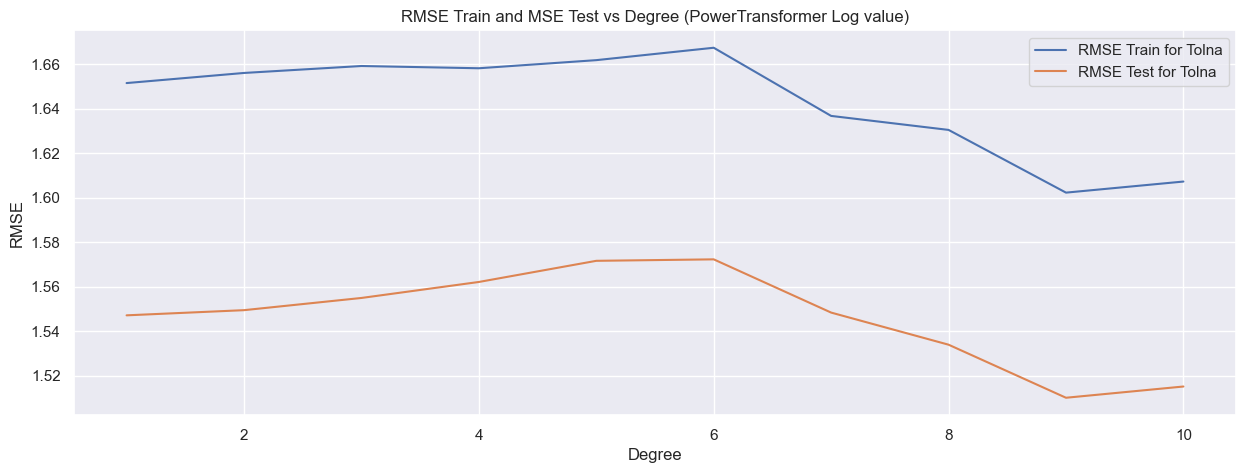

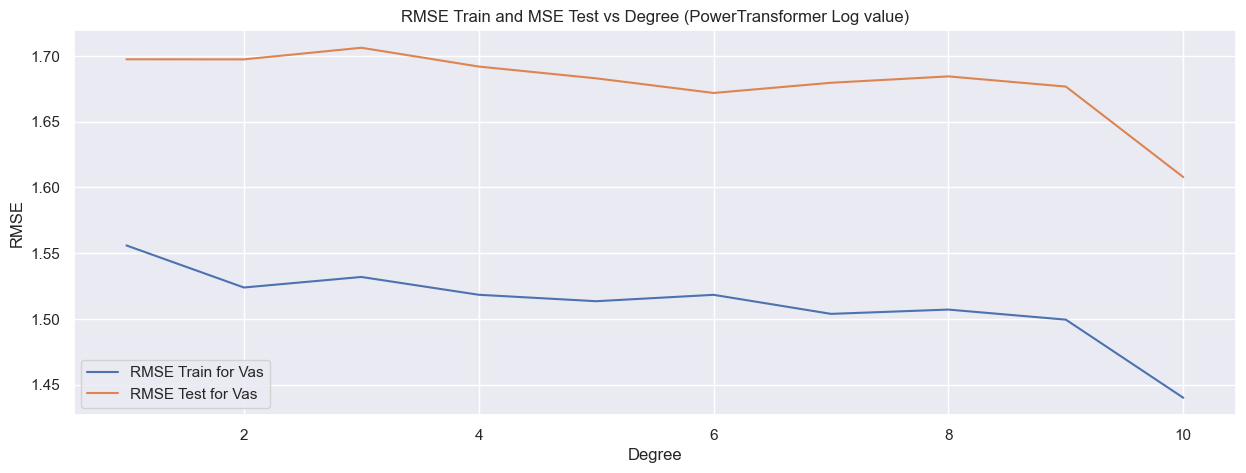

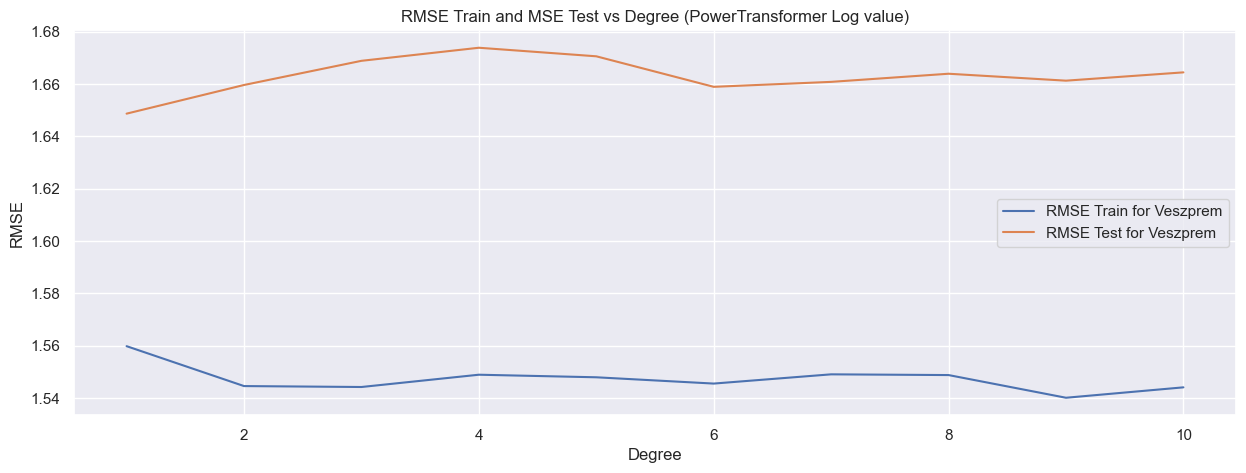

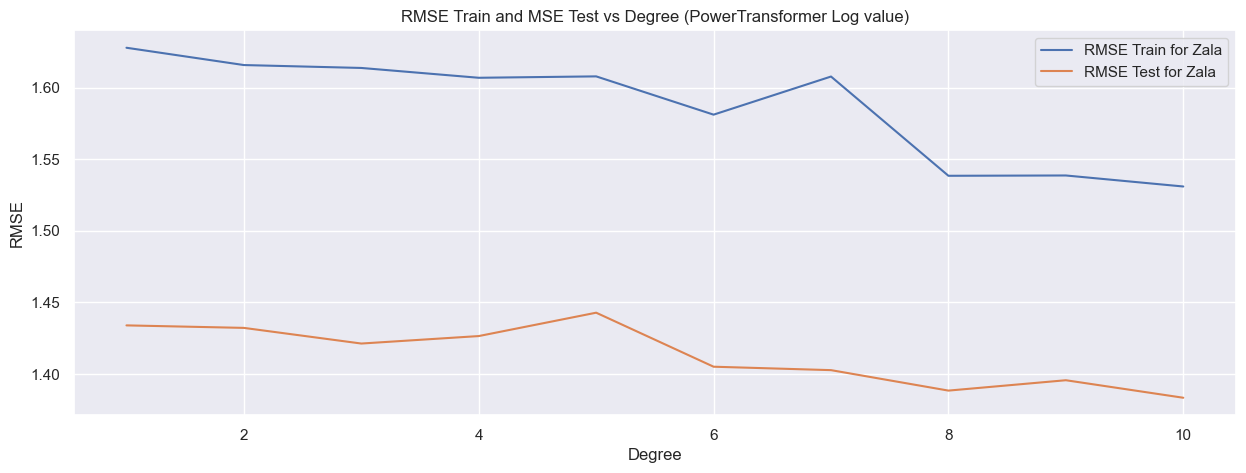

In [56]:
degrees = range(1, 11)
rmse_test_pow_log = []
rmse_train_pow_log = []

best_degrees_pow_log = []

for county in county_list:

    rmse_test_county_pow_log = []
    rmse_train_county_pow_log = []  

    for degree in degrees:    
    # Extract the target variable for the current county
        y = y_df[county].values

        y += 1

        # Logarithmic transformation of y
        y_log = np.log(y)

        # Normalize the target variable
        y_scaled_pow_log = scaler_pow.fit_transform(y_log.reshape(-1, 1)).flatten()

        # Split the target variable into train and test sets
        y_train_pow_log, y_test_pow_log = train_test_split(y_scaled_pow_log, test_size=0.2, random_state=101)

        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree)
        x_train_poly_pow = poly_features.fit_transform(x_train_pow)
        x_test_poly_pow = poly_features.transform(x_test_pow)

        # Fit polynomial regression model
        model = LinearRegression()
        model.fit(x_train_poly_pow, y_train_pow_log)

        # Predict y values for train and test sets
        y_train_pred_pow_log = model.predict(x_train_poly_pow)
        y_test_pred_pow_log = model.predict(x_test_poly_pow)

        # Detransforming y_pred_min and y_test_min
        y_train_pred_pow_log = np.exp(y_train_pred_pow_log)
        y_test_pred_pow_log = np.exp(y_test_pred_pow_log)

        y_train_pow_log = np.exp(y_train_pow_log)
        y_test_pow_log = np.exp(y_test_pow_log)

        # calculating errors
        rmse_train_county_pow_log.append(rmse(y_train_pred_pow_log, y_train_pow_log))
        rmse_test_county_pow_log.append(rmse(y_test_pred_pow_log, y_test_pow_log))
        
    rmse_test_pow_log.append(np.min(rmse_test_county_pow_log))
    rmse_train_pow_log.append(rmse_test_county_min_log[np.argmin(rmse_test_county_pow_log)])
    best_degrees_pow_log.append(np.argmin(rmse_test_county_pow_log) + 1)

    plt.plot(degrees, rmse_train_county_pow_log, label=f'RMSE Train for {county[0]}{county[1:].lower()}')
    plt.plot(degrees, rmse_test_county_pow_log, label=f'RMSE Test for {county[0]}{county[1:].lower()}')
    plt.xlabel('Degree')
    plt.ylabel('RMSE')
    plt.title('RMSE Train and MSE Test vs Degree (PowerTransformer Log value)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [57]:
new_df_list = {'County': county_list,
               'Best degree (MinMax - No Log)': best_degrees_min,
               'RMSE (MinMax - No Log)': rmse_test_min,
               'Best degree (MinMax - Log)': best_degrees_min_log,
               'RMSE (MinMax - Log)': rmse_test_min_log,
               'Best degree (Power - No Log)': best_degrees_pow,
               'RMSE (Power - No Log)': rmse_test_pow,
               'Best degree (Power - Log)': best_degrees_pow_log,
               'RMSE (Power - Log)': rmse_test_pow_log,
               }

county_with_best_degree = pd.DataFrame(new_df_list)

county_with_best_degree.set_index('County')

Best degree (MinMax - No Log)  RMSE (MinMax - No Log)   
County                                                            
BUDAPEST                              3                0.135008  \
BARANYA                              10                0.171965   
BACS                                  4                0.119877   
BEKES                                10                0.103292   
BORSOD                                8                0.135836   
CSONGRAD                              6                0.136775   
FEJER                                 8                0.183361   
GYOR                                  6                0.178377   
HAJDU                                 7                0.154654   
HEVES                                10                0.139051   
JASZ                                  4                0.156334   
KOMAROM                               4                0.144500   
NOGRAD                                9                0.175772   
PEST                                  9                0.137872   
SOMOGY                               10                0.180842   
SZABOLCS                             10                0.151802   
TOLNA                                 9                0.156616   
VAS                                   9                0.177785   
VESZPREM                             10                0.168317   
ZALA                                  5                0.083383   

          Best degree (MinMax - Log)  RMSE (MinMax - Log)   
County                                                      
BUDAPEST                           1             0.299530  \
BARANYA                           10             0.385265   
BACS                              10             0.347434   
BEKES                             10             0.288674   
BORSOD                             9             0.364508   
CSONGRAD                          10             0.327423   
FEJER                             10             0.401862   
GYOR                              10             0.408919   
HAJDU                             10             0.363041   
HEVES                             10             0.345222   
JASZ                              10             0.366468   
KOMAROM                           10             0.345616   
NOGRAD                            10             0.388311   
PEST                               1             0.350966   
SOMOGY                            10             0.399642   
SZABOLCS                          10             0.353327   
TOLNA                             10             0.349100   
VAS                               10             0.370518   
VESZPREM                          10             0.396223   
ZALA                              10             0.260552   

          Best degree (Power - No Log)  RMSE (Power - No Log)   
County                                                          
BUDAPEST                             6               0.903717  \
BARANYA                             10               0.979526   
BACS                                 5               1.003337   
BEKES                                9               0.888100   
BORSOD                               5               1.010574   
CSONGRAD                             5               0.868709   
FEJER                               10               0.953067   
GYOR                                10               0.969052   
HAJDU                                5               0.915616   
HEVES                               10               0.960461   
JASZ                                 5               0.933244   
KOMAROM                              7               0.950326   
NOGRAD                              10               0.952513   
PEST                                10               0.974191   
SOMOGY                              10               0.994769   
SZABOLCS                             1               0.976454   
TOLNA                 

In [58]:
print(f"Mean RMSE for:\nMinMax Scaler with no log transform = {np.mean(new_df_list['RMSE (MinMax - No Log)'])}\nMinMax Scaler with log transform = {np.mean(new_df_list['RMSE (MinMax - Log)'])}")
print(f"PowerTransformer with no log transform = {np.mean(new_df_list['RMSE (Power - No Log)'])}\nPowerTransformer with log transform = {np.mean(new_df_list['RMSE (Power - Log)'])}")

Mean RMSE for:
MinMax Scaler with no log transform = 0.1495709197913545
MinMax Scaler with log transform = 0.3556299549791393
PowerTransformer with no log transform = 0.9481795382315052
PowerTransformer with log transform = 1.5207324098874264


In [59]:
model_mean_rmse['Polynomial Regression - MinMaxScaler (no log)'] = np.mean(new_df_list['RMSE (MinMax - No Log)'])
model_mean_rmse['Polynomial Regression - MinMaxScaler (log)'] = np.mean(new_df_list['RMSE (MinMax - Log)'])
model_mean_rmse['Polynomial Regression - PowerTransformer (no log)'] = np.mean(new_df_list['RMSE (Power - No Log)'])
model_mean_rmse['Polynomial Regression - PowerTransformer (log)'] = np.mean(new_df_list['RMSE (Power - Log)'])

model_mean_rmse

{'Polynomial Regression - MinMaxScaler (no log)': 0.1495709197913545,
 'Polynomial Regression - MinMaxScaler (log)': 0.3556299549791393,
 'Polynomial Regression - PowerTransformer (no log)': 0.9481795382315052,
 'Polynomial Regression - PowerTransformer (log)': 1.5207324098874264}

SARIMA MODEL

In [60]:
data_diff = df.drop('Week', axis=1)

data_diff.head(2)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   

   VESZPREM  ZALA  
0        87    68  
1        68    26  

[2 rows x 21 columns]

In [61]:
data_diff['Date'] = pd.to_datetime(data_diff['Date'], format='mixed')

data_diff.head(1)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0 2005-03-01       168       79    30    173     169        42    136   120  \

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \

   VESZPREM  ZALA  
0        87    68  

[1 rows x 21 columns]

In [62]:
#data_diff = data_diff[['Date', 'BUDAPEST']].set_index('Date')

data_diff.tail()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
517 2014-01-12        95       12    41      6      39         0     16    15  \
518 2014-08-12        43       39    31     10      34         3      2    30   
519 2014-12-15        35        7    15      0       0         0      7     7   
520 2014-12-22        30       23     8      0      11         4      1     9   
521 2014-12-29       259       42    49     32      38        15     11    98   

     HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
517     14  ...    56        7      13   122       4        23      4   11  \
518     25  ...    34       20      18    70      36         5     23   22   
519      4  ...    30       36       4    72       5        21     14    0   
520     10  ...    27       17      21    12       5        17      1    1   
521     61  ...   112       61      53   256      45        39     27   11   

     VESZPREM  ZALA  
517       110    10  
518        63     9  
519        17    10  
520        83     2  
521       103    25  

[5 rows x 21 columns]

In [63]:
dates = df['Date'].to_list()

len(dates)

522

In [64]:
# Convert date strings to datetime objects
parsed_dates = pd.to_datetime(dates, format='%d/%m/%Y')

# Create a DatetimeIndex using the parsed dates
index = pd.DatetimeIndex(parsed_dates)

index

DatetimeIndex(['2005-01-03', '2005-01-10', '2005-01-17', '2005-01-24',
               '2005-01-31', '2005-02-07', '2005-02-14', '2005-02-21',
               '2005-02-28', '2005-03-07',
               ...
               '2014-10-27', '2014-11-03', '2014-11-10', '2014-11-17',
               '2014-11-24', '2014-12-01', '2014-12-08', '2014-12-15',
               '2014-12-22', '2014-12-29'],
              dtype='datetime64[ns]', length=522, freq=None)

In [65]:
data_diff['Date'] = index

data_diff.head(1)

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0 2005-01-03       168       79    30    173     169        42    136   120  \

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \

   VESZPREM  ZALA  
0        87    68  

[1 rows x 21 columns]

In [66]:
data_diff = data_diff.set_index('Date')

data_diff.head(1)

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2005-01-03       168       79    30    173     169        42    136   120  \

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2005-01-03    162     36   130       57       2   178      66        64  \

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2005-01-03     11   29        87    68

In [67]:
data_diff['BUDAPEST']

Date
2005-01-03    168
2005-01-10    157
2005-01-17     96
2005-01-24    163
2005-01-31    122
             ... 
2014-12-01     95
2014-12-08     43
2014-12-15     35
2014-12-22     30
2014-12-29    259
Name: BUDAPEST, Length: 522, dtype: int64

In [68]:
warnings.filterwarnings("ignore")

rmse_sarimax = []
# Apply differencing to make the data stationary
data_diff = data_diff.diff().dropna()

# Define the SARIMA model parameters
order = (1, 1, 1)  # (p, d, q)
seasonal_order = (1, 0, 1, 12)  # (P, D, Q, s)

for county in county_list:
    # Apply scaling to make the data between 0 and 1
    scaled_data = scaler_min.fit_transform(data_diff[county].values.reshape(-1, 1))
    scaled_data = pd.Series(scaled_data.flatten())

    # Apply differencing to make the data stationary
    scaled_data_diff = scaled_data.diff().dropna()

    # Split the scaled data into train and test sets
    train_data, test_data = train_test_split(scaled_data_diff, test_size=0.2, random_state=101)

    # Fit the SARIMA model
    model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    # Forecast future values
    forecast = model_fit.forecast(steps=len(test_data))

    # Calculate the mean squared error (MSE) for the test set
    rmse_sarimax_county = rmse(test_data, forecast)
    print(f"RMSE for {county}:", rmse_sarimax_county)

    rmse_sarimax.append(rmse_sarimax_county)

warnings.filterwarnings("default")

RMSE for BUDAPEST: 0.1650948243589311
RMSE for BARANYA: 0.14130422981349136
RMSE for BACS: 0.11945933253572953
RMSE for BEKES: 0.10702445179289066
RMSE for BORSOD: 0.14109412876290306
RMSE for CSONGRAD: 0.19508784501050916
RMSE for FEJER: 0.21885795394681204
RMSE for GYOR: 0.19464564405492443
RMSE for HAJDU: 0.21063443232578793
RMSE for HEVES: 0.1960589447941045
RMSE for JASZ: 0.16968341295158157
RMSE for KOMAROM: 0.1733309699529605
RMSE for NOGRAD: 0.2409102120995431
RMSE for PEST: 0.15168659009947946
RMSE for SOMOGY: 0.21191623697529682
RMSE for SZABOLCS: 0.18441364244330094
RMSE for TOLNA: 0.151442303877134
RMSE for VAS: 0.15550559500677996
RMSE for VESZPREM: 0.250107387522903
RMSE for ZALA: 0.1475706168425683


In [69]:
model_mean_rmse['SARIMA Model'] = np.mean(rmse_sarimax)

XGBOOST

In [70]:
# Create lag features for each county
def create_lag_features(data, lag):
    lagged_data = data.copy()
    for col in data.columns:
        for i in range(1, lag+1):
            lagged_data[f'lag_{i}_{col}'] = data[col].shift(i)
            lagged_data[f'lag_{i}_{col}'].fillna(method='backfill', inplace=True)  # Use backfill to fill NaN values
    return lagged_data

In [71]:
data = df.drop('Week', axis=1)

data.head()

Date  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
0  03/01/2005       168       79    30    173     169        42    136   120  \
1  10/01/2005       157       60    30     92     200        53     51    70   
2  17/01/2005        96       44    31     86      93        30     93    84   
3  24/01/2005       163       49    43    126      46        39     52   114   
4  31/01/2005       122       78    53     87     103        34     95   131   

   HAJDU  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0    162  ...   130       57       2   178      66        64     11   29  \
1     84  ...    80       50      29   141      48        29     58   53   
2    191  ...    64       46       4   157      33        33     24   18   
3    107  ...    63       54      14   107      66        50     25   21   
4    172  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 21 columns]

In [72]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data = data.set_index('Date')

data.head()

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2005-01-03       168       79    30    173     169        42    136   120  \
2005-01-10       157       60    30     92     200        53     51    70   
2005-01-17        96       44    31     86      93        30     93    84   
2005-01-24       163       49    43    126      46        39     52   114   
2005-01-31       122       78    53     87     103        34     95   131   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2005-01-03    162     36   130       57       2   178      66        64  \
2005-01-10     84     28    80       50      29   141      48        29   
2005-01-17    191     51    64       46       4   157      33        33   
2005-01-24    107     42    63       54      14   107      66        50   
2005-01-31    172     40    61       49      11   124      63        56   

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2005-01-03     11   29        87    68  
2005-01-10     58   53        68    26  
2005-01-17     24   18        62    44  
2005-01-24     25   21        43    31  
2005-01-31      7   47        85    60

In [73]:
model = XGBRegressor()

In [74]:
model.learning_rate = 0.00001  # Learning rate
model.max_depth = 100  # Maximum depth of each tree
model.n_estimators = 500  # Number of trees (boosting rounds)
model.reg_alpha = 0.05  # L1 regularization term
model.reg_lambda = 0.1  # L2 regularization term

In [75]:
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=101)

lag = 3  # Adjust the lag as per your requirements
train_lagged = create_lag_features(train_data, lag)
test_lagged = create_lag_features(test_data, lag)

# Prepare the input features and target variables
X_train, y_train = train_lagged.dropna().drop(data.columns, axis=1), train_lagged.dropna()[data.columns]
X_test, y_test = test_lagged.dropna().drop(data.columns, axis=1), test_lagged.dropna()[data.columns]

y_test.head()

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
Date                                                                        
2011-02-21       228       46    32    102     164        72     54    67  \
2007-06-11       210       75    65     80     129        47     13    57   
2010-04-05       160       80   108     17      52        11     34    75   
2005-10-03        17        4     6     10      34         1     10     1   
2010-07-05        93       44    48     21      51        13     29    54   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
Date                                                                      
2011-02-21     55     22    82       61      14   189      24       102  \
2007-06-11    120     40    11       56      59   125      25        14   
2010-04-05     54     15    52       52      11   143      23        22   
2005-10-03     21      7     8       21       4    27       6         3   
2010-07-05     21     20    71       20       8    70      37        40   

            TOLNA  VAS  VESZPREM  ZALA  
Date                                    
2011-02-21     43   30        98    35  
2007-06-11     22    7        32    16  
2010-04-05     35   17        39     6  
2005-10-03      1   17        20    13  
2010-07-05     23    7        50    24

In [76]:
# data = pd.DataFrame(scaler_pow.fit_transform(data), columns=data.columns)

X_train = scaler_pow.fit_transform(X_train)
X_test = scaler_pow.fit_transform(X_test)

# Train the XGBoost model for each county and calculate RMSE
rmse_score = {}
for county in county_list:   

    print(f"Looping for {county}...")

    Y_train = y_train[county] 
    Y_test = np.array(y_test[county].to_list())

    Y_train = scaler_min.fit_transform(np.array(Y_train).reshape(-1, 1))
    Y_test = scaler_min.fit_transform(Y_test.reshape(-1, 1))

    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    rmse_county = rmse(Y_test, y_pred)
    rmse_score[county] = rmse_county

print("DONE!")

# Print overall RMSE score for each county
for county, error in rmse_score.items():
    print(f"County: {county}, RMSE: {error}")

Looping for BUDAPEST...
Looping for BARANYA...
Looping for BACS...
Looping for BEKES...
Looping for BORSOD...
Looping for CSONGRAD...
Looping for FEJER...
Looping for GYOR...
Looping for HAJDU...
Looping for HEVES...
Looping for JASZ...
Looping for KOMAROM...
Looping for NOGRAD...
Looping for PEST...
Looping for SOMOGY...
Looping for SZABOLCS...
Looping for TOLNA...
Looping for VAS...
Looping for VESZPREM...
Looping for ZALA...
DONE!
County: BUDAPEST, RMSE: 0.2809682249432416
County: BARANYA, RMSE: 0.35776838550007656
County: BACS, RMSE: 0.3292728520046604
County: BEKES, RMSE: 0.3797913118634765
County: BORSOD, RMSE: 0.31639733351281374
County: CSONGRAD, RMSE: 0.36037390969168465
County: FEJER, RMSE: 0.33631032699277813
County: GYOR, RMSE: 0.31163951369738957
County: HAJDU, RMSE: 0.3570889097116844
County: HEVES, RMSE: 0.3562591060696142
County: JASZ, RMSE: 0.36242019348436183
County: KOMAROM, RMSE: 0.3447297764758108
County: NOGRAD, RMSE: 0.3331289408743029
County: PEST, RMSE: 0.28469

In [77]:
rmse_xg = []
for county, score in rmse_score.items():
    rmse_xg.append(score)

model_mean_rmse['XGBOOST Model'] = np.mean(rmse_xg)

np.mean(rmse_xg)

0.3462065596390666

Prophet

In [79]:
# Load the CSV file
data = df

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data.rename(columns={'Date': 'ds'}, inplace=True)

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=101)

rmse_proph = {}

for county in county_list:

    print(f"Working on {county}...")

    # Prepare the target variable
    target_col = county  # Choose the county for analysis
    train_target = train_data[['ds', target_col]].rename(columns={'ds': 'ds', target_col: 'y'})

    # Scale the training data
    scaler_min.fit(train_target[['y']])
    train_target['y'] = scaler_min.transform(train_target[['y']])

    # Scale the test data
    test_target = test_data[['ds', target_col]].rename(columns={'ds': 'ds', target_col: 'y'})
    test_target['y'] = scaler_min.transform(test_target[['y']])

    # Train the Prophet model
    model = Prophet()
    model.add_seasonality(name='weekly', period=7, fourier_order=10, mode='additive')
    model.fit(train_target)

    # Generate future dates for prediction
    future = model.make_future_dataframe(periods=len(test_data), freq='W-MON')

    # Perform predictions
    forecast = model.predict(future)

    # Extract the predicted values (scaled)
    y_pred_scaled = forecast['yhat'].tail(len(test_data))

    # Prepare the true values (scaled) for evaluation
    y_true_scaled = test_target[['y']].values

    # Calculate RMSE
    rmse_proph[county] = np.sqrt(mean_squared_error(y_true_scaled, y_pred_scaled))

print("Model Fitting and Validation done!")

Working on BUDAPEST...


03:25:37 - cmdstanpy - INFO - Chain [1] start processing
03:25:37 - cmdstanpy - INFO - Chain [1] done processing


Working on BARANYA...


03:25:38 - cmdstanpy - INFO - Chain [1] start processing
03:25:38 - cmdstanpy - INFO - Chain [1] done processing


Working on BACS...


03:25:38 - cmdstanpy - INFO - Chain [1] start processing
03:25:39 - cmdstanpy - INFO - Chain [1] done processing


Working on BEKES...


03:25:39 - cmdstanpy - INFO - Chain [1] start processing
03:25:39 - cmdstanpy - INFO - Chain [1] done processing


Working on BORSOD...


03:25:40 - cmdstanpy - INFO - Chain [1] start processing
03:25:40 - cmdstanpy - INFO - Chain [1] done processing
03:25:40 - cmdstanpy - INFO - Chain [1] start processing


Working on CSONGRAD...


03:25:40 - cmdstanpy - INFO - Chain [1] done processing


Working on FEJER...


03:25:41 - cmdstanpy - INFO - Chain [1] start processing
03:25:41 - cmdstanpy - INFO - Chain [1] done processing


Working on GYOR...


03:25:41 - cmdstanpy - INFO - Chain [1] start processing
03:25:41 - cmdstanpy - INFO - Chain [1] done processing


Working on HAJDU...


03:25:42 - cmdstanpy - INFO - Chain [1] start processing
03:25:42 - cmdstanpy - INFO - Chain [1] done processing
03:25:42 - cmdstanpy - INFO - Chain [1] start processing


Working on HEVES...


03:25:42 - cmdstanpy - INFO - Chain [1] done processing
03:25:43 - cmdstanpy - INFO - Chain [1] start processing


Working on JASZ...


03:25:43 - cmdstanpy - INFO - Chain [1] done processing
03:25:43 - cmdstanpy - INFO - Chain [1] start processing


Working on KOMAROM...


03:25:43 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


Working on NOGRAD...


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


Working on PEST...


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:44 - cmdstanpy - INFO - Chain [1] start processing


Working on SOMOGY...


03:25:44 - cmdstanpy - INFO - Chain [1] done processing
03:25:45 - cmdstanpy - INFO - Chain [1] start processing


Working on SZABOLCS...


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:45 - cmdstanpy - INFO - Chain [1] start processing


Working on TOLNA...


03:25:45 - cmdstanpy - INFO - Chain [1] done processing
03:25:46 - cmdstanpy - INFO - Chain [1] start processing


Working on VAS...


03:25:46 - cmdstanpy - INFO - Chain [1] done processing
03:25:46 - cmdstanpy - INFO - Chain [1] start processing


Working on VESZPREM...


03:25:46 - cmdstanpy - INFO - Chain [1] done processing
03:25:47 - cmdstanpy - INFO - Chain [1] start processing


Working on ZALA...


03:25:47 - cmdstanpy - INFO - Chain [1] done processing


Model Fitting and Validation done!


In [80]:
for county, error in rmse_proph.items():
    print(f"County: {county}, RMSE: {error}")

County: BUDAPEST, RMSE: 0.18811621621545224
County: BARANYA, RMSE: 0.233359862921806
County: BACS, RMSE: 0.1545399543480643
County: BEKES, RMSE: 0.14355272274336495
County: BORSOD, RMSE: 0.1694336796561163
County: CSONGRAD, RMSE: 0.19369948047845933
County: FEJER, RMSE: 0.24471670704729911
County: GYOR, RMSE: 0.26204863113390037
County: HAJDU, RMSE: 0.22267579945809768
County: HEVES, RMSE: 0.17052553333495704
County: JASZ, RMSE: 0.2517548112075624
County: KOMAROM, RMSE: 0.21422252538814288
County: NOGRAD, RMSE: 0.2356291037747593
County: PEST, RMSE: 0.2009244617174931
County: SOMOGY, RMSE: 0.25194208739572393
County: SZABOLCS, RMSE: 0.18448401255948657
County: TOLNA, RMSE: 0.19673132896344855
County: VAS, RMSE: 0.22769413246265113
County: VESZPREM, RMSE: 0.24484153564546698
County: ZALA, RMSE: 0.1127646790602222


In [81]:
rmse_prophet = []

for county, score in rmse_proph.items():
    rmse_prophet.append(score)

model_mean_rmse['Prophet Model'] = np.mean(rmse_prophet)

np.mean(rmse_prophet)

0.20518286327562377

RNN

In [82]:
data = df

data.columns

Index(['Week', 'ds', 'BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD',
       'CSONGRAD', 'FEJER', 'GYOR', 'HAJDU', 'HEVES', 'JASZ', 'KOMAROM',
       'NOGRAD', 'PEST', 'SOMOGY', 'SZABOLCS', 'TOLNA', 'VAS', 'VESZPREM',
       'ZALA'],
      dtype='object')

In [83]:
data = data.drop('Week', axis=1).set_index('ds')
data = data.asfreq('W-MON')

data

BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER  GYOR   
ds                                                                          
2005-01-03       168       79    30    173     169        42    136   120  \
2005-01-10       157       60    30     92     200        53     51    70   
2005-01-17        96       44    31     86      93        30     93    84   
2005-01-24       163       49    43    126      46        39     52   114   
2005-01-31       122       78    53     87     103        34     95   131   
...              ...      ...   ...    ...     ...       ...    ...   ...   
2014-12-01        95       12    41      6      39         0     16    15   
2014-12-08        43       39    31     10      34         3      2    30   
2014-12-15        35        7    15      0       0         0      7     7   
2014-12-22        30       23     8      0      11         4      1     9   
2014-12-29       259       42    49     32      38        15     11    98   

            HAJDU  HEVES  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS   
ds                                                                        
2005-01-03    162     36   130       57       2   178      66        64  \
2005-01-10     84     28    80       50      29   141      48        29   
2005-01-17    191     51    64       46       4   157      33        33   
2005-01-24    107     42    63       54      14   107      66        50   
2005-01-31    172     40    61       49      11   124      63        56   
...           ...    ...   ...      ...     ...   ...     ...       ...   
2014-12-01     14     10    56        7      13   122       4        23   
2014-12-08     25     19    34       20      18    70      36         5   
2014-12-15      4      2    30       36       4    72       5        21   
2014-12-22     10     17    27       17      21    12       5        17   
2014-12-29     61     38   112       61      53   256      45        39   

            TOLNA  VAS  VESZPREM  ZALA  
ds                                      
2005-01-03     11   29        87    68  
2005-01-10     58   53        68    26  
2005-01-17     24   18        62    44  
2005-01-24     25   21        43    31  
2005-01-31      7   47        85    60  
...           ...  ...       ...   ...  
2014-12-01      4   11       110    10  
2014-12-08     23   22        63     9  
2014-12-15     14    0        17    10  
2014-12-22      1    1        83     2  
2014-12-29     27   11       103    25  

[522 rows x 20 columns]

In [84]:
data = pd.DataFrame(scaler_min.fit_transform(data), columns=data.columns)

data.head()

BUDAPEST   BARANYA      BACS     BEKES    BORSOD  CSONGRAD     FEJER   
0  0.350731  0.407216  0.109489  0.638376  0.476056  0.211055  0.829268  \
1  0.327766  0.309278  0.109489  0.339483  0.563380  0.266332  0.310976   
2  0.200418  0.226804  0.113139  0.317343  0.261972  0.150754  0.567073   
3  0.340292  0.252577  0.156934  0.464945  0.129577  0.195980  0.317073   
4  0.254697  0.402062  0.193431  0.321033  0.290141  0.170854  0.579268   

       GYOR     HAJDU     HEVES      JASZ  KOMAROM    NOGRAD      PEST   
0  0.662983  0.618321  0.171429  0.580357  0.35625  0.017857  0.412993  \
1  0.386740  0.320611  0.133333  0.357143  0.31250  0.258929  0.327146   
2  0.464088  0.729008  0.242857  0.285714  0.28750  0.035714  0.364269   
3  0.629834  0.408397  0.200000  0.281250  0.33750  0.125000  0.248260   
4  0.723757  0.656489  0.190476  0.272321  0.30625  0.098214  0.287703   

     SOMOGY  SZABOLCS     TOLNA       VAS  VESZPREM      ZALA  
0  0.425806  0.315271  0.083969  0.205674  0.378261  0.314815  
1  0.309677  0.142857  0.442748  0.375887  0.295652  0.120370  
2  0.212903  0.162562  0.183206  0.127660  0.269565  0.203704  
3  0.425806  0.246305  0.190840  0.148936  0.186957  0.143519  
4  0.406452  0.275862  0.053435  0.333333  0.369565  0.277778

In [85]:
rmse_rnn = {}

for county in county_list:
    print(county)
    # Preprocess the data
    data_rnn = data[county].values  # Extract the values as a NumPy array
    data_rnn = data_rnn.reshape(-1, 1)  # Reshape to a 2D array (number of samples, 1)

    # Split the data into training and testing sets
    train_data, test_data = train_test_split(data_rnn, test_size=0.2, random_state=101)

    # Create sequences of input/output pairs for training
    sequence_length = 15  # Number of time steps to look back
    X_train, y_train = [], []
    for i in range(len(train_data) - sequence_length):
        X_train.append(train_data[i:i+sequence_length])
        y_train.append(train_data[i+sequence_length])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshape the input data to match the requirements of LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the RNN model
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
    model.add(LSTM(units=100, activation='relu', return_sequences=True))
    model.add(LSTM(units=100, activation='relu', return_sequences=False))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # Generate predictions for the test data
    X_test, y_test = [], []
    for i in range(len(test_data) - sequence_length):
        X_test.append(test_data[i:i+sequence_length])
        y_test.append(test_data[i+sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predictions = model.predict(X_test)

    # Evaluate the model
    rmse_rnn[county] = rmse(predictions, y_test)

BUDAPEST


Epoch 1/50
13/13 [==============================] - 4s 21ms/step - loss: 0.0558
Epoch 2/50
13/13 [==============================] - 0s 23ms/step - loss: 0.0285
Epoch 3/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0282
Epoch 4/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0278
Epoch 5/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0273
Epoch 6/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0273
Epoch 7/50
13/13 [==============================] - 0s 24ms/step - loss: 0.0273
Epoch 8/50
13/13 [==============================] - 0s 28ms/step - loss: 0.0273
Epoch 9/50
13/13 [==============================] - 0s 26ms/step - loss: 0.0277
Epoch 10/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0276
Epoch 11/50
13/13 [==============================] - 0s 27ms/step - loss: 0.0274
Epoch 12/50
13/13 [==============================] - 0s 26ms/step - loss: 0.0274
Epoch 13/50
13/13 [==================

In [86]:
rmse_rnn

{'BUDAPEST': 0.13558159445434514,
 'BARANYA': 0.17743369128599146,
 'BACS': 0.11721656094111517,
 'BEKES': 0.10804745039660696,
 'BORSOD': 0.1344565275766276,
 'CSONGRAD': 0.14085489106947863,
 'FEJER': 0.19982021706565417,
 'GYOR': 0.19157387906231518,
 'HAJDU': 0.1726851029653337,
 'HEVES': 0.14470490882131248,
 'JASZ': 0.143804269939173,
 'KOMAROM': 0.14055776351621901,
 'NOGRAD': 0.19366968667485673,
 'PEST': 0.14220680238384176,
 'SOMOGY': 0.19259011347848987,
 'SZABOLCS': 0.15515515171891367,
 'TOLNA': 0.16782424780059302,
 'VAS': 0.17619157729627097,
 'VESZPREM': 0.18772819030942692,
 'ZALA': 0.0892442866390383}

In [87]:
rmse_r = []

for county, score in rmse_rnn.items():
    rmse_r.append(score)

model_mean_rmse['RNN Model'] = np.mean(rmse_r)

np.mean(rmse_r)

0.15556734566978017

In [88]:
model_mean_rmse

{'Polynomial Regression - MinMaxScaler (no log)': 0.1495709197913545,
 'Polynomial Regression - MinMaxScaler (log)': 0.3556299549791393,
 'Polynomial Regression - PowerTransformer (no log)': 0.9481795382315052,
 'Polynomial Regression - PowerTransformer (log)': 1.5207324098874264,
 'SARIMA Model': 0.17629143775838158,
 'XGBOOST Model': 0.3462065596390666,
 'Prophet Model': 0.20518286327562377,
 'RNN Model': 0.15556734566978017}

Thus, the average root mean squared error is lowest for polynomial regression using MinMax scaler without log tranformation. Hence, we will be predicting the future cases using it.

Predicting cases:

In [89]:
predictions_df = pd.DataFrame({'Week': np.arange(x.max() + 1, x.max() + 101)})

predictions_df.head(2)

Week
0   523
1   524

In [90]:
best_degrees_min

[3, 10, 4, 10, 8, 6, 8, 6, 7, 10, 4, 4, 9, 9, 10, 10, 9, 9, 10, 5]

In [91]:
df.head()

Week         ds  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1 2005-01-03       168       79    30    173     169        42    136  \
1     2 2005-01-10       157       60    30     92     200        53     51   
2     3 2005-01-17        96       44    31     86      93        30     93   
3     4 2005-01-24       163       49    43    126      46        39     52   
4     5 2005-01-31       122       78    53     87     103        34     95   

   GYOR  ...  JASZ  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS   
0   120  ...   130       57       2   178      66        64     11   29  \
1    70  ...    80       50      29   141      48        29     58   53   
2    84  ...    64       46       4   157      33        33     24   18   
3   114  ...    63       54      14   107      66        50     25   21   
4   131  ...    61       49      11   124      63        56      7   47   

   VESZPREM  ZALA  
0        87    68  
1        68    26  
2        62    44  
3        43    31  
4        85    60  

[5 rows x 22 columns]

In [92]:
for i in range(len(county_list)):
    # Extract the target variable for the current county
    y = df[county_list[i]].values

    # Normalize the target variable
    y_scaled = scaler_min.fit_transform(y.reshape(-1, 1)).flatten()

    # Create polynomial features
    poly_features = PolynomialFeatures(degree=best_degrees_min[i])
    x_poly = poly_features.fit_transform(x_scaled_min)

    # Fit polynomial regression model
    model = LinearRegression()
    model.fit(x_poly, y_scaled)

    # Predict the next 100 weeks
    future_weeks = np.arange(x_scaled_min.max() + 1, x_scaled_min.max() + 101)
    future_x = scaler_min.transform(future_weeks.reshape(-1, 1))
    future_x_poly = poly_features.transform(future_x)
    future_y_scaled = model.predict(future_x_poly)

    # Denormalize the predicted values
    future_y = scaler_min.inverse_transform(future_y_scaled.reshape(-1, 1)).flatten()

    # Add predictions to the dataframe
    predictions_df[county_list[i]] = future_y

predictions_df = predictions_df.round()

In [93]:
print("Predictions for next 100 weeks can be seen as follows:")
predictions_df

Predictions for next 100 weeks can be seen as follows:


Week  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   GYOR   
0    523     121.0     73.0  69.0  159.0   139.0      32.0   88.0  121.0  \
1    524     121.0     68.0  68.0  150.0   133.0      34.0   78.0  110.0   
2    525     121.0     63.0  67.0  140.0   128.0      36.0   69.0  101.0   
3    526     120.0     58.0  66.0  131.0   123.0      38.0   61.0   93.0   
4    527     120.0     53.0  64.0  121.0   118.0      40.0   53.0   85.0   
..   ...       ...      ...   ...    ...     ...       ...    ...    ...   
95   618     105.0     45.0  37.0   24.0    70.0      36.0   36.0   32.0   
96   619     105.0     45.0  37.0   24.0    70.0      36.0   36.0   32.0   
97   620     105.0     46.0  37.0   23.0    70.0      36.0   37.0   32.0   
98   621     105.0     46.0  38.0   22.0    70.0      36.0   38.0   32.0   
99   622     105.0     46.0  38.0   21.0    70.0      36.0   39.0   32.0   

    HAJDU  ...  JASZ  KOMAROM  NOGRAD   PEST  SOMOGY  SZABOLCS  TOLNA   VAS   
0   158.0  ...  98.0     65.0    15.0  160.0    56.0      61.0   18.0  43.0  \
1   147.0  ...  94.0     62.0    14.0  153.0    45.0      56.0   16.0  41.0   
2   137.0  ...  91.0     60.0    14.0  146.0    37.0      52.0   15.0  39.0   
3   128.0  ...  89.0     58.0    15.0  140.0    32.0      49.0   16.0  39.0   
4   119.0  ...  86.0     55.0    16.0  134.0    29.0      46.0   18.0  40.0   
..    ...  ...   ...      ...     ...    ...     ...       ...    ...   ...   
95   59.0  ...  44.0     27.0    23.0  112.0    23.0      19.0   15.0  19.0   
96   59.0  ...  45.0     27.0    21.0  111.0    23.0      19.0   17.0  20.0   
97   59.0  ...  45.0     26.0    20.0  110.0    23.0      19.0   18.0  21.0   
98   59.0  ...  45.0     26.0    18.0  110.0    24.0      19.0   20.0  22.0   
99   58.0  ...  45.0     26.0    17.0  109.0    24.0      20.0   21.0  23.0   

    VESZPREM  ZALA  
0       89.0  37.0  
1       78.0  37.0  
2       69.0  37.0  
3       62.0  37.0  
4       58.0  38.0  
..       ...   ...  
95      31.0  16.0  
96      31.0  16.0  
97      31.0  16.0  
98      31.0  16.0  
99      31.0  16.0  

[100 rows x 21 columns]

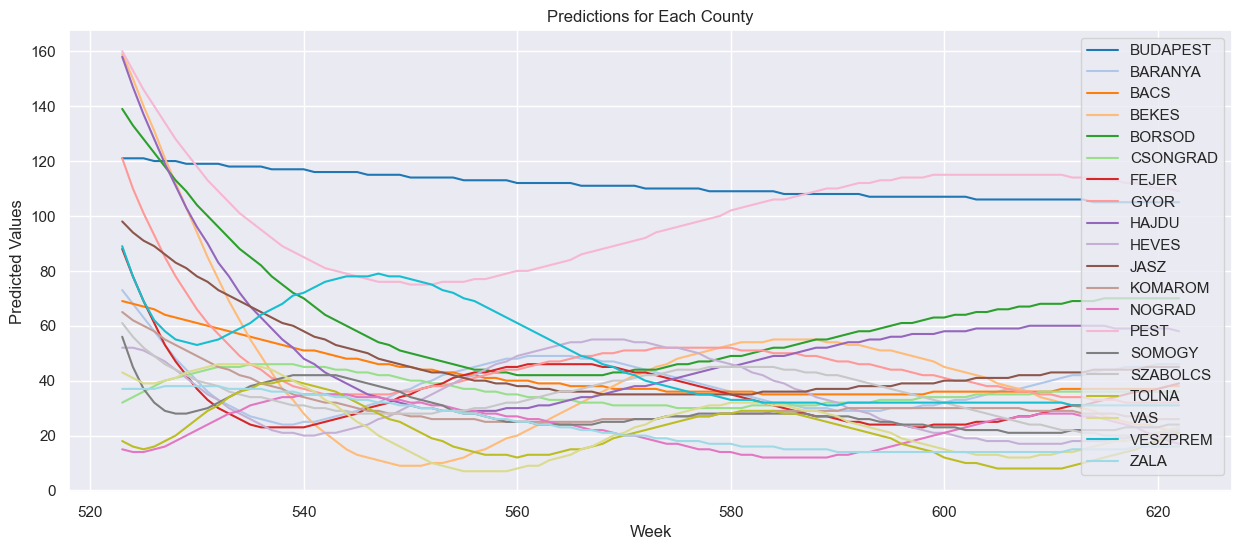

In [94]:
colors = plt.cm.tab20(np.linspace(0, 1, 20))  # Generate 20 different colors

# Set the figsize
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the predictions for each county with different colors
for i, col in enumerate(predictions_df.columns[1:]):
    plt.plot(predictions_df['Week'], predictions_df[col], label=col, color=colors[i])

plt.xlabel('Week')
plt.ylabel('Predicted Values')
plt.title('Predictions for Each County')
plt.legend()
plt.grid(True)
plt.show()

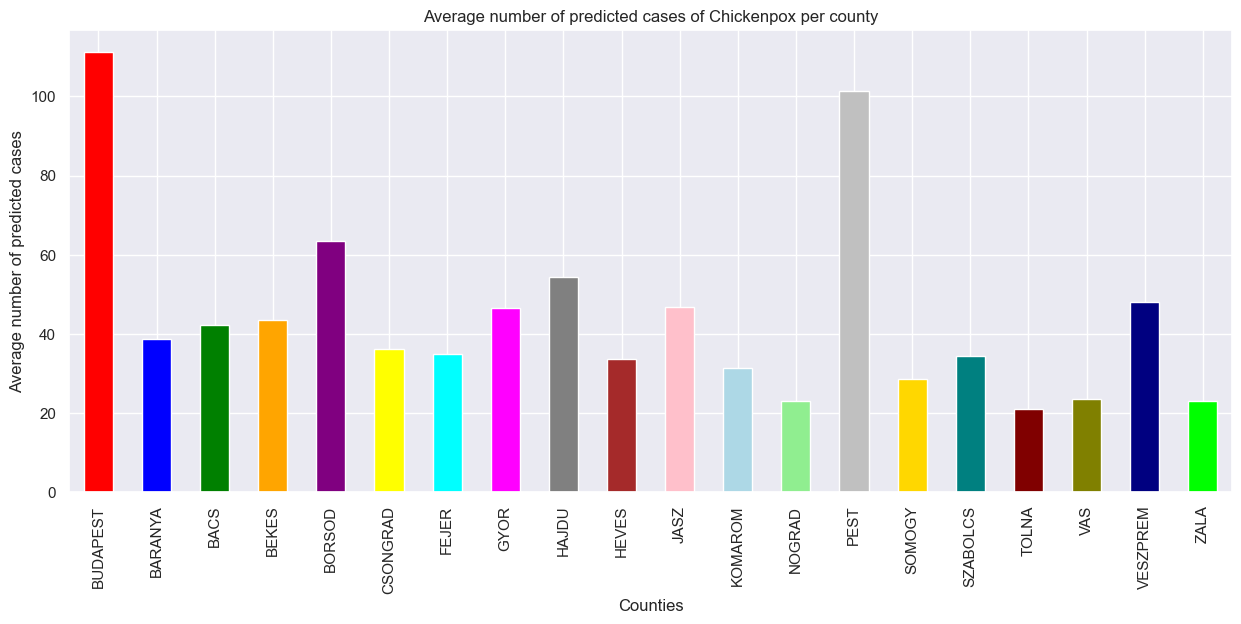

In [95]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown','pink', 'lightblue', 'lightgreen', 
          'silver', 'gold', 'teal', 'maroon', 'olive', 'navy', 'lime']
 
predictions_df[county_list].mean().plot(kind='bar', color=colors, figsize=(15, 6), grid=True)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.xlabel('Counties')
plt.ylabel('Average number of predicted cases')
plt.title('Average number of predicted cases of Chickenpox per county')

plt.show()

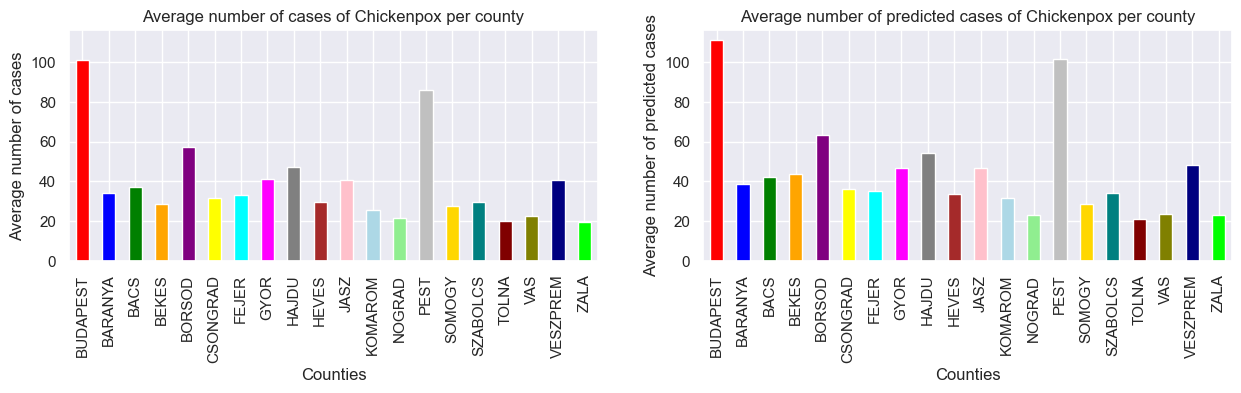

In [96]:
# Define the colors for the plots
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'gray', 'brown',
          'pink', 'lightblue', 'lightgreen', 'silver', 'gold', 'teal', 'maroon', 'olive', 'navy', 'lime']

# Create subplots with a 1x2 grid layout
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

avg_cases = df[county_list].mean()

avg_predicted_cases = predictions_df[county_list].mean()

if avg_cases.max() > avg_predicted_cases.max():
    max_cases = avg_cases.max()
else:
    max_cases = avg_predicted_cases.max()

# Plot the average number of cases
avg_cases.plot(kind='bar', color=colors, ax=axes[0], grid=True)
axes[0].set_xticklabels(avg_cases.index, rotation=90)
axes[0].set_xlabel('Counties')
axes[0].set_ylabel('Average number of cases')
axes[0].set_title('Average number of cases of Chickenpox per county')
axes[0].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Plot the average number of predicted cases
avg_predicted_cases.plot(kind='bar', color=colors, ax=axes[1], grid=True)
axes[1].set_xticklabels(avg_predicted_cases.index, rotation=90)
axes[1].set_xlabel('Counties')
axes[1].set_ylabel('Average number of predicted cases')
axes[1].set_title('Average number of predicted cases of Chickenpox per county')
axes[1].set_ylim([0, np.round(max_cases + 5)])  # Set y-axis limits

# Adjust the spacing between subplots
#plt.tight_layout()

# Display the plots
plt.show()

Total Cases in Hungary:

In [97]:
df['total'] = df[county_list].sum(axis=1)

df.head()

Week         ds  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   
0     1 2005-01-03       168       79    30    173     169        42    136  \
1     2 2005-01-10       157       60    30     92     200        53     51   
2     3 2005-01-17        96       44    31     86      93        30     93   
3     4 2005-01-24       163       49    43    126      46        39     52   
4     5 2005-01-31       122       78    53     87     103        34     95   

   GYOR  ...  KOMAROM  NOGRAD  PEST  SOMOGY  SZABOLCS  TOLNA  VAS  VESZPREM   
0   120  ...       57       2   178      66        64     11   29        87  \
1    70  ...       50      29   141      48        29     58   53        68   
2    84  ...       46       4   157      33        33     24   18        62   
3   114  ...       54      14   107      66        50     25   21        43   
4   131  ...       49      11   124      63        56      7   47        85   

   ZALA  total  
0    68   1807  
1    26   1407  
2    44   1284  
3    31   1255  
4    60   1478  

[5 rows x 23 columns]

In [98]:
predictions_df['total'] = predictions_df[county_list].sum(axis=1)

predictions_df.head()

Week  BUDAPEST  BARANYA  BACS  BEKES  BORSOD  CSONGRAD  FEJER   GYOR   
0   523     121.0     73.0  69.0  159.0   139.0      32.0   88.0  121.0  \
1   524     121.0     68.0  68.0  150.0   133.0      34.0   78.0  110.0   
2   525     121.0     63.0  67.0  140.0   128.0      36.0   69.0  101.0   
3   526     120.0     58.0  66.0  131.0   123.0      38.0   61.0   93.0   
4   527     120.0     53.0  64.0  121.0   118.0      40.0   53.0   85.0   

   HAJDU  ...  KOMAROM  NOGRAD   PEST  SOMOGY  SZABOLCS  TOLNA   VAS   
0  158.0  ...     65.0    15.0  160.0    56.0      61.0   18.0  43.0  \
1  147.0  ...     62.0    14.0  153.0    45.0      56.0   16.0  41.0   
2  137.0  ...     60.0    14.0  146.0    37.0      52.0   15.0  39.0   
3  128.0  ...     58.0    15.0  140.0    32.0      49.0   16.0  39.0   
4  119.0  ...     55.0    16.0  134.0    29.0      46.0   18.0  40.0   

   VESZPREM  ZALA   total  
0      89.0  37.0  1654.0  
1      78.0  37.0  1557.0  
2      69.0  37.0  1473.0  
3      62.0  37.0  1404.0  
4      58.0  38.0  1340.0  

[5 rows x 22 columns]

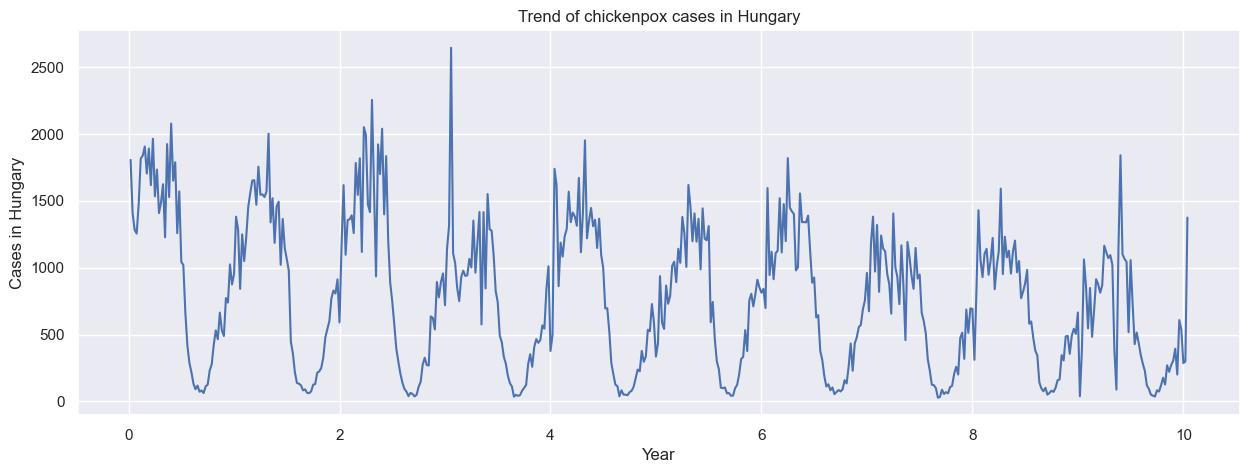

In [99]:
# Set the figure size
sns.set(rc={'figure.figsize': (15, 5)})

sns.lineplot(y=df['total'].to_list(), x=(df['Week'] / 52).to_list())

# Set labels and title
plt.xlabel("Year")
plt.ylabel("Cases in Hungary")

plt.title(f"Trend of chickenpox cases in Hungary")

# Display the plot
plt.show()

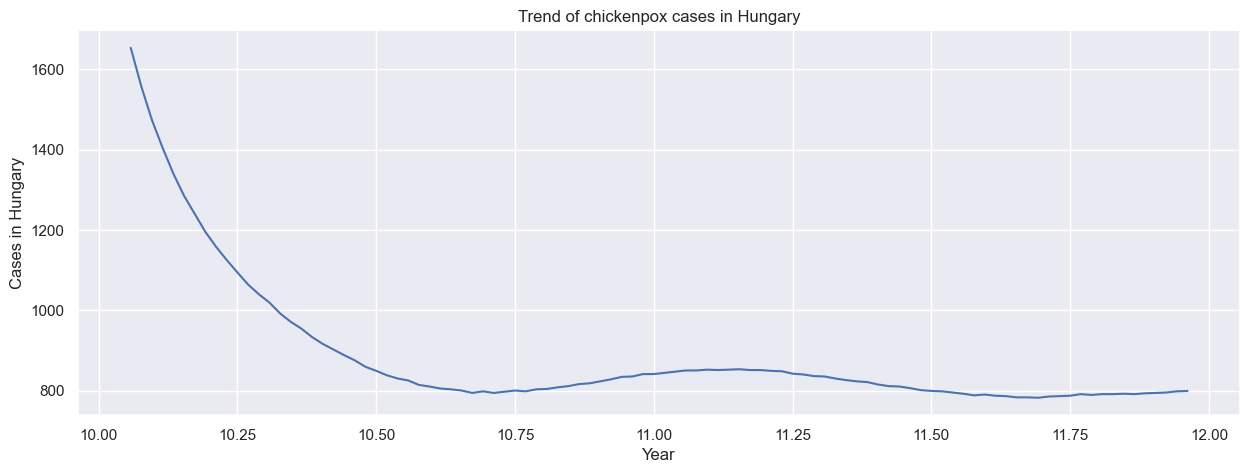

In [100]:
# Set the figure size
sns.set(rc={'figure.figsize': (15, 5)})

sns.lineplot(y=predictions_df['total'].to_list(), x=(predictions_df['Week'] / 52).to_list())

# Set labels and title
plt.xlabel("Year")
plt.ylabel("Cases in Hungary")

plt.title(f"Trend of chickenpox cases in Hungary")

# Display the plot
plt.show()